# Segmentez des clients d'un site e-commerce

- **Projet 5 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 2 : Essais de modélisation

<img  width="76" height="30" src="./brand.svg" alt="Logo olist">


# 1. Compréhension du problème

## 1.1 Mission

[Olist](https://olist.com/), une entreprise brésilienne qui propose une solution de vente sur les
marketplaces en ligne, souhaite une **segmentation des clients** que ses équipes d'e-commerce pourront
utiliser au quotidien pour leurs campagnes de communication.

- **comprendre les différents types d'utilisateurs**, grâce à leur comportement et à leurs données
  personnelles, en regroupant des clients de profils similaires. Ces catégories pourront être
  utilisées par l’équipe Marketing pour mieux communiquer.

- **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique
  sous-jacente pour une utilisation optimale

- **une proposition de contrat de maintenance**, (fréquence à laquelle la segmentation doit être
  mise à jour pour rester pertinente), basée sur une analyse de la stabilité des segments au cours
  du temps.


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# de-commentarise la ligne suivant pour des versions testées :

# %pip install -r requirements.txt


In [2]:
def install_libraries(required=None) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas', 'matplotlib', 'seaborn',
                      'scipy', 'scikit-learn', 'statsmodels',
                       'dython', 'squarify', 'yellowbrick'}
install_libraries(required_libraries)


### 1.2.1 Import des bibliothèques


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import dython
import squarify
import yellowbrick
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; scipy==1.7.3; sklearn==1.0.2; dython==0.6.8; yellowbrick==1.4


### 1.2.3 Configuration défauts d'affichage


In [5]:
from sklearn import set_config
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

set_config(display='diagram')
# displays HTML representation in a jupyter context


### 1.2.4 Quelque constants


In [6]:
# Set random_state pour reproduire les resultats
# Pour des resultats différents sur chaque execution, set RANDOM_SEED=None
RANDOM_SEED = 0

# Taille d'echantillon à utiliser pour scoring des models sur un ParameterGrid
SAMPLE_SIZE = 10000

# colonne qui reçoive les labels des clusters produit par la classification
CLUSTER_COL = 'cluster_id'

# colonne qui reçoive les pourcentages dans chaque cluster apres df.groupby(CLUSTER_COL)
# ou df[CLUSTER_COL].value_counts(normalize=True)
CLUSTER_PCT = 'cluster_pct'

# colonne pour ordonner les clusters (s'il est present), avant d'afficher en graphique
VALUE_COL = 'MonetaryValue'

# palette de couleurs pour les plots des clusters
# (pour d'autres graphiques on utilise tab10/tab20)
CLUSTER_PALETTE = 'nipy_spectral'


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [7]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/essais'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [8]:
def to_png(fig_name=None) -> None:
    """
    Register the current plot figure as an image in a file.
    Must call plt.show() or show image (by calling to_png() as last row in python cell)
    to apply the call 'bbox_inches=tight', to be sure to include the whole title / legend
    in the plot area.
    """

    def get_title() -> str:
        """find current plot title (or suptitle if more than one plot)"""
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(':', '-').replace(
            '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [9]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


### 1.3.3 Noms des variables

Pour comprendre les variables

#### Les données

- **df_clients** : data.groupby(unique_customer_id) - données nettoyés (on ne modifie pas)
- **df_clients_sample** : un échantillon de df_clients
- **client_clusters** : les clients avec attribution de cluster_id (association à un cluster)

#### Les preprocessors

- **preprocessor_XXX** ou **prep_XXX** : pipeline de preprocessing

#### Pour chaque essai (N)

- **N** : un nombre ou un abbreviation comme _RFM_, _Kmeans_, _CAH_ etc :
- **ESSAI_N** : titre d'un essai
- **features_N** : les features choisis pour un essai
- **model_N** : le model pour l'essai, composé de preprocessor_XXX et un classifier
- **df_clusters_N** : un dataframe avec 'unique_customer_id' comme index,
  contenant au moins le cluster_id dans colonne CLUSTER_COL
- **df_segmentation_N** : un dataframe avec aggregations par cluster_id

#### Variables temporaires

- **df_scores** : scores pour plusieurs essais d'hyper-paramètres d'un model

---


# 2. Essai 1 - Segmentation RFM

Pour établir des segments de clients homogènes, la [segmentation RFM](https://www.definitions-marketing.com/definition/segmentation-rfm/) prend en compte :

- la **Récence** (date de la dernière commande) ;
- la **Fréquence** des commandes ; et
- le **Montant** (de la dernière commande ou moyenne sur une période donnée)

_La segmentation RFM permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque._ ([source](https://www.definitions-marketing.com/definition/segmentation-rfm/))


In [10]:
OUT_DIR = 'data/out'
df_clients = pd.read_csv(f'{OUT_DIR}/clients.csv')
df_clients['dernier_achat']= pd.to_datetime(df_clients['dernier_achat'])

# Les essais ont montré que la bibliothèque KMeans ne marche pas 
# quand le nombre de points est trop important (trop de RAM ?)
# On limite l'analyse le nombre de points à 80000 pour éviter des résultats bizarres
# Repétition avec plusieurs tailles de SAMPLE_SIZE entre 20000 et 80000 produit des résultats siilaires
sample_size= min(80000, len(df_clients))
df_clients=df_clients.sample(sample_size, random_state=RANDOM_SEED)
# Pour developpement des procedures/tests rapide:
# df_clients = df_clients.sample(2000,random_state=RANDOM_SEED)
df_clients.head()


customer_unique_id       dernier_achat  Frequency  \
6819   12ba47b187be381c7641afec16c37062 2017-10-13 11:05:58          1   
45112  7c53991e7f6d632c391c6d96809ecd45 2017-05-23 23:13:40          1   
42111  740075865af950b7f052f3cd7303241c 2017-10-31 13:15:31          1   
17957  316c893962c40dfcff2f2fdec409610f 2018-01-18 23:19:22          1   
76479  d2caf4729e0ae98d5c19e9173ee29e24 2017-06-30 12:20:48          1   

       MonetaryValue  Recency  mean_nb_payments  review_score  delivery_time  \
6819           57.77      369              1.00          5.00           5.00   
45112          61.05      511              6.00          5.00          13.00   
42111          41.29      351              1.00          2.00          17.00   
17957         351.99      271              8.00          5.00          13.00   
76479          86.95      474              2.00          5.00          12.00   

       delivery_delay  distance_customer_seller  freight_percent payment_mode  \
6819            -6.00                     14.35             0.13  credit_card   
45112          -14.00                    626.78             0.25  credit_card   
42111          -10.00                   1761.28             0.41  credit_card   
17957          -14.00                    835.07             0.05  credit_card   
76479          -21.00                   1700.72             0.31  credit_card   

      favourite_category customer_state favourite_seller_state  time_of_day  \
6819             fashion             SP                     SP        11.00   
45112           bed_bath             MG                     SP        23.00   
42111            leisure             BA                     SP        13.00   
17957      gifts_gadgets             ES                     SP        23.00   
76479            leisure             PE                     SP        12.00   

       weekday  products_per_order  
6819      4.00                1.00  
45112     1.00                1.00  
42111     1.00                1.00  
17957     3.00                1.00  
76479     4.00                1.00

In [11]:
FEATURES_RFM = ['Recency', 'Frequency', 'MonetaryValue']
df_clients[FEATURES_RFM].quantile(q=[0.25, 0.5, 0.75])


Recency  Frequency  MonetaryValue
0.25   162.00       1.00          62.31
0.50   267.00       1.00         105.57
0.75   394.00       1.00         176.33

On voit un problème avec les quantiles de fréquence, car cette variable n'est pas très discriminante :


In [12]:
df_clients['Frequency'].value_counts()


1     77617
2      2191
3       152
4        23
5         9
6         4
7         3
15        1
Name: Frequency, dtype: int64

On divise la fréquence en 3 bins : 1 achat, 2 achats, plus de 2 achats


In [13]:
pd.cut(df_clients['Frequency'], bins=[0, 1, 2, 100],
       labels=[1, 2, 3]).value_counts()


1    77617
2     2191
3      192
Name: Frequency, dtype: int64

In [14]:
def calc_rfm_segmentation(df: pd.DataFrame, cluster_col=CLUSTER_COL):
    """
    Calculate scores and cluster labels for RFM Segmentation.
    - Based on https://gist.github.com/Anugrahn/88471aaeec74948e8ade360f80fef996
    """
    rfm = df[['Recency', 'Frequency', 'MonetaryValue']].copy()
    # --Calculate R, F, M groups--

    rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1]).astype(int)

    rfm['F'] = pd.cut(rfm['Frequency'], bins=[
                      0, 1, 2, 100], labels=[1, 2, 3]).astype(int)
    rfm['M'] = pd.qcut(rfm['MonetaryValue'], q=4,
                       labels=[1, 2, 3, 4]).astype(int)

    def join_rfm(x):
        """Calculation for RFM score group (R+F+M)"""
        return f"{x['R']:.0f}{x['F']:.0f}{x['M']:.0f}"
    rfm['RFM_Segment_Concat'] = rfm.apply(join_rfm, axis=1)

    # Calculate RFM_Score
    rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

    def rfm_level(row):
        """Custom segmentation label based on RFM score"""
        if row['RFM_Score'] >= 9:
            return "Can't Lose Them"
        elif (row['RFM_Score'] >= 8) and (row['RFM_Score'] < 10):
            return 'Champions'
        elif (row['RFM_Score'] >= 7) and (row['RFM_Score'] < 8):
            return 'Loyal'
        elif (row['RFM_Score'] >= 6) and (row['RFM_Score'] < 7):
            return 'Potential'
        elif (row['RFM_Score'] >= 5) and (row['RFM_Score'] < 6):
            return 'Promising'
        elif (row['RFM_Score'] >= 4) and (row['RFM_Score'] < 5):
            return 'Needs Attention'
        else:
            return 'Require Activation'

    # Create labels 'cluster_id'
    rfm[cluster_col] = rfm.apply(rfm_level, axis=1)
    return rfm


df_rfm = calc_rfm_segmentation(df_clients)
df_rfm.columns


Index(['Recency', 'Frequency', 'MonetaryValue', 'R', 'F', 'M',
       'RFM_Segment_Concat', 'RFM_Score', 'cluster_id'],
      dtype='object')

In [15]:
df_rfm[['RFM_Score', CLUSTER_COL]].value_counts().sort_index()


RFM_Score  cluster_id        
3          Require Activation     5025
4          Needs Attention        9900
5          Promising             14734
6          Potential             19436
7          Loyal                 15038
8          Champions             10306
9          Can't Lose Them        5357
10         Can't Lose Them         184
11         Can't Lose Them          20
dtype: int64

In [16]:
df_rfm_segments = df_rfm.groupby(CLUSTER_COL).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'R': ['min', 'max'],
    'F': ['min', 'max'],
    'M': ['min', 'max'],
    'RFM_Segment_Concat': set,
    'RFM_Score': ['min', 'max'],
    CLUSTER_COL: ['count'],
}).sort_values(by=('RFM_Score', 'max'))
df_rfm_segments = df_rfm_segments.rename(
    columns={CLUSTER_COL: 'nb_clients'}).reset_index()
total_clients = df_rfm_segments['nb_clients'].sum()
df_rfm_segments[CLUSTER_PCT] = df_rfm_segments['nb_clients'] / \
    total_clients * 100
df_rfm_segments


cluster_id Recency Frequency MonetaryValue   R       F       M      \
                         mean      mean          mean min max min max min max   
0  Require Activation  502.73      1.00         43.43   1   1   1   1   1   1   
1     Needs Attention  412.94      1.01         63.03   1   2   1   2   1   2   
2           Promising  346.65      1.02         85.91   1   3   1   3   1   3   
3           Potential  287.16      1.02        161.79   1   4   1   3   1   4   
4               Loyal  218.17      1.04        195.01   1   4   1   3   1   4   
5           Champions  162.53      1.06        249.09   1   4   1   3   1   4   
6     Can't Lose Them  109.96      1.13        371.38   2   4   1   3   2   4   

                                   RFM_Segment_Concat RFM_Score      \
                                                  set       min max   
0                                               {111}         3   3   
1                                     {121, 211, 112}         4   4   
2                      {212, 113, 131, 122, 311, 221}         5   5   
3       {312, 321, 123, 222, 411, 114, 132, 231, 213}         6   6   
4  {133, 421, 214, 313, 124, 412, 232, 223, 322, 331}         7   7   
5       {413, 323, 224, 134, 422, 332, 431, 314, 233}         8   8   
6  {333, 414, 424, 334, 423, 324, 234, 433, 434, 432}         9  11   

  nb_clients cluster_pct  
       count              
0       5025        6.28  
1       9900       12.38  
2      14734       18.42  
3      19436       24.30  
4      15038       18.80  
5      10306       12.88  
6       5561        6.95

On voit que la segmentation RFM donne un meilleur score par valeur monétaire (97% des clients ayant fait seulement un achat)

Pour comparaisons avec d'autres segmentations, on va :

- trier les clusters par valeur monétaire par client
- présenter les clusters via une palette de couleurs arc-en-ciel :
  - pourpres : plus important
  - bleus : important
  - verts : moyenne
  - jaunes : moins important
  - rouge : peu de valeur monétaire


In [17]:
def calc_cluster_order(df: pd.DataFrame, cluster_col=CLUSTER_COL, order_col=VALUE_COL):
    """calculate order to present clusters, based on a single column (order_col)"""
    if (cluster_col in df.columns) and (order_col in df.columns):
        return list(df.groupby(cluster_col)[order_col].mean().sort_values(ascending=False).index)
    elif (cluster_col in df.columns):
        return sorted(list(df[cluster_col].unique()))
    else:
        return None


calc_cluster_order(df_rfm)


["Can't Lose Them",
 'Champions',
 'Loyal',
 'Potential',
 'Promising',
 'Needs Attention',
 'Require Activation']

"RFM_segmentation_(Treemap).png"


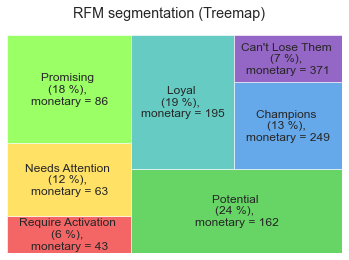

In [18]:
def plot_treemap(df_segments: pd.DataFrame, cluster_col=CLUSTER_COL, pct_col=CLUSTER_PCT, colormap=None):
    """Plot clusters as treemap, showing cluster label, percentage, and MonetaryValue"""
    cluster_id_numeric = (
        cluster_col in df_segments.select_dtypes('number').columns)
    cluster_id_categoric = (
        cluster_col in df_segments.select_dtypes('category').columns)
    if cluster_id_numeric or cluster_id_categoric:
        # print('converting segment labels to string')
        df_segments[cluster_col] = [
            f'seg. {i}' for i in df_segments[cluster_col]]
    df_segment_labels = list(df_segments[cluster_col])
    if colormap is None:
        n = len(df_segments)
        df_segment_colors = sns.color_palette(
            'nipy_spectral_r', n_colors=n).as_hex()
        # treemap requires an inverted colormap, standard colormaps no good
        colormap = dict(zip(df_segment_colors, df_segment_labels))

    df_summary = df_segments[[cluster_col, pct_col, 'MonetaryValue']]

    def row_label(row):
        return (f"{row[cluster_col]} \n({row[pct_col]:.0f} %), "
                + f"\nmonetary = {row['MonetaryValue']:.0f}")
    df_treemap = df_summary.sort_values(by='MonetaryValue')
    df_treemap['text'] = df_treemap.apply(lambda row: row_label(row), axis=1)
    # rfm_summary.loc[:,'text']= rfm_summary_text.values
    squarify.plot(sizes=df_treemap[pct_col],
                  label=df_treemap['text'], alpha=.6,
                  color=colormap)
    plt.axis('off')


plot_treemap(df_rfm_segments.droplevel(1, axis=1).reset_index())
plt.suptitle('RFM segmentation (Treemap)')
to_png()


"RFM_Segmentation_Classique_(3D_plot).png"


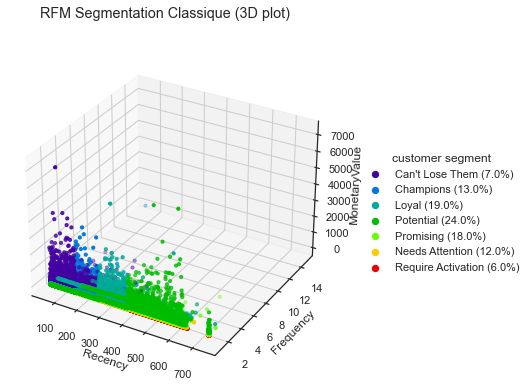

In [19]:
def plot_3d(df: pd.DataFrame, label_col=CLUSTER_COL, segments=None, colors=None):
    """Plot en 3 dimensions après avoir attribué les clusters"""
    if segments is None:
        segments = calc_cluster_order(df)
    if colors is None:
        colors = sns.color_palette(
            'nipy_spectral', n_colors=len(segments)).as_hex()        
    xcol = df.columns[0]
    ycol = df.columns[1]
    zcol = df.columns[2]
    # This import registers the 3D projection, but is otherwise unused.
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    i = 0
    if not (label_col in df.columns):
        # index = label_col
        df = df.copy().reset_index()
    n = float(len(df))
    for segment in segments:
        data_ = df[df[label_col] == segment]
        pourcentage = round(len(data_)/n*100, 0)
        # print(f'{segment} : {data.shape}')
        ax.scatter(data=data_,
                   xs=xcol, ys=ycol, zs=zcol,
                   label=f'{segment} ({pourcentage}%)',
                   s=10,
                   c=colors[i])
        i += 1
    # Titre des axes et titre graphique
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.set_zlabel(zcol)
    plt.legend(title='customer segment', bbox_to_anchor=(
        1.6, 0.5), loc=5, markerscale=2)


plot_3d(df_rfm)
plt.suptitle('RFM Segmentation Classique (3D plot)')
to_png()


La segmentation RFM ne discrimine pas par fréquence


"Segmentation_par_RFM_-_monetary_vs_recency.png"


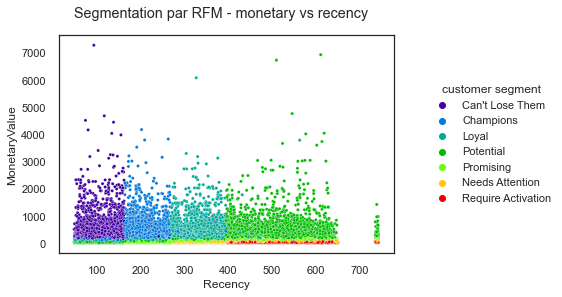

In [20]:
cluster_order = calc_cluster_order(df_rfm)
sns.scatterplot(data=df_rfm, x='Recency', y='MonetaryValue',
                hue=CLUSTER_COL, hue_order=cluster_order, palette='nipy_spectral', s=10)
plt.legend(title='customer segment', bbox_to_anchor=(1.5, 0.5), loc=5)
plt.suptitle('Segmentation par RFM - monetary vs recency')
to_png()


### Conclusions sur essai 1

La segmentation RFM n'est pas très discriminant:

- 97% des clients ont fait une seule commande, donc la fréquence n'influence pas trop le score
- les clients plus récents ont un score plus favorable que les anciens clients, sans justificatif.
- les clients qui ont fait des commandes de bas valeur ne sont pas mis en valeur

---


# 3. Essai 2 - Kmeans clustering avec les variables RFM

Pour comparaison, on peut répéter la segmentation RFM via clustering.

Pour la meilleure performance, il faut que :

- les distributions sont au même échelle,
- idéalement avec des distributions normales pour réduire l'impact des outliers

Cette section investigue l'influence de preprocessing sur les clusters.


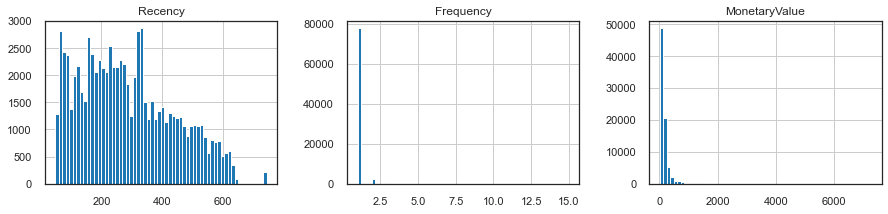

In [21]:
df_clients[FEATURES_RFM].hist(figsize=(15, 3), bins=60, layout=[1, 3])
plt.subplots_adjust()


### Clustering RFM avec MinMaxScaler

Le MinMaxScaler met les distributions au même échelle, mais ça ne résout pas le problème des outliers


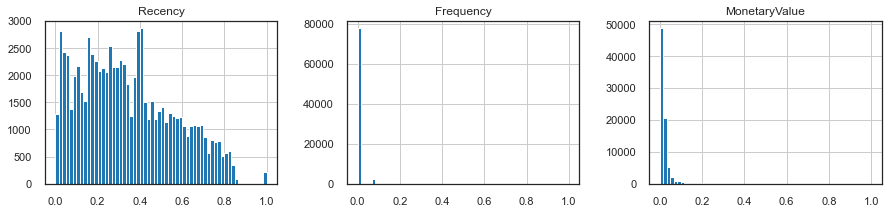

In [22]:
from sklearn.preprocessing import MinMaxScaler

pd.DataFrame(MinMaxScaler().fit_transform(
    df_clients[FEATURES_RFM]), columns=FEATURES_RFM).hist(figsize=(15, 3), bins=60, layout=[1, 3])
plt.subplots_adjust()


{'6': 'Seg. 1', '4': 'Seg. 2', '5': 'Seg. 3', '1': 'Seg. 4', '0': 'Seg. 5', '2': 'Seg. 6', '3': 'Seg. 7'}
"RFM_Segmentation_Kmeans_avec_MinMaxScaler_(3D_plot).png"


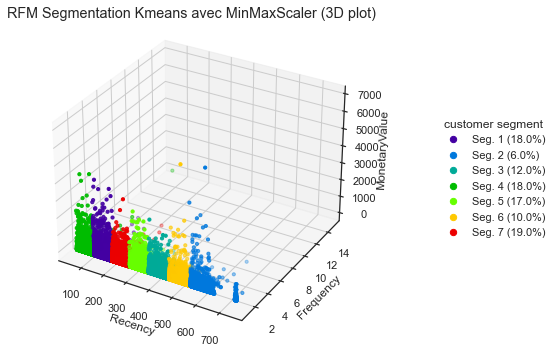

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

def rename_cluster_labels(df):
    """temporary"""
    global CLUSTER_COL,VALUE_COL
    df=df.copy()
    df[CLUSTER_COL]=df[CLUSTER_COL].astype(str)
    old_labels=df.groupby(CLUSTER_COL)[VALUE_COL].mean().sort_values(ascending=False).index.astype(str)
    n=len(old_labels)
    new_labels=[f'Seg. {i}' for i in range(1,n+1)]
    label_map=dict(zip(old_labels,new_labels))
    print(label_map)
    df[CLUSTER_COL]=df[CLUSTER_COL].astype.map(label_map).astype(str)
    return df

def run_fit_cluster_labels(df: pd.DataFrame, features, model):
    """fit model to df[features], and add/replace cluster labels"""
    df = df[features].copy()
    model.fit(df)
    clf: KMeans = model.named_steps['clf']
    df[CLUSTER_COL] = clf.labels_
    df[CLUSTER_COL] = df[CLUSTER_COL].astype(str)
    return df.pipe(rename_clusters)


model_min_max_kmeans = Pipeline(steps=[
    ('preprocessor', MinMaxScaler()),
    ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
])

client_clusters = df_clients.pipe(
    run_fit_cluster_labels, FEATURES_RFM, model_min_max_kmeans)
client_clusters.pipe(plot_3d)

plt.suptitle('RFM Segmentation Kmeans avec MinMaxScaler (3D plot)', y=0.9)
to_png()


Le MinMaxScaler (et StandardScaler) :

- discriminer la plupart des clients qui ont fait plusieurs commandes (cluster id = 6)
- n'arrive pas à discriminer les valeurs monétaires, car les outliers réduit la sensibilité à cette variable.


### Clustering RFM avec Logarithme et StandardScaler


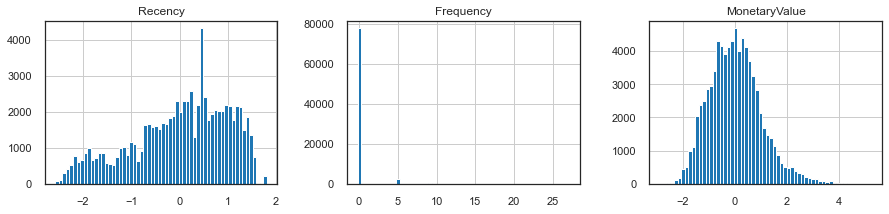

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer

log_scale_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('log', FunctionTransformer(func=np.log1p,
                                inverse_func=np.expm1, validate=False)),
    ('scale', StandardScaler()),
])
pd.DataFrame(log_scale_transformer.fit_transform(
    df_clients[FEATURES_RFM]), columns=FEATURES_RFM).hist(figsize=(15, 3), bins=60, layout=[1, 3])
plt.subplots_adjust()


{'0': 'Seg. 1', '1': 'Seg. 2', '3': 'Seg. 3', '2': 'Seg. 4', '5': 'Seg. 5', '4': 'Seg. 6', '6': 'Seg. 7'}
"Segmentation_RFM_par_Kmeans_(k=7),_log_scale_transformer_(3D_plot).png"


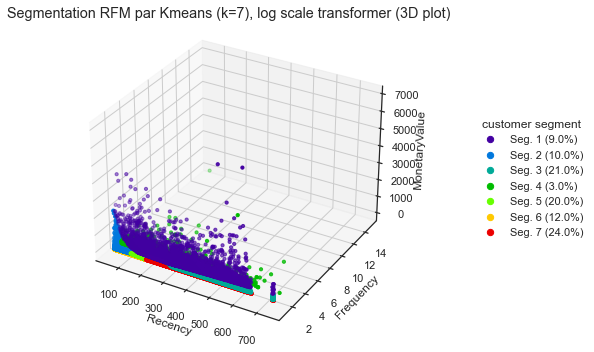

In [162]:
model_logscale_kmeans = Pipeline(steps=[
    ('preprocessor', log_scale_transformer),
    ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
])

client_clusters = df_clients.pipe(
    run_fit_cluster_labels, FEATURES_RFM, model_logscale_kmeans)
client_clusters.pipe(plot_3d)

plt.suptitle(
    'Segmentation RFM par Kmeans (k=7), log scale transformer (3D plot)', y=0.9)
to_png()


"Segmentation_RFM_par_Kmeans_(k=7),_log_scale_transformer.png"


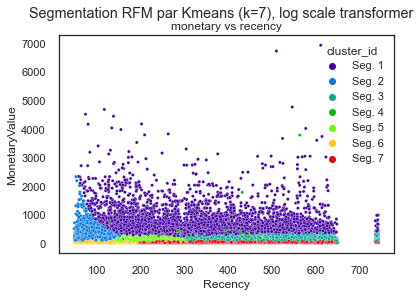

In [163]:
cluster_order = calc_cluster_order(client_clusters)
sns.scatterplot(data=client_clusters, x='Recency',
                y='MonetaryValue', hue=CLUSTER_COL, hue_order=cluster_order, s=10, palette='nipy_spectral')
plt.suptitle('Segmentation RFM par Kmeans (k=7), log scale transformer')
plt.title('monetary vs recency')
to_png()


La transformation log suivi par la mise à la même échelle :

- élimine l'influence d'outliers des valeurs monétaires
- nuance les clients par les trois variables (Récence, Fréquence et Montant moyenne dépensé)
- requiert que toutes les variables ont des distributions asymétriques, avec un skew positive


### Clustering RFM avec QuantileTransformer

L'inconvénient de la transformation log, c'est qu'il exige des valeurs numériques positives et est plus adapté aux distibutions avec un grand skew positive

On essaie un quantile transformer pour transformer les distributions vers une distribution normale

- Cette transformation est non-linéaire et risque de créer une distortion des corrélations entre les variables, mais permet d'utiliser les mesures de distance entre points plus comparables


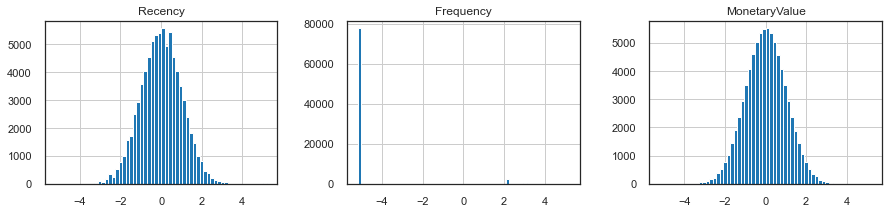

In [27]:
from sklearn.preprocessing import QuantileTransformer

quantile_transformer = QuantileTransformer(
    output_distribution='normal', random_state=RANDOM_SEED)

pd.DataFrame(quantile_transformer.fit_transform(
    df_clients[FEATURES_RFM]), columns=FEATURES_RFM).hist(figsize=(15, 3), bins=60, layout=[1, 3])
plt.subplots_adjust()


{'2': 'Seg. 1', '6': 'Seg. 2', '1': 'Seg. 3', '5': 'Seg. 4', '4': 'Seg. 5', '0': 'Seg. 6', '3': 'Seg. 7'}
"RFM_Segmentation_Kmeans_avec_QuantileTransformer_(3D_plot).png"


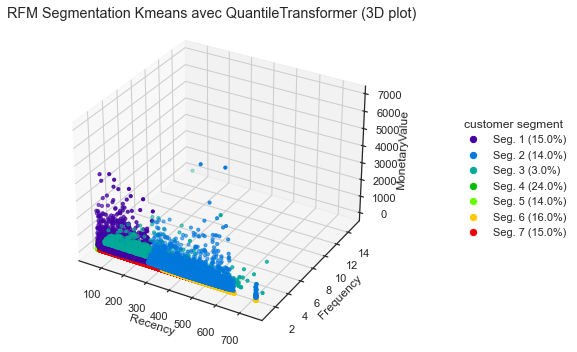

In [164]:
model_quantile_kmeans = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(
        output_distribution='normal', random_state=RANDOM_SEED)),
    ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
])

client_clusters = df_clients.pipe(
    run_fit_cluster_labels, FEATURES_RFM, model_quantile_kmeans)
client_clusters.pipe(plot_3d)
plt.suptitle(
    'RFM Segmentation Kmeans avec QuantileTransformer (3D plot)', y=0.9)
to_png()


"Segmentation_RFM_par_Kmeans_(k=7),_quantile_transformer.png"


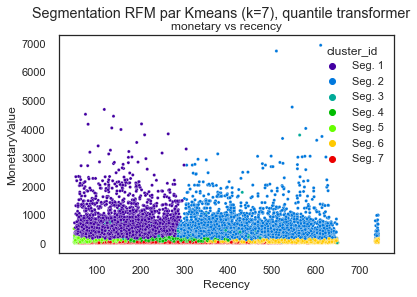

In [165]:
cluster_order = calc_cluster_order(client_clusters)
sns.scatterplot(data=client_clusters, x='Recency',
                y='MonetaryValue', hue=CLUSTER_COL, hue_order=cluster_order, s=10, palette='nipy_spectral')
plt.suptitle('Segmentation RFM par Kmeans (k=7), quantile transformer')
plt.title('monetary vs recency')
to_png()


### Aggregation des clusters


In [166]:
def agg_top(x):
    """return most frequent x"""
    return x if len(x) == 1 else x.value_counts().index[0]


def group_clusters(df: pd.DataFrame, cluster_col=CLUSTER_COL):
    """Aggregate clusters on numeric and categorical columns"""
    df = df.copy()
    df[cluster_col] = df[cluster_col].astype('category')

    # effectif et fréquence des clusters
    df_cluster_sizes = df.groupby(cluster_col).agg(
        cluster_size=(cluster_col, 'count'))
    n = len(df)
    df_cluster_sizes['cluster_pct'] = np.round(
        df_cluster_sizes['cluster_size']/n * 100, 2)
    # df_cluster_size=(df[cluster_col].value_counts(normalize=False)*100).to_frame(name='cluster_size')
    # df_cluster_pct=(df[cluster_col].value_counts(normalize=True)*100).to_frame(name='cluster_pct')

    # moyennes des colonnes numériques
    num_cols = df.select_dtypes('number').columns
    df_cluster_means = df.groupby(cluster_col)[num_cols].mean()
    df_agg = df_cluster_sizes.join(df_cluster_means)

    #
    obj_cols = df.select_dtypes('object').columns
    if len(obj_cols) > 0:
        df_cluster_max = df.groupby(cluster_col)[obj_cols].agg(agg_top)
        df_agg = df_agg.join(df_cluster_max)

    if VALUE_COL in df_agg.columns:
        df_agg = df_agg.sort_values(by=VALUE_COL, ascending=False)
    df_agg = df_agg.reset_index()
    df_agg[cluster_col]=df_agg[cluster_col].astype(str)
    return df_agg


group_clusters(client_clusters)


cluster_id  cluster_size  cluster_pct  Recency  Frequency  MonetaryValue
0     Seg. 1         11613        14.53   160.80       1.00         356.14
1     Seg. 2         11304        14.14   433.74       1.00         326.72
2     Seg. 3          2368         2.96   269.06       2.11         142.85
3     Seg. 4         19298        24.15   267.37       1.00         111.64
4     Seg. 5         11106        13.90    96.44       1.00          88.29
5     Seg. 6         12495        15.63   499.17       1.00          75.07
6     Seg. 7         11736        14.68   252.75       1.00          40.27

"Segments_identifiés_par_segmentation_KMeans_(k=7)_sur_features_RFM.png"


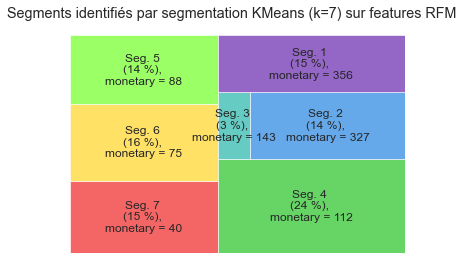

In [167]:
rfm_kmeans = client_clusters.pipe(group_clusters)
plot_treemap(rfm_kmeans)
plt.suptitle(
    'Segments identifiés par segmentation KMeans (k=7) sur features RFM')
to_png()


La transformation avec quantile_transformer produit des segments distribué sur les features


### Visualise les valeurs

#### plotting variables to help explain data

- <https://stackoverflow.com/questions/57340166/how-to-plot-the-pricipal-vectors-of-each-variable-after-performing-pca>
- <https://towardsdatascience.com/principal-components-analysis-plot-for-python-311013a33cd9>


In [168]:
from sklearn.decomposition import PCA
import math

AXIS_RANKS_0_1 = [(0, 1)]
AXIS_RANKS_0_3 = [(0, 1), (2, 3)]
AXIS_RANKS_0_5 = [(0, 1), (2, 3), (4, 5)]


def plot_principal_components(pca_df: pd.DataFrame, pca: PCA,
                              limit=5, axis_ranks=AXIS_RANKS_0_1,
                              plot_points=True,
                              cluster_labels_=None, cluster_order_=None,
                              palette_=CLUSTER_PALETTE, alpha=0.5,
                              plot_features=True, feature_labels=None):
    """
    Plot les données (pca_df) et les vecteurs/circles de corrélations (pca) sur les factorial planes

    Parameters
    ---------
    pca_points : les données transformés dans les composants principales (shape=n_components * n_registres)
    pca_features : le model pca qui fourni les components (shape=n_components * n_features)
    feature_labels: une list/array/pd.Series dans la même ordre que les colonnes utilisés pendant pca.fit(df).
            Si absent, les vecteurs auront les noms 'var 1', 'var 2', etc...
    cluster_labels: une list/array/pd.Series dans la même ordre que les registres df et pca_df
    cluster_order: ordre d'affichage des clusters (permet par exemple d'ordonner par valeur monetaire)
    palette: couleurs pour distinguer les clusters
    """
    n_ranks = len(axis_ranks)
    n_cols = min(n_ranks, 3)
    n_rows = int(math.ceil(n_ranks/n_cols))

    fig: Figure = plt.figure(1, figsize=(n_cols*6, n_rows*6))
    n_ax = 1
    for d1, d2 in axis_ranks:
        # axis_ranks=[(0,1),(2,3),(4,5)] = affiche les 3 premiers plans factoriels (les 6 premières composantes)
        if d2 < pca_df.shape[1]:
            ax = fig.add_subplot(n_rows, n_cols, n_ax)
            n_ax = n_ax+1

            # définition des limites du graphique
            # (xmin, xmax) = ax.get_xlim()
            # (ymin, ymax) = ax.get_ylim()
            # xlim = min(limit, max(abs(xmin), abs(xmax)))
            # ylim = min(limit, max(xlim, abs(ymin), abs(ymax)))
            xlim = limit
            ylim = limit
            ax.set_xlim(-xlim, xlim)
            ax.set_ylim(-ylim, ylim)
            
            if plot_points:
                # plot des points
                sns.scatterplot(x=pca_df[:, d1], y=pca_df[:, d2],
                                hue=cluster_labels_,
                                hue_order=cluster_order_,
                                palette=palette_,
                                s=10, alpha=alpha, ax=ax)
                if not cluster_labels_ is None:
                    plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5)



            if plot_features:
                # affichage du cercle
                scale = 0.8  # pourcent de largeur pour le cercle
                arrow_scale = max(xlim, ylim)*scale  # limit/1.2
                quiver_scale = 2/scale
                text_scale = arrow_scale*1.15
                circle = plt.Circle((0, 0), arrow_scale,
                                    facecolor='none', edgecolor='b')
                plt.gca().add_artist(circle)

                coeff = pca.components_.T
                n = len(coeff)
                for i in range(n):
                    x_ = coeff[i, d1]
                    y_ = coeff[i, d2]
                    plt.quiver(0, 0, x_, y_, scale=quiver_scale,
                            ls='-', color='black', lw=2, alpha=0.5)
                    # plt.arrow(0, 0, x_*arrow_scale, y_* arrow_scale,
                    # ls='-', color='black', lw=2, alpha=0.5)
                    if feature_labels is None:
                        label = "Var"+str(i+1)
                    else:
                        label = feature_labels[i]
                    plt.text(x_ * text_scale, y_ * text_scale,
                            label, color='black', ha='center', va='center', alpha=0.7)

            # affichage des lignes horizontales et verticales
            plt.plot([-xlim, xlim], [0, 0], color='grey', lw=1, ls='--')
            plt.plot([0, 0], [-ylim, ylim], color='grey', lw=1, ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            explained = pca.explained_variance_ratio_ * 100
            cumvar = explained[d1]+explained[d2]
            pc1 = f'PC{(d1+1):.0f}'
            pc2 = f'PC{(d2+1):.0f}'
            plt.ylabel(f'{pc1} ({explained[d1]:.1f}%)')
            plt.xlabel(f'{pc2} ({explained[d2]:.1f}%)')
            plt.title(
                f'Cumulative Prop. Variance Explained ({pc1}+{pc2}) = {cumvar:.1f}%')




pca feature labels : ['Recency', 'Frequency', 'MonetaryValue']
"KMeans_Clusters_sur_features_RFM.png"


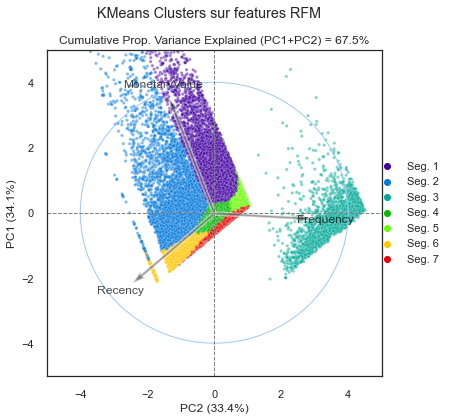

In [169]:

def plot_clusters_on_pca(df: pd.DataFrame, preprocessor=StandardScaler(),
                        plot_points=True, plot_features=True,
                         cluster_col=CLUSTER_COL, cluster_order=None, palette=CLUSTER_PALETTE,
                         alpha=0.5, limit=5, axis_ranks=AXIS_RANKS_0_1):
    """
    Visualise les résultats de clustering. Les labels sont fournis :
    - soit dans une colonne de la data ; ou
    - dans une série, séparément de la data
    Parameters
    ----------
    plot_points  afficher les points (par défaut, True)
    plot features  afficher le cercle de correlations (par défaut, True)
    """
    cluster_labels = None
    df = df.copy()
    if cluster_col in df.columns:
        df[cluster_col] = df[cluster_col].astype('category')
        cluster_labels = df[cluster_col]

    df = df.select_dtypes('number')
    feature_labels = list(df.columns)
    print(f'pca feature labels : {feature_labels}')

    # si le dataframe de clusters est fourni sans preprocessing, il faut au moins appliquer StandardScalar
    # pour d'autres visualisations, passer preprocess le clusters
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=len(df.columns)))
    ])

    pca_df = model.fit_transform(df)
    pca = model.named_steps['pca']

    if palette is None:
        if not cluster_labels is None:
            segments = list(pd.Series(cluster_labels).unique())
            palette = sns.color_palette(
                'nipy_spectral', n_colors=len(segments))

    if cluster_order is None:
        cluster_order = calc_cluster_order(df, cluster_col)

    plot_principal_components(pca_df, pca, 
                              plot_points=plot_points, plot_features=plot_features,
                              feature_labels=feature_labels,
                              cluster_labels_=cluster_labels, cluster_order_=cluster_order,
                              palette_=palette, alpha=alpha, limit=limit, axis_ranks=axis_ranks)
    return None


plot_clusters_on_pca(client_clusters)
plt.suptitle('KMeans Clusters sur features RFM')
to_png()


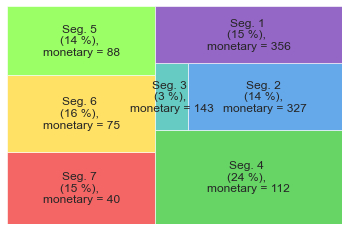

In [170]:

plot_treemap(group_clusters(client_clusters))


### Conclusion sur essai 2

La segmentation RFM par clustering KMeans (k= 7 segments) produit des résultats similaires à la segmentation RFM classique :

- il faut mettre les variables à la même échelle
- il faut éliminer les outliers par transformation des variables (ou les traites à part)
- Il y a 6 clusters sur récence et valeur monétaire.
- Il y un nouveau cluster (label = 2) qui represent le 3% de clients qui ont fait plus d'une commande

On n'a toujours beaucoup d'information pour aider à cibler nos clients.

---


# 4. Essai 3 - Clustering KMeans sur d'autres indicateurs

L'analyse des données a fourni d'autres indicateurs de nos clients


In [35]:
print(list(df_clients.columns))


['customer_unique_id', 'dernier_achat', 'Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score', 'delivery_time', 'delivery_delay', 'distance_customer_seller', 'freight_percent', 'payment_mode', 'favourite_category', 'customer_state', 'favourite_seller_state', 'time_of_day', 'weekday', 'products_per_order']


Text(0.5, 0.98, 'Distributions des indicateurs client')

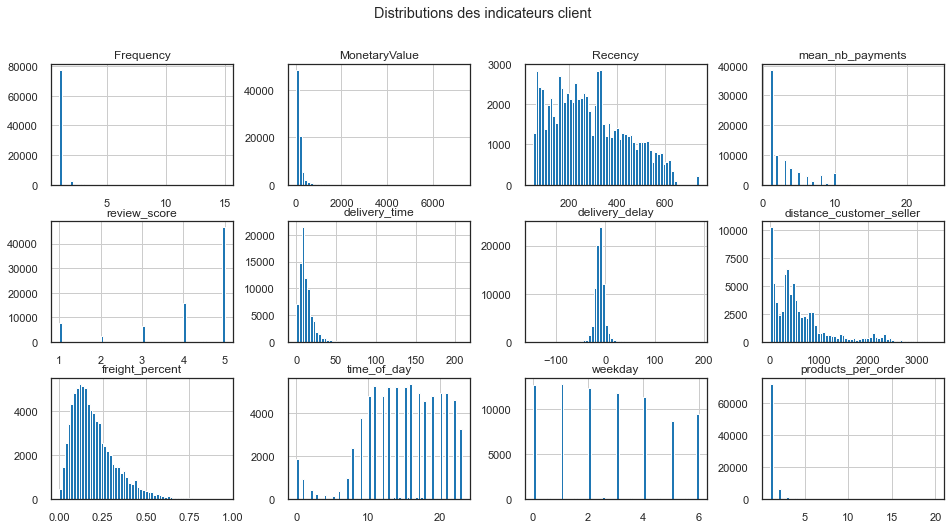

In [36]:
df_clients.hist(figsize=(16, 8), bins=60, layout=[3, 4])
plt.suptitle('Distributions des indicateurs client')


### Approche pour clustering

Pour clustering KMeans, il faut

1. réduire l'influence des outliers
1. mettre les variables à la même échelle
1. choisir les features qui explique le plus de variance


## 4.1 Réduction de l'influence des outliers

#### Detection d'anomalies avec Isolation Forest

On suppose que 0.5% des clients ne sont pas representative de chaque segment de clients :

Par exemple :

- des très haut valeurs monétaires
- des très fréquents acheteurs
- des livraisons extrêmement en retard
- des paiements en 24 fois
- des frappes erronées

Ces données peuvent avoir une influence trop fort sur les clusters.
On va les identifier, et si besoin, les éliminer.

- <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html>
- <https://practicaldatascience.co.uk/machine-learning/how-to-use-the-isolation-forest-model-for-outlier-detection>
- <https://machinelearningmastery.com/anomaly-detection-with-isolation-forest-and-kernel-density-estimation/>


Text(0.5, 0.98, 'Anomalies détectés par IsolationForest (1%)')

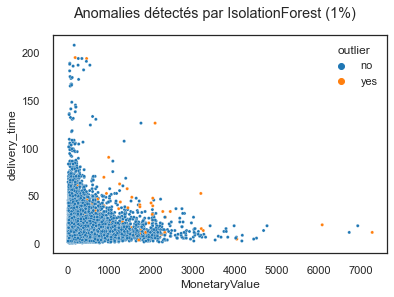

In [37]:
from sklearn.ensemble import IsolationForest


def find_outliers(df: pd.DataFrame, num_cols=None, alpha=0.001, random_state=RANDOM_SEED):
    """Methode non-optimisé pour éliminer des points isolés 
    pour réduire l'influence sur le clustering"""
    if (alpha <= 0) or (alpha > 0.03):
        return df
    df = df.copy()
    if num_cols is None:
        num_cols = df.select_dtypes('number').columns
    model = IsolationForest(contamination=alpha, random_state=random_state)
    model.fit(df[num_cols].values)
    # outliers=model.predict(df[num_cols]<0)
    # enregistre comme une colonne non numérique
    df['outlier'] = np.where(model.predict(
        df[num_cols].values) < 0, 'yes', 'no')
    return df


df_clients = find_outliers(df_clients)

sns.scatterplot(data=df_clients, x='MonetaryValue',
                y='delivery_time', hue='outlier', palette='tab10', s=10)

plt.suptitle('Anomalies détectés par IsolationForest (1%)')


On regarde les outliers sur les 2 premiers composants principaux


pca feature labels : ['Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score', 'delivery_time', 'delivery_delay', 'distance_customer_seller', 'freight_percent', 'time_of_day', 'weekday', 'products_per_order']
"Visualisation_d'outliers_sur_les_composants_principales.png"


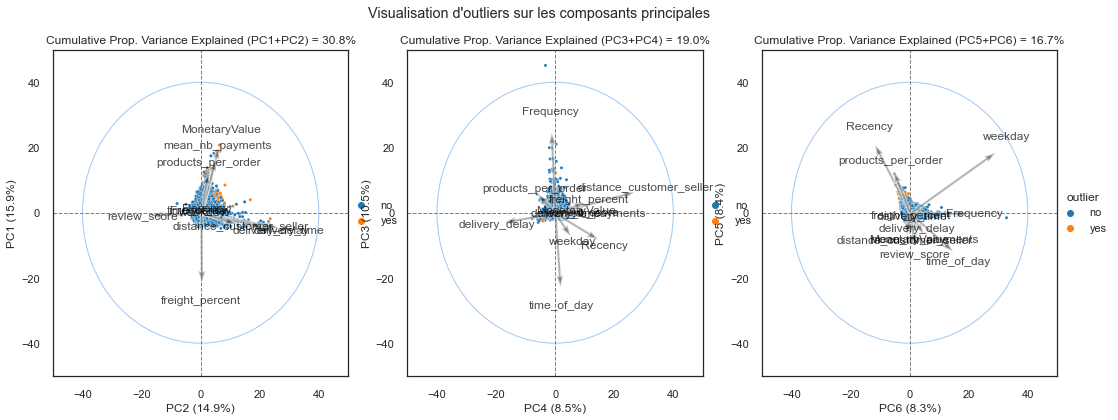

In [38]:

plot_clusters_on_pca(df_clients, cluster_col='outlier',
                     palette='tab10', limit=50, alpha=1, axis_ranks=AXIS_RANKS_0_5)
plt.legend(title='outlier', bbox_to_anchor=(1.2, 0.5), loc=5)
plt.suptitle("Visualisation d'outliers sur les composants principales")
to_png()


In [39]:
def drop_outliers(df):
    """
    Supprime les lignes qui contient valeur 'yes' dans colonne 'outlier',
    et supprime colonne outlier
    """
    if 'outlier' in df.columns:
        return df[~(df['outlier'] == 'yes')].drop('outlier', axis=1)
    return df


pca feature labels : ['Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score', 'delivery_time', 'delivery_delay', 'distance_customer_seller', 'freight_percent', 'time_of_day', 'weekday', 'products_per_order']


Text(0.5, 0.98, 'Composants principaux après élimination des points isolés (0.5%)')

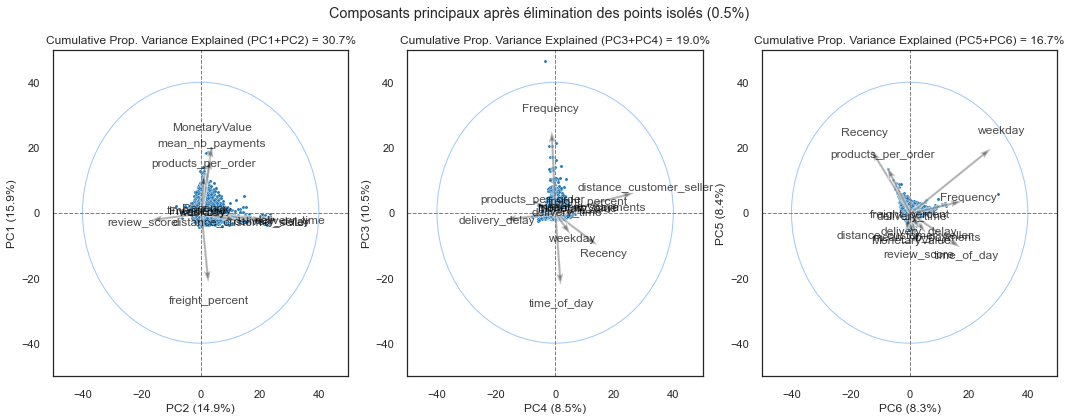

In [40]:
(plot_clusters_on_pca(
    df_clients.pipe(drop_outliers).select_dtypes('number'),
    limit=50, alpha=1, axis_ranks=AXIS_RANKS_0_5))
plt.suptitle('Composants principaux après élimination des points isolés (0.5%)')


In [41]:
df_clients = df_clients.pipe(drop_outliers)


### Transformation pour éliminer l'asymétrie (skew)

Les distributions asymétriques et outliers ont l'effet de réduire l'influence d'un variable, car ils font que la mise à l'échelle font que la plupart des données sont très proches (distance entre clusters dévient trop pétit pour ce variable)

On va essayer plusieurs transforms pour éliminer le skew.


In [42]:
def transform_skew(df: pd.DataFrame, cols=None, boxcox=True):
    """Test l'effet de plusieurs transformations sur le skew de chaque colonne"""
    if cols is None:
        cols = df.select_dtypes('number').columns
    x_transforms = df[cols].skew().to_frame(name='feature.skew()')
    x_transforms['square'] = np.power(df[cols], 2).skew()
    positive_cols = []
    for col in cols:
        if df[col].min() >= 0:
            positive_cols.append(col)
    x_transforms['sqrt'] = np.sqrt(df[positive_cols]).skew()
    x_transforms['log'] = np.log1p(df[positive_cols]).skew()
    x_transforms['quantile'] = pd.DataFrame(
        quantile_transformer.fit_transform(df[cols]), columns=cols).skew()
    if boxcox:
        boxcox_df = pd.DataFrame()
        for col in positive_cols:
            boxcox_df[col], lambda_ = scipy.stats.boxcox(df[col]+0.01)
        x_transforms['box-cox'] = boxcox_df.skew()
    return x_transforms


print('skew pour les variables après divers transformations')
abs(transform_skew(df_clients)
    ).style.background_gradient(axis=1).highlight_min(axis=1)


skew pour les variables après divers transformations


In [43]:

print('skew pour les variables après divers transformations')
abs(transform_skew(
    df_clients.pipe(drop_outliers))
    ).style.background_gradient(axis=1).highlight_min(axis=1)


skew pour les variables après divers transformations


La transformation quantile est la plus efficace pour réduire l'influence des outliers.


#### Quantile preprocessor

La transformation quantile est efficace pour :

- réduit le skew (élimination des outliers)
- mettre les variables à la même échelle

Il permet de comparer les distances entre les points sur plusieurs dimensions.

Néanmoins, c'est plus difficile d'interpreter, car c'est une transformation très non-linéaire.


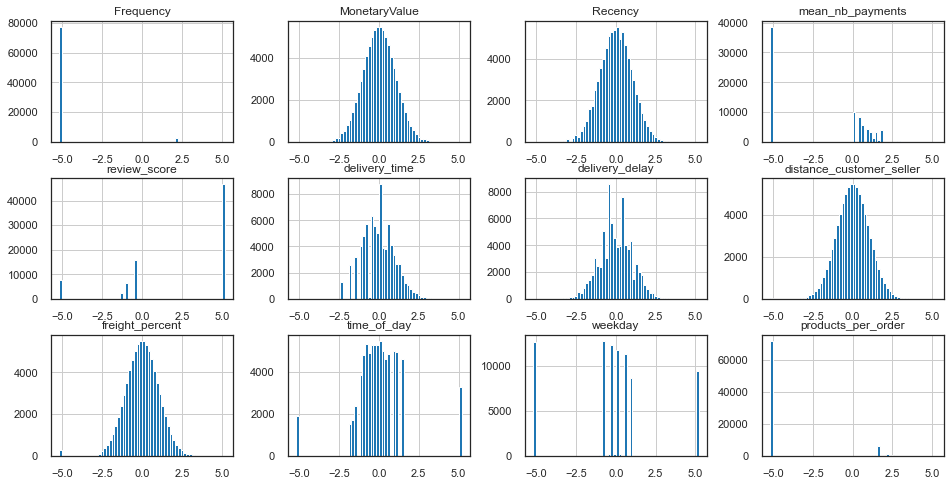

In [44]:
numeric_cols = df_clients.select_dtypes('number').columns

quantile_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('quantile', QuantileTransformer(
        output_distribution='normal', random_state=RANDOM_SEED)),
])

clients_quantiled = pd.DataFrame(
    data=quantile_transformer.fit_transform(df_clients[numeric_cols]),
    columns=numeric_cols
)

clients_quantiled.hist(figsize=(16, 8), bins=60, layout=[3, 4])
plt.subplots_adjust()


#### Custom preprocessor

Un alternative sera de transformer chaque variable individuellement:

- standard scaler : feature.skew < 0.5 et les variables negative
  - (delivery_delay, review_score, recency)
- sqrt + scaler : (sqrt(feature)).skew < 0.5
  - (distance_customer_seller, freight_percent)
- log + scaler : toutes les autres variables

C'est plus compliqué à mettre en œuvre :


In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


def make_custom_preprocessor(data):
    """Créer un preprocessor basé sur propriétés des colonnes
    mélange de log, scale, square_root et catégorique
    """
    def split_features(df):
        """Diviser le processing des features basé sur leur dtype, skew"""
        num_cols = df.select_dtypes('number').columns.tolist()

        # (abs(feature.skew)) < 0.5) ou (feature < 0).any()
        feat_skew = df[num_cols].skew()
        scale_cols = feat_skew[feat_skew < 0.5].index.tolist()

        negative_cols = df[num_cols].columns[(df[num_cols] < 0).any()]
        scale_cols = [*scale_cols, *negative_cols]

        positive_cols = df[num_cols].columns[~(df[num_cols] < 0).any()]

        sqrt_skew = np.sqrt(df[positive_cols]).skew()
        sqrt_cols = list(
            set(sqrt_skew[sqrt_skew < 0.5].index.tolist()) - set(scale_cols))

        log_cols = list(set(positive_cols)-(set(scale_cols+sqrt_cols)))

        categ_cols = df.select_dtypes(exclude='number').columns.tolist()
        category_cols = []
        for col in categ_cols:
            if df[col].nunique() < 22:
                category_cols.append(col)
        return scale_cols, log_cols, sqrt_cols, category_cols

    scale_features, log_features, sqrt_features, category_features = split_features(
        data)

    # (abs(feature.skew)) < 0.5) ou (feature < 0).any()
    scale_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scale', StandardScaler())
    ])

    # (abs(sqrt(feature).skew) < 0.5)
    sqrt_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', FunctionTransformer(func=np.sqrt,
         inverse_func=np.square, validate=False)),
        ('scale', StandardScaler())
    ])

    # les autres variables numériques
    log_scale_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('log', FunctionTransformer(func=np.log1p,
         inverse_func=np.expm1, validate=False)),
        ('scale', StandardScaler()),
    ])

    category_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('simple_scale', scale_transformer, scale_features),
            ('log_scale', log_scale_pipeline, log_features),
            ('sqrt_scale', sqrt_transformer, sqrt_features),
            ('cat', category_transformer, category_features)
        ],
        remainder='drop'
    )

    return preprocessor


custom_preprocessor = make_custom_preprocessor(df_clients.select_dtypes('number'))

custom_pipeline = Pipeline(steps=[('preprocessor', custom_preprocessor)])
custom_pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('simple_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Recency', 'review_score',
                                                   'time_of_day', 'weekday',
                                                   'delivery_delay']),
                                                 ('log_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer(func=<ufun...
                                                 ('sqrt_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                                       inverse_func=<ufunc 'square'>)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['freight_percent']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [])]))])

In [46]:
def get_features_out(df: pd.DataFrame, pipe):
    """
    Get column names after preprocessing

    assumes (requires preprocessors with following structure):
    - all named transformers, if present, are in same order as listed below
    - if preprocessor has other transformers, add to list below
    - only final transformer (named 'cat') adds columns, via an encoder step named 'ohe'
    - if imputer is used, it does not add indicator columns
    """

    def get_features_in_(trans: ColumnTransformer, name=None):
        try:
            features = list(trans.named_transformers_[name].feature_names_in_)
        except:
            # named transformer doesn't exist in pipeline, return empty list
            features = []
        return features

    pipe.fit(df)
    if hasattr(pipe, 'named_steps'):
        trans: ColumnTransformer = pipe.named_steps['preprocessor']
    else:
        trans = pipe
    # SimpleImputer, FunctionTransformer, StandardScalar do not implement get_feature_names_out

    # Get feature names of numeric columns
    num_features = get_features_in_(trans, 'num')
    scale_features = get_features_in_(trans, 'simple_scale')
    log_features = get_features_in_(trans, 'log_scale')
    sqrt_features = get_features_in_(trans, 'sqrt_scale')
    try:
        cat_encoder = trans.named_transformers_['cat']
        ohe = cat_encoder.named_steps['ohe']
        category_features = list(
            ohe.get_feature_names_out(cat_encoder.feature_names_in_))
    except:
        category_features = []
    features_out_ = (num_features+scale_features + log_features
                     + sqrt_features + category_features)
    return features_out_


# check
features_in = list(df_clients.select_dtypes('number').columns)
features_out = get_features_out(
    df_clients[features_in], pipe=make_custom_preprocessor(df_clients[features_in]))
print(f'features_in : {features_in}')
print(f'features_out : {features_out}')


features_in : ['Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score', 'delivery_time', 'delivery_delay', 'distance_customer_seller', 'freight_percent', 'time_of_day', 'weekday', 'products_per_order']
features_out : ['Recency', 'review_score', 'time_of_day', 'weekday', 'delivery_delay', 'Frequency', 'MonetaryValue', 'mean_nb_payments', 'distance_customer_seller', 'delivery_time', 'products_per_order', 'freight_percent']


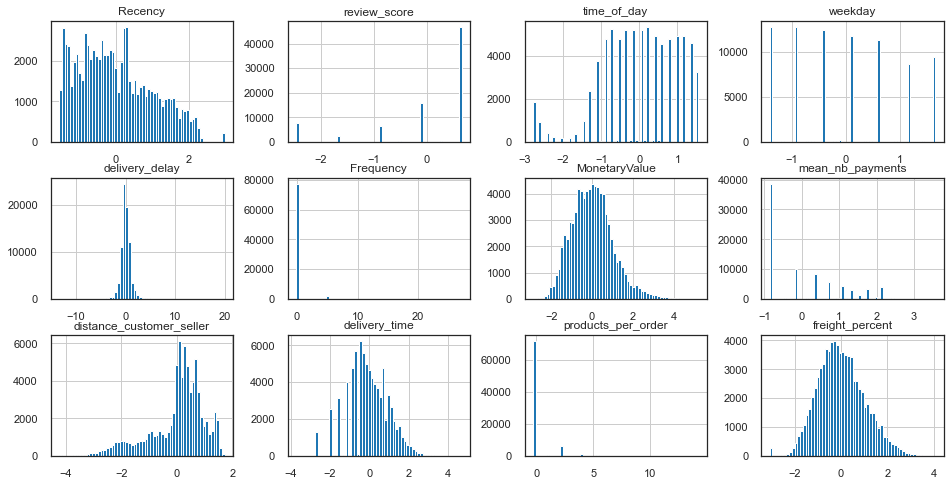

In [47]:
clients_custom_scaled = pd.DataFrame(
    data=custom_pipeline.fit_transform(df_clients[features_in]),
    columns=features_out
)

clients_custom_scaled.hist(figsize=(16, 8), bins=60, layout=[3, 4])
plt.subplots_adjust()


## 4.2 Feature selection par PCA

On peut utiliser PCA pour identifier les variables qui explique le plus de variance entre les points


[ 15.9  30.7  41.3  49.8  58.2  66.5  74.6  82.6  88.8  94.2  98.2 100. ]
[ 17.6  32.9  43.9  52.4  60.8  69.1  77.3  85.   91.3  96.7  98.7 100. ]
[ 17.1  31.9  43.   51.8  60.3  68.6  76.8  84.3  91.   96.7  98.7 100. ]
"pca_var_explained_scree_plot.png"


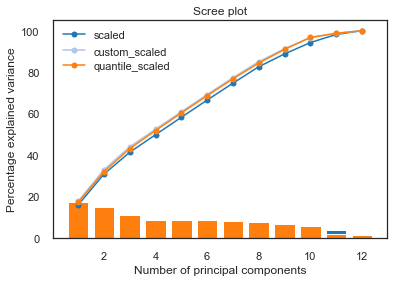

In [48]:
from matplotlib.ticker import MaxNLocator


def display_scree_plot(pca_: PCA, label: str = None):
    """
    Display a scree plot with cumulative explained variance.
    Parameters
    ----------
    pca_    fitted PCA decomposition
    label   label for legend of the plot if comparing scree plots

    Returns
    -------
    None
    """
    ### """Display a scree plot for the pca"""
    scree_ = pca_.explained_variance_ratio_ * 100
    print(np.round(np.cumsum(scree_), 1))
    plt.bar(np.arange(len(scree_)) + 1, scree_,)
    plt.plot(np.arange(len(scree_)) + 1,
             scree_.cumsum(), marker='o', label=label)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Scree Plot of PCA: Component Eigenvalues')

    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")


def run_pca(df):
    """shortcut to run a standardscaler, pca model"""
    model = Pipeline(steps=[
        ('preprocessor', StandardScaler()),
        ('pca', PCA(n_components=len(df.columns), random_state=RANDOM_SEED))
    ])

    pca_df = model.fit_transform(df)
    pca = model.named_steps['pca']
    return pca, pca_df


pca_scale, _ = run_pca(df_clients.select_dtypes('number'))

display_scree_plot(pca_scale, label='scaled')
pca_custom, _ = run_pca(clients_custom_scaled)
display_scree_plot(pca_custom, label='custom_scaled')
pca_quantile, _ = run_pca(clients_quantiled)
display_scree_plot(pca_quantile, label='quantile_scaled')
plt.legend()
to_png(f'pca_var_explained_scree_plot')


Les transformations custom n'améliore pas significativement la variance expliquée par les composants principaux.

Pour simplicité, on utilisera Quantile Transformer pour transformer les variables, sachant que les clusters seront différents avec une autre preprocessor

#### Vérification de manque de corrélation (linéaire) entre les variables apres transformation


"Pearson_correlations_entre_les_variables_numériques.png"


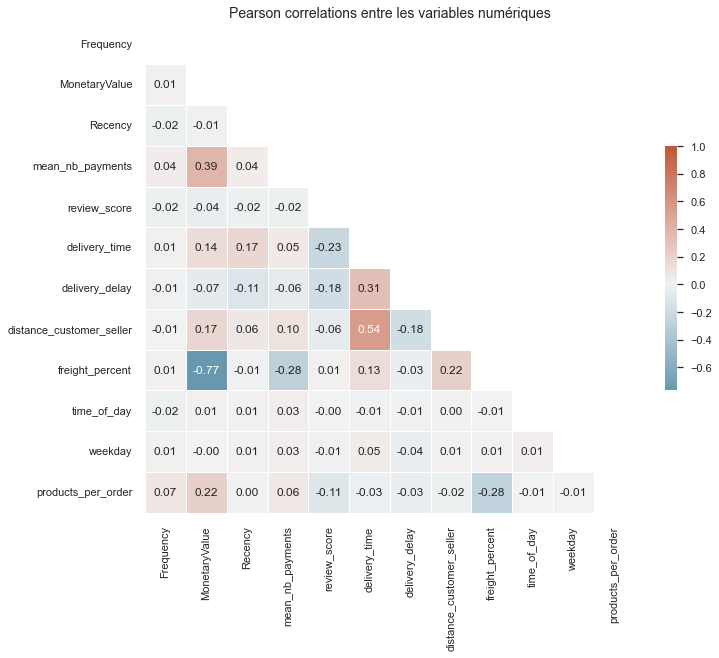

In [49]:
def plot_correlation_heatmap(df: pd.DataFrame, method_corr='pearson'):
    """
    Plot un heatmap des correlations entre variables numériques
    Parameters
    ----------
    df
    method_corr

    Returns
    -------
    """

    corr_tab = df.select_dtypes('number').corr(method=method_corr)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_tab, dtype=bool))

    # Set up the matplotlib figure
    plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_tab, annot=True, fmt='.2f', mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


clients_quantiled.pipe(plot_correlation_heatmap, method_corr='spearman')
plt.title(f'Pearson correlations entre les variables numériques', size=14)
to_png()


pca feature labels : ['Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score', 'delivery_time', 'delivery_delay', 'distance_customer_seller', 'freight_percent', 'time_of_day', 'weekday', 'products_per_order']
"PCA_après_Quantile_Transformation.png"


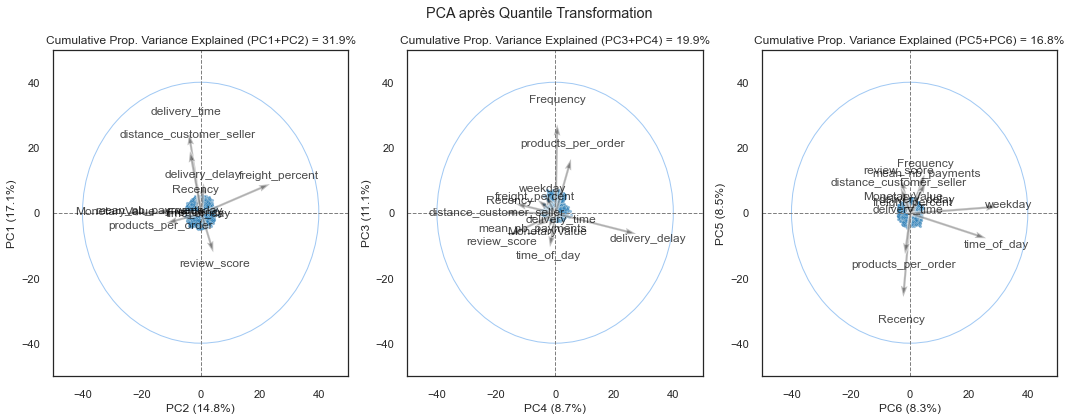

In [50]:
plot_clusters_on_pca(clients_quantiled,
                     axis_ranks=[(0, 1), (2, 3), (4, 5)],  limit=50)
plt.suptitle('PCA après Quantile Transformation')
to_png()


### Réduction des dimensions


Le premier 6 composantes principales explique 70% de la variance

- on regard les loadings sur ces 6 composants


#### Loadings des composants principaux

Les loadings indique la contribution de chaque variable a chaque composant principal :

- Positive loadings indicate a positively correlation
- Negative loadings indicate a negative correlation.

- <http://strata.uga.edu/8370/lecturenotes/principalComponents.html>
- <https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html>


In [51]:
def calc_loadings(df: pd.DataFrame, n_components=6) -> pd.DataFrame:
    """Calculate PCA loadings pour le colonnes numériques d'un dataframe
       après scale des colonnes
    """
    df = df.select_dtypes('number').copy()
    n_components = min(n_components, len(df.columns))
    model = Pipeline(steps=[
        ('preprocessor', StandardScaler()),
        ('pca', PCA(n_components=n_components, random_state=RANDOM_SEED))
    ])

    model.fit(df)
    pca = model.named_steps['pca']
    loadings = pd.DataFrame(
        pca.components_.T * np.sqrt(pca.explained_variance_),
        index=clients_quantiled.columns,
        columns=[f'PC{i}' for i in range(1, pca.components_.shape[0]+1)])

    # print(np.square(loadings).sum(axis=1))
    return loadings


loadings = calc_loadings(clients_quantiled)
# loadings.iloc[:, :6].sort_values(
loadings.sort_values(
    by='PC1').style.background_gradient(cmap='coolwarm', axis=None)


On voit que Frequency (PC4) et MonetaryValue (PC1) ont des correlations forts dans ces composants.
Recency semble moins intéressant (PC6)

Les loadings indique qu'il peut être intéressant d'ajouter au clustering :

- review_score (PC2 et PC3)
- mean_nb_payments (PC1, PC3, PC4)
- delivery_delay (PC2 et PC3)


### 4.3 Selection de 5 indicateurs pour segmentation client

En plus de RFM, on va essayer d'ajouter des variables qui séparent les clusters

- Review Score
- products_per_order


In [52]:
FEATURES_3 = ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments',
              'delivery_delay']
FEATURES_4 = ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments',
              'products_per_order']
FEATURES_5 = ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments',
              'Recency']
FEATURES_6 = ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments',
              'products_per_order', 'Recency']              


#### PCA visualisation sur **Features 3**  

pca feature labels : ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'delivery_delay']
"PCA_(features_3)_après_Quantile_Transformation.png"


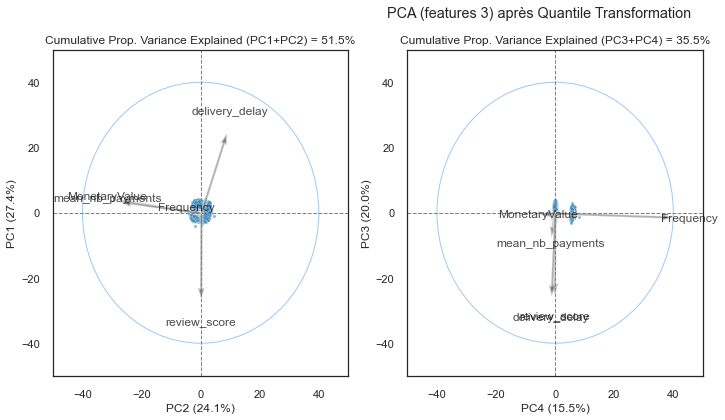

In [53]:
plot_clusters_on_pca(clients_quantiled[FEATURES_3], axis_ranks=[(
    0, 1), (2, 3), (4, 5)],  limit=50)
plt.suptitle('PCA (features 3) après Quantile Transformation')
to_png()


#### PCA visualisation sur **Features 4**  

pca feature labels : ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'products_per_order']
"PCA_(features_4)_après_Quantile_Transformation.png"


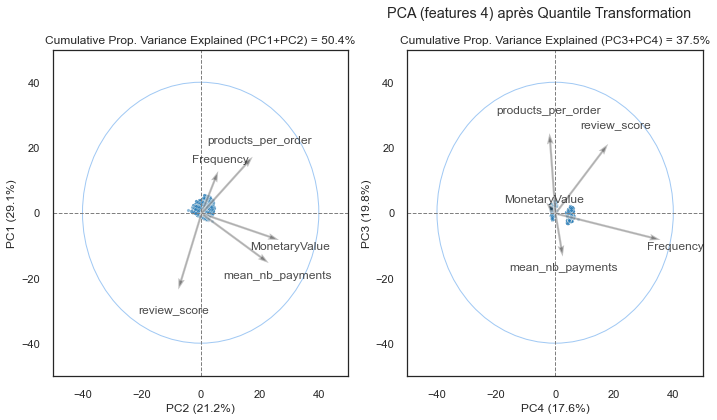

In [54]:
plot_clusters_on_pca(clients_quantiled[FEATURES_4], axis_ranks=[(
    0, 1), (2, 3), (4, 5)],  limit=50)
plt.suptitle('PCA (features 4) après Quantile Transformation')
to_png()


#### PCA visualisation sur **Features 5**  

pca feature labels : ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'Recency']
"PCA_(features_5)_après_Quantile_Transformation.png"


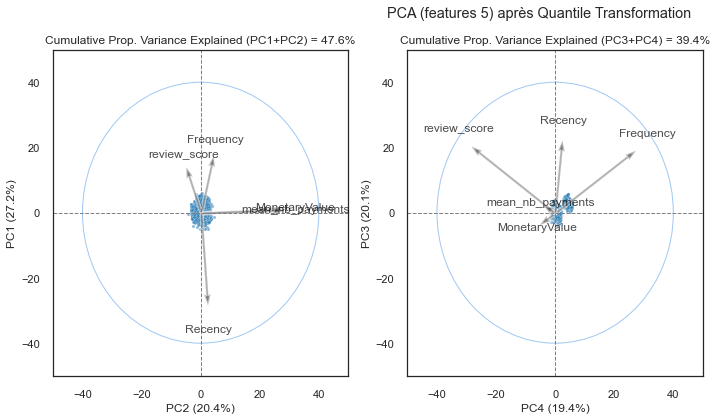

In [55]:
plot_clusters_on_pca(clients_quantiled[FEATURES_5], axis_ranks=[(
    0, 1), (2, 3), (4, 5)],  limit=50)
plt.suptitle('PCA (features 5) après Quantile Transformation')
to_png()


pca feature labels : ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'products_per_order', 'Recency']
"PCA_(features_6)_après_Quantile_Transformation.png"


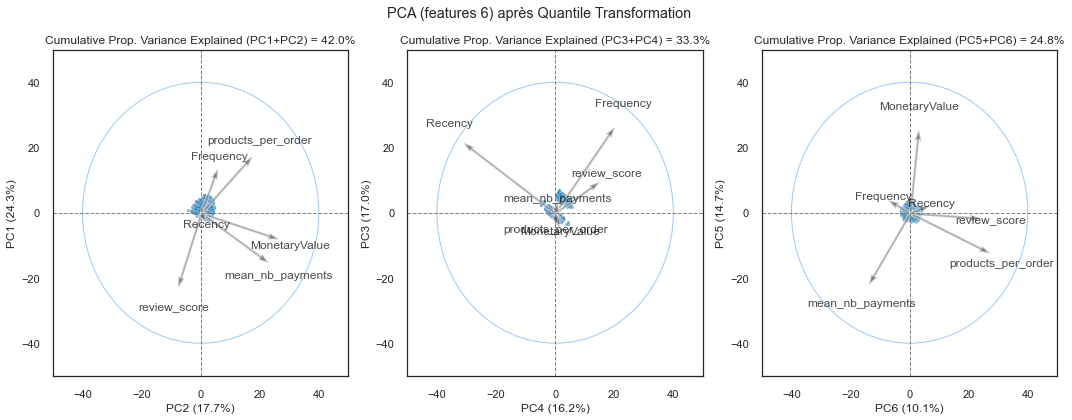

In [56]:
plot_clusters_on_pca(clients_quantiled[FEATURES_6], axis_ranks=[(
    0, 1), (2, 3), (4, 5)],  limit=50)
plt.suptitle('PCA (features 6) après Quantile Transformation')
to_png()


## 4.3 Métriques de performance de clustering

Pour évaluer le meilleur fit des clusters, on évaluera :

- **Distortion score** (inertia) : moyenne de la somme des **erreurs** (carrés) dans chaque cluster - chercher la coude
- **Davies-Bouldin score** : mesure de **forme** (homogénéité et séparation des clusters) - à **minimiser**
- **Calinski-Harabasz score** : distance intra cluster vs nearest cluster - à **maximiser**, ou chercher la coude de maximisation
- **Silhouette score** : une mesure de **cohérence** (appartenance à un cluster) - à **maximiser**

Le métrique par défaut de Kmeans et le distortion score

La **stabilité des clusters** est aussi un facteur à considérer dans le choix du meilleur cluster :

- soit par cross-validation sur des sous-ensembles de données
- soit par analyse de l'évolution des clusters dans le temps

La simulation et mesure de la stabilité des clusters prend beaucoup de temps de calcul et sera évalué dans [une autre notebook](./P5_03_simulation.ipynb)


### 4.3.1 Distortion scores

Le **distortion score** (inertia) est le somme des erreurs carrées dedans chaque cluster (_within Cluster SSE_)

On cherche l'optimal nombre de clusters qui réduit cette erreur, sans avoir

- trop de clusters - difficile d'interpreter
- des clusters qui se mélange (bas scores de Davies-Bouldin/ Silhouette)

Le choix d'optimal k est normalement fait avec **la méthode de coude** (Elbow method) - on choisit la valeur de k avec le plus grand angle entre les points


### 4.3.2 Meilleur forme des clusters (Calinski-Harabasz Score / Davies Bouldin Score)

#### Calinski-Harabasz score

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

- On cherche une valeur le plus haut possible (**la méthode de coude**)
- si la ligne de descent n'a pas de coude, il n'y a pas une raison de préférer une valeur de k sur une autre valeur de k

Références

- <https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index>
- <https://stats.stackexchange.com/questions/52838/what-is-an-acceptable-value-of-the-calinski-harabasz-ch-criterion>


### 4.3.3 Meilleure cohérence des clusters (Silhouette Score)

- Les valeurs proches de 1 indique que les clusters sont denses est séparés
- Les valeurs proches de zero indique que les clusters se mélange
- Les valeurs moins de zero indique que les points peuvent être dans le mauvais cluster

Références:

- <https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html>
- <https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html>
- <https://towardsdatascience.com/are-you-solving-ml-clustering-problems-using-k-means-68fb4efa5469>


Utilisation de la bibliothèque 'yellowbrick' pour faciliter la visualisation

**Inconvenients de KElbowVisualizer**

- difficil de visualiser plus d'un metric à la fois
- on ne peut pas changer facilement les axes, le titre, ...
- seulement indique la coude, mais plusieurs metriques on cherche le max ou min


"Yellowbrick_Silhouette_scores_visualisation.png"


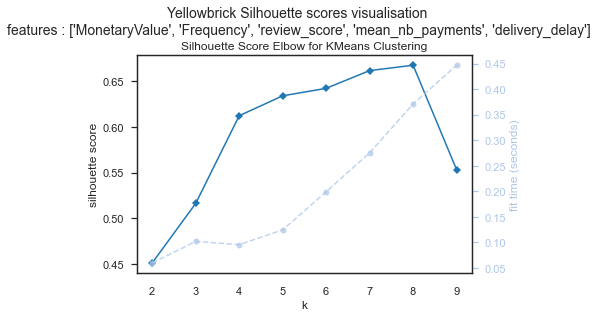

In [57]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model_elbow_vis = Pipeline(steps=[
    ('preprocessor', quantile_transformer),
    ('visualizer', KElbowVisualizer(
        KMeans(random_state=RANDOM_SEED), k=(2, 10), metric='silhouette', locate_elbow=False))
])
# avec 100,000 points, chaque silhouette score prend 2 minutes à calculer
sample_size = min(10000, len(df_clients))
model_elbow_vis.fit(df_clients[FEATURES_3].sample(
    sample_size, random_state=RANDOM_SEED))
model_elbow_vis.named_steps['visualizer'].finalize()
titre = 'Yellowbrick Silhouette scores visualisation'
plt.suptitle(f'{titre} \nfeatures : {FEATURES_3}', fontsize=14, y=1.05)
to_png(titre)


La calcule des Silhouette scores et très chronophage.

- Est-ce qu'on à vraiment besoin de toute les données pour calculer le moyenne silhouette score pour chaque donnée ?
- Quel est la taille d'echantillon nécessaire pour calculer le silhouette score avec confiance ?


"Silhouette_scores_pour_plusieurs_échantillons.png"


<Figure size 432x288 with 0 Axes>

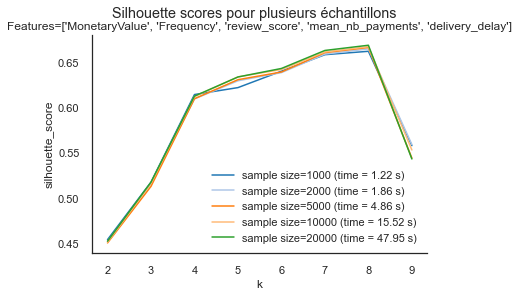

In [58]:
from yellowbrick.cluster import KElbowVisualizer
from time import time


def run_silhouette_visualizer(df: pd.DataFrame, n_samples=1000, k_range=(2, 10),
                              ax=None, random_state=RANDOM_SEED):
    """Shortcut pour yellowbrick KElbowVisualizer(metric=Silhouette Score)
     avec quantile transformation"""
    n_samples = min(n_samples, len(df))
    model = Pipeline(steps=[
        ('preprocessor', quantile_transformer),
        ('visualizer', KElbowVisualizer(
            KMeans(random_state=random_state), k=k_range, metric='silhouette',
            timings=False, locate_elbow=False, ax=ax, random_state=random_state))
    ])
    model.fit(df.sample(n_samples, random_state=random_state))
    visualizer: KElbowVisualizer = model.named_steps['visualizer']
    scores = pd.DataFrame({
        'k': visualizer.k_values_,
        'silhouette_score': visualizer.k_scores_,
    })
    visualizer.finalize()
    return scores


def plot_silhouettes_vs_k(df: pd.DataFrame, kmin=2, kmax=10):
    """Dans un seul plot, compare l'effet de sample size sur les silhouette visualisations"""
    fig0, ax0 = plt.subplots(1, 1)
    fig1, ax1 = plt.subplots(1, 1)

    k_range = range(kmin, kmax)

    # 25 minutes pour complete data
    # for sample_size in [1000,2000,5000,10000,20000,50000,100000]:
    # < 30s
    for sample_size in [1000, 2000, 5000, 10000, 20000]:
        start = time()
        n_samples = min(sample_size, len(df))
        scores = run_silhouette_visualizer(df, n_samples=n_samples,
                                           k_range=k_range, ax=ax0)
        calc_time = round((time()-start), 2)
        libelle = f'sample size={n_samples} (time = {calc_time} s)'
        sns.lineplot(data=scores, x='k', y='silhouette_score',
                     label=libelle, ax=ax1)

    fig0.clear()
    sns.despine()


plot_silhouettes_vs_k(df_clients[FEATURES_3], kmin=2, kmax=10)

plt.suptitle(f'Silhouette scores pour plusieurs échantillons')
plt.title(f'Features={FEATURES_3}')
to_png()


#### Le temps de calcul des silhouette_scores augment rapidement avec le nombre de points

Pour calculer le silhouette score, le temps de calcul est O(n^2)

- Avec 100000 points ça prends quelques minutes pour chaque valeur de k
- Avec 10000 points, c'est 100 fois plus rapide (quelque secondes), et les silhouette scores des clusters sont très similaires.

Pour augmenter le nombre d'essais de clustering, on fait l'analyse silhouette sur des sous-échantillons des données (qui donne une écart type pour le score à chaque k)


In [59]:
from sklearn.cluster import KMeans
from sklearn.base import clone, BaseEstimator
from sklearn import metrics


def calc_silhouette_score(df: pd.DataFrame, clf: BaseEstimator, n_iter=10, sample_size=1000):
    """
    Calculate mean and standard deviation of silhouette score for a model
    Parameters
    ----------
    df: scaled or unscaled features
    clf: model to fit labels on scaled features, or pipeline to scale and fit features 
       If df is unscaled, clf contains named steps 'preprocessor' to scale data, and 'clf' to fit the scaled data
       If df is scaled, clf can either be pipeline as above, or classifier (KMeans, DBSCAN etc)
    """
    if not sample_size is None:
        sample_size = min(sample_size, len(df))
    else:
        sample_size = min(2000, max(1000, len(df)//10))
    clf = clone(clf)
    df = df.copy()
    if hasattr(clf, 'named_steps'):
        if hasattr(clf.named_steps, 'preprocessor') & hasattr(clf.named_steps, 'clf'):
            # c'est un pipeline on sépare le preprocessor et classifier
            preprocessor = clf.named_steps['preprocessor']
            df = preprocessor.fit_transform(df)
            clf = clf.named_steps['clf']

    silh = []
    start_silh = time()
    for i in range(n_iter):
        if hasattr(clf, 'random_state'):
            # randomize estimator if possible
            clf.random_state = np.random.randint(0, 1e5)
        df_sample = pd.DataFrame(df).sample(sample_size)
        clf.fit(df_sample)
        if hasattr(clf, 'labels_'):
            labels = clf.labels_
        else:
            labels.append(clf.predict(df))
        if pd.Series(labels).nunique() > 1:
            silh.append(metrics.silhouette_score(df_sample, labels))
    res = {}
    if len(silh) > 0:
        res['silhouette_score'] = np.round(np.mean(silh), 2)
        res['silhouette_score_std'] = np.round(np.std(silh), 2)
        res['silhouette_sample_sizes'] = int(sample_size)
        res['silhouette_time'] = round(time()-start_silh, 2)
    return res


calc_silhouette_score(
    df=QuantileTransformer().fit_transform(df_clients[FEATURES_RFM]),
    clf=KMeans(n_clusters=7),
    sample_size=1000)


{'silhouette_score': 0.38,
 'silhouette_score_std': 0.01,
 'silhouette_sample_sizes': 1000,
 'silhouette_time': 2.2}

In [60]:
calc_silhouette_score(
    df=df_clients[FEATURES_RFM],
    clf=Pipeline(
        steps=[('preprocessor', QuantileTransformer()), ('clf', KMeans(n_clusters=7))]),
    sample_size=1000)


{'silhouette_score': 0.38,
 'silhouette_score_std': 0.01,
 'silhouette_sample_sizes': 1000,
 'silhouette_time': 2.06}

### 4.3.4 Stability des clusters

- https://towardsdatascience.com/clustering-instability-486643bb686e


In [61]:
from sklearn.base import clone, BaseEstimator
from sklearn import metrics


def calc_cluster_stability(df: pd.DataFrame, clf: BaseEstimator, n_iter=10, sample_size=5000):
    """
    Measure stability of clusters of a classifier on a preprocessed dataset, using a sample of dataset
        Calculate mean and standard deviation of silhouette score for a model
    Parameters
    ----------
    df: scaled features
    clf: classifier with labels for scaled features, or a model able to predict them
    """
    # code based on https://github.com/scikit-learn/scikit-learn/issues/1091
    if not sample_size is None:
        sample_size = min(sample_size, len(df))
        df = pd.DataFrame(df).sample(sample_size)
    labels = []

    start = time()
    clf = clone(clf)
    for i in range(n_iter):
        if hasattr(clf, 'random_state'):
            # randomize estimator if possible
            clf.random_state = np.random.randint(0, 1e5)
        clf.fit(df)
        if hasattr(clf, 'labels_'):
            labels.append(clf.labels_)
        else:
            labels.append(clf.predict(df))

    scores = []
    # compare all scores to get average
    for i in range(0, n_iter - 1):
        for j in range(i + 1, n_iter):
            score = metrics.adjusted_rand_score(labels[i], labels[j])
            scores.append(score)

    res = {}
    res['stability_score'] = np.round(np.mean(scores), 2)
    res['stability_score_std'] = np.round(np.std(scores), 2)
    res['stability_sample_sizes'] = int(sample_size)
    res['stability_time'] = round(time()-start, 2)
    return res


# test 1: passing scaled data and a classifier
calc_cluster_stability(
    df=QuantileTransformer().fit_transform(df_clients[FEATURES_RFM]),
    clf=KMeans(n_clusters=7),
    sample_size=10000)


{'stability_score': 0.81,
 'stability_score_std': 0.17,
 'stability_sample_sizes': 10000,
 'stability_time': 4.41}

In [62]:
# test 2: passing raw data and model pipeline
calc_cluster_stability(
    df=df_clients[FEATURES_RFM],
    clf=Pipeline(steps=[('prep', QuantileTransformer()),
                 ('clf', KMeans(n_clusters=7))]),
    sample_size=10000)


{'stability_score': 0.85,
 'stability_score_std': 0.18,
 'stability_sample_sizes': 10000,
 'stability_time': 5.02}

On remarque que les clustering basé seulement sur RFM features :

- produit des clusters pas très séparés
- n'est pas très stable


### 4.3.5 Calcul des metriques de performance

In [63]:
def performance_metrics(df: pd.DataFrame, labels, clf: KMeans, k, sample_size=10000, random_state=RANDOM_SEED):
    """
    Calculer les performance metrics pour un classifier qui et déja fitted (KMeans, DBSCAN, CAH etc)
    Parameters
    ----------
    scaled_df
    labels
    clf
    k
    sample_size
    random_state

    Returns
    -------

    """
    df = df.copy()
    clf = clone(clf)
    n = min(len(df), sample_size)
    df['labels'] = labels
    df = df.sample(n=n, random_state=random_state)
    labels = df['labels'].values
    min_cluster_pct = df['labels'].value_counts(normalize=True).min()
    df = df.drop('labels', axis=1)
    res = {'k': k,
           'min_cluster_pct': round(min_cluster_pct*100, 2),
           'davies_bouldin': round(metrics.davies_bouldin_score(df, labels), 2),
           'calinski_harabasz': round(metrics.calinski_harabasz_score(df, labels), 2),
           'silhouette_score': round(metrics.silhouette_score(df, labels), 3)
           }
    if not clf is None:
        if hasattr(clf, 'inertia_'):
            res['distortion_score'] = round(getattr(clf, 'inertia_', 0), 0)
    return res


## 4.4 Procedure pour évaluer les hyperparamètres (ParameterGrid)

On pass un param_grid pour évaluer les models

Pour kmeans, on evalue la paramètre k= classifier parametre 'n_clusters' (**clf\_\_n_clusters**)


In [64]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from time import time

pre_quant_normal = QuantileTransformer(
    output_distribution='normal', random_state=RANDOM_SEED)
model_kmeans_quant_normal = Pipeline(steps=[
    ('preprocessor', pre_quant_normal),
    ('clf', KMeans(n_clusters=7, init='k-means++', random_state=RANDOM_SEED))
])

model_param_grid = {'clf__n_clusters': range(2, 10)}


def get_classname(estimator):
    return estimator.__class__.__name__


def score_model(df: pd.DataFrame, model=model_kmeans_quant_normal,
                param_grid=model_param_grid,
                calc_silhouette=True, calc_stability=True, show_params=False) -> pd.DataFrame:
    """
    Fit les clusters et ajouter des scores sur un dataset
    Parameters
    ----------
    df: data[features]
    model: pipeline with named steps 'preprocessor' and 'clf'
    param_grid: range of hyperparameters to test (prefixed preprocessor__ and clf__)
    calc_silhouette - calculate silhouette scores(chronophage)
    calc_silhouette - calculate stability of clusters (chronophage)
    show_params - if true, show all parameters of model (for debugging)
    Returns
    -------
    dataframe containing scores for all permutations of param_grid 
    """

    # define order of columns
    scores = pd.DataFrame([], columns={
        'k',
        'distortion_score',
        'davies_bouldin', 'calinski_harabasz',
        'silhouette_score', 'silhouette_score_std',
        'silhouette_sample_sizes', 'silhouette_time',
        'clf', 'preprocessor', 'features'
    })
    # generate parameter grid for classifier
    param_sets = ParameterGrid(param_grid)

    for params in param_sets:
        # print(f'score model for params = {params}')
        # set model parameters (usually just n_clusters for classifier)
        model.set_params(**params)

        preprocessor = model.named_steps['preprocessor']
        df_scaled = preprocessor.fit_transform(df)

        clf = model.named_steps['clf']
        start_fit_clf = time()
        clf.fit(df_scaled)
        fit_time_clf = round(time()-start_fit_clf, 2)
        labels: pd.Series = pd.Series(clf.labels_)
        k = labels.nunique()
        # size of clusters (as % of total)
        cluster_sizes = np.round((labels.value_counts(
            normalize=True).values*100), 0).astype(int)
        if k > 1:
            print(
                f'params={params}; k={k}; cluster_sizes={list(cluster_sizes)}')
        # inertia = distortion score = mean sum of squared distances to cluster centers
        # clf_params is a dictionary
        clf_params = dict(clf.get_params())
        res = {'k': k,
               'fit time (s)': fit_time_clf,
               'cluster_sizes': cluster_sizes,
               }
        res = dict(**res, **params)
        if k > 1:
            res['distortion_score'] = getattr(clf, 'inertia_', np.NaN)
            res['davies_bouldin'] = metrics.davies_bouldin_score(
                df_scaled, clf.labels_)
            res['calinski_harabasz'] = metrics.calinski_harabasz_score(
                df_scaled, clf.labels_)

            if calc_silhouette:
                # silhouette score basé sur une minimum de 2000 et un maximum de 20000 points
                # supposant que les clusters sont stables et seront approximativement les mêmes
                # plus de 20000 points prend trop de temps
                silh = calc_silhouette_score(df_scaled, clf, sample_size=2000)
                res = dict(**res, **silh)

            if calc_stability:
                stab = calc_cluster_stability(
                    df_scaled, clf, sample_size=20000)
                res = dict(**res, **stab)

        res['clf'] = get_classname(clf)
        res['preprocessor'] = get_classname(preprocessor)

        if show_params:
            # add all parameters to scores
            res['features'] = list(df.columns)
            res['preprocessor_params'] = dict(preprocessor.get_params())
            res['clf_params'] = clf_params

        scores = scores.append(res, ignore_index=True)
        scores['k'] = scores['k'].astype(int)
    return scores.dropna(axis=1, how='all')


## 4.5 Comparaison de Minibatch Kmeans et Kmeans

#### Minibatch KMeans (sur FEATURES_3)


In [65]:

model_minibatch_kmeans_quant_normal = Pipeline(steps=[
    ('preprocessor', pre_quant_normal),
    ('clf', MiniBatchKMeans(n_clusters=7, init='k-means++', random_state=RANDOM_SEED))
])

scores_essai_3_minibatch = score_model(df=df_clients[FEATURES_3],
                                model=model_minibatch_kmeans_quant_normal)
scores_essai_3_minibatch


params={'clf__n_clusters': 2}; k=2; cluster_sizes=[59, 41]
params={'clf__n_clusters': 3}; k=3; cluster_sizes=[41, 30, 29]
params={'clf__n_clusters': 4}; k=4; cluster_sizes=[30, 29, 22, 20]
params={'clf__n_clusters': 5}; k=5; cluster_sizes=[30, 29, 20, 16, 5]
params={'clf__n_clusters': 6}; k=6; cluster_sizes=[29, 22, 16, 15, 14, 4]
params={'clf__n_clusters': 7}; k=7; cluster_sizes=[29, 28, 16, 15, 5, 4, 3]
params={'clf__n_clusters': 8}; k=8; cluster_sizes=[29, 28, 19, 16, 3, 3, 2, 1]
params={'clf__n_clusters': 9}; k=9; cluster_sizes=[28, 16, 16, 15, 13, 5, 4, 2, 1]


davies_bouldin  silhouette_time  calinski_harabasz         preprocessor  \
0            1.06             2.19           66049.70  QuantileTransformer   
1            0.72             2.30           76492.82  QuantileTransformer   
2            0.68             2.31          106964.86  QuantileTransformer   
3            0.65             2.58           99475.87  QuantileTransformer   
4            0.98             2.34           80978.80  QuantileTransformer   
5            0.65             2.28          120577.19  QuantileTransformer   
6            0.79             2.47           89340.85  QuantileTransformer   
7            0.87             2.41          111505.21  QuantileTransformer   

   distortion_score  silhouette_score              clf  \
0        1129512.01              0.44  MiniBatchKMeans   
1         708088.70              0.51  MiniBatchKMeans   
2         411384.40              0.61  MiniBatchKMeans   
3         345762.92              0.62  MiniBatchKMeans   
4         340179.56              0.63  MiniBatchKMeans   
5         205227.24              0.63  MiniBatchKMeans   
6         234224.15              0.64  MiniBatchKMeans   
7         169825.44              0.51  MiniBatchKMeans   

  silhouette_sample_sizes  silhouette_score_std  k  clf__n_clusters  \
0                    2000                  0.02  2             2.00   
1                    2000                  0.02  3             3.00   
2                    2000                  0.01  4             4.00   
3                    2000                  0.01  5             5.00   
4                    2000                  0.03  6             6.00   
5                    2000                  0.05  7             7.00   
6                    2000                  0.05  8             8.00   
7                    2000                  0.08  9             9.00   

                      cluster_sizes  fit time (s)  stability_sample_sizes  \
0                          [59, 41]          0.70                20000.00   
1                      [41, 30, 29]          0.49                20000.00   
2                  [30, 29, 22, 20]          0.07                20000.00   
3               [30, 29, 20, 16, 5]          0.30                20000.00   
4           [29, 22, 16, 15, 14, 4]          0.06                20000.00   
5         [29, 28, 16, 15, 5, 4, 3]          0.26                20000.00   
6      [29, 28, 19, 16, 3, 3, 2, 1]          0.16                20000.00   
7  [28, 16, 16, 15, 13, 5, 4, 2, 1]          0.07                20000.00   

   stability_score  stability_score_std  stability_time  
0             0.80                 0.40            2.14  
1             0.93                 0.15            1.70  
2             1.00                 0.00            1.17  
3             0.97                 0.04            1.08  
4             0.94                 0.07            1.33  
5             0.96                 0.06            1.74  
6             0.86                 0.05            1.43  
7             0.80                 0.08            1.50

#### KMeans (sur FEATURES_3)


In [66]:
# moins de 30 s
ESSAI_3 = 'Essai 3 : '
print(FEATURES_3)
# pre_quant_normal = QuantileTransformer(
#     output_distribution='normal', random_state=RANDOM_SEED)
# model_kmeans_quant_normal = Pipeline(steps=[
#     ('preprocessor', pre_quant_normal),
#     ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
# ])

scores_essai_3 = score_model(df_clients[FEATURES_3],
                      model=model_kmeans_quant_normal)
scores_essai_3


['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'delivery_delay']
params={'clf__n_clusters': 2}; k=2; cluster_sizes=[59, 41]
params={'clf__n_clusters': 3}; k=3; cluster_sizes=[41, 30, 29]
params={'clf__n_clusters': 4}; k=4; cluster_sizes=[30, 29, 22, 20]
params={'clf__n_clusters': 5}; k=5; cluster_sizes=[29, 28, 21, 19, 3]
params={'clf__n_clusters': 6}; k=6; cluster_sizes=[29, 28, 19, 16, 5, 3]
params={'clf__n_clusters': 7}; k=7; cluster_sizes=[29, 28, 16, 15, 5, 4, 3]
params={'clf__n_clusters': 8}; k=8; cluster_sizes=[29, 28, 16, 15, 5, 4, 2, 1]
params={'clf__n_clusters': 9}; k=9; cluster_sizes=[28, 16, 16, 15, 13, 5, 4, 2, 1]


davies_bouldin  silhouette_time  calinski_harabasz         preprocessor  \
0            1.06             1.84           66049.70  QuantileTransformer   
1            0.72             2.02           76492.82  QuantileTransformer   
2            0.68             1.95          106964.86  QuantileTransformer   
3            0.71             2.17          106510.66  QuantileTransformer   
4            0.67             2.25          110300.45  QuantileTransformer   
5            0.65             2.60          120577.19  QuantileTransformer   
6            0.73             2.78          114678.18  QuantileTransformer   
7            0.87             3.12          111548.83  QuantileTransformer   

   distortion_score  silhouette_score     clf silhouette_sample_sizes  \
0        1129492.88              0.45  KMeans                    2000   
1         707881.28              0.52  KMeans                    2000   
2         411329.84              0.61  KMeans                    2000   
3         325844.05              0.63  KMeans                    2000   
4         261097.53              0.64  KMeans                    2000   
5         205207.94              0.66  KMeans                    2000   
6         186773.21              0.66  KMeans                    2000   
7         169552.43              0.55  KMeans                    2000   

   silhouette_score_std  k  clf__n_clusters                     cluster_sizes  \
0                  0.00  2             2.00                          [59, 41]   
1                  0.01  3             3.00                      [41, 30, 29]   
2                  0.01  4             4.00                  [30, 29, 22, 20]   
3                  0.00  5             5.00               [29, 28, 21, 19, 3]   
4                  0.00  6             6.00            [29, 28, 19, 16, 5, 3]   
5                  0.00  7             7.00         [29, 28, 16, 15, 5, 4, 3]   
6                  0.04  8             8.00      [29, 28, 16, 15, 5, 4, 2, 1]   
7                  0.01  9             9.00  [28, 16, 16, 15, 13, 5, 4, 2, 1]   

   fit time (s)  stability_sample_sizes  stability_score  stability_score_std  \
0          0.31                20000.00             1.00                 0.00   
1          0.54                20000.00             1.00                 0.00   
2          0.51                20000.00             1.00                 0.00   
3          0.74                20000.00             0.98                 0.03   
4          1.12                20000.00             1.00                 0.00   
5          1.38                20000.00             1.00                 0.00   
6          2.36                20000.00             1.00                 0.00   
7          2.03                20000.00             0.93                 0.11   

   stability_time  
0            1.34  
1            1.95  
2            1.86  
3            2.65  
4            3.26  
5            4.55  
6            5.91  
7            7.00

"Essai_3_-__Comparaison_de_KMeans_et_Minibatch_KMeans.png"


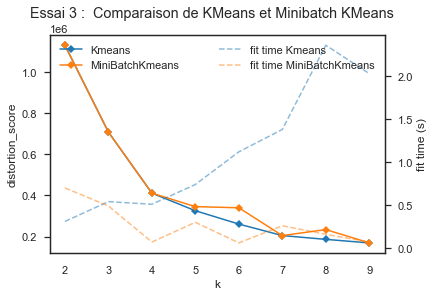

"Essai_3_-__Comparaison_de_KMeans_et_Minibatch_KMeans_(db).png"


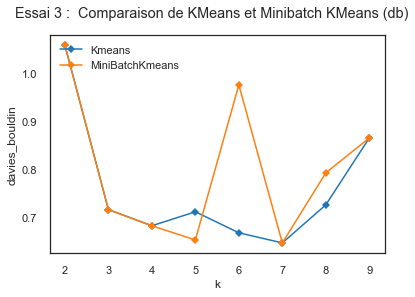

In [67]:
def plot_compare_essais(scores_1, scores_2,
                        metric='distortion_score', time_col='fit time (s)',
                        label_1='Scores 1', label_2='Scores 1'):
    """compare scores of two models"""
    colors = sns.color_palette('tab10').as_hex()
    _, ax_score = plt.subplots()
    ax_score.plot(scores_1['k'], scores_1[metric],
                  marker='D', label=label_1, color=colors[0])
    ax_score.plot(scores_2['k'], scores_2[metric],
                  marker='D', label=label_2, color=colors[1])
    ax_score.set_xlabel('k')
    ax_score.set_ylabel(metric)
    plt.legend(loc=2)
    if not (time_col is None):
        ax_time = ax_score.twinx()
        ax_time.plot(scores_essai_3['k'], scores_1[time_col],
                     label=f'fit time {label_1}', ls='--', color=colors[0], alpha=0.5)
        ax_time.plot(scores_2['k'], scores_2[time_col],
                     label=f'fit time {label_2}', ls='--', color=colors[1], alpha=0.5)
        ax_time.set_ylabel('fit time (s)')
        plt.legend(loc=1)


plot_compare_essais(scores_essai_3, scores_essai_3_minibatch,
                    label_1='Kmeans', label_2='MiniBatchKmeans')
plt.suptitle(f'{ESSAI_3} Comparaison de KMeans et Minibatch KMeans')
to_png()
plt.show()

plot_compare_essais(scores_essai_3, scores_essai_3_minibatch,
                    label_1='Kmeans', label_2='MiniBatchKmeans',
                    metric='davies_bouldin', time_col=None)
plt.suptitle(f'{ESSAI_3} Comparaison de KMeans et Minibatch KMeans (db)')
to_png()


"Essai_3_-__Comparaison_de_KMeans_et_Minibatch_KMeans_(stability).png"


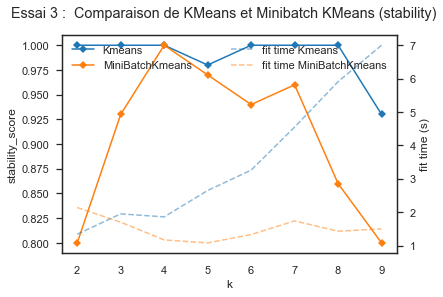

In [68]:
plot_compare_essais(scores_essai_3, scores_essai_3_minibatch,
                    label_1='Kmeans', label_2='MiniBatchKmeans',
                    metric='stability_score', time_col='stability_time')
plt.suptitle(
    f'{ESSAI_3} Comparaison de KMeans et Minibatch KMeans (stability)')
to_png()


Même si MiniBatch KMeans est plus rapide, les scores sont moins confiables


## 4.6 Visualisations de metriques de performance

On s'inspire de yellowbrick KElbowVisualizer pour generaliser à d'autres metriques (stability par exemple)


In [69]:
def angle_between_vectors(v1, v2):
    """
    calculate angle between 2 vectors.
    use to find elbows
    """
    ang1 = np.arctan2(*v1[::-1])
    ang2 = np.arctan2(*v2[::-1])
    ang = np.rad2deg(abs(ang1 - ang2) % (2 * np.pi))
    if ang > 180:
        ang = ang-180
    return ang


print([
    angle_between_vectors([1, 1], [0, 0]),
    angle_between_vectors([1, 1], [0, 1]),
    angle_between_vectors([1, 1], [-1, 0]),
    angle_between_vectors([1, 1], [-1, -1]),
])


[45.0, 45.0, 135.0, 180.0]


In [70]:

def find_elbow(df: pd.DataFrame, x_col='k', y_col='distortion_score'):
    """find sharpest difference in angle for [k, score]"""
    df = df.copy().reset_index()
    # standardise scale to maximise angles between points

    x_scale = df[x_col].max()-df[x_col].min()
    y_min = df[y_col].min()
    y_mult = (df[y_col].max()-y_min)/x_scale
    df['y_scaled'] = (df[y_col]-y_min)/y_mult

    # calculate angles between consecutive points
    n = len(df)
    for i in range(0, n-2):
        point1 = df.loc[i, [x_col, 'y_scaled']]
        point2 = df.loc[i+1, [x_col, 'y_scaled']]
        point3 = df.loc[i+2, [x_col, 'y_scaled']]
        vec1 = point2-point1
        vec2 = point3-point2
        df.loc[i+1, 'angle'] = angle_between_vectors(vec1, vec2)
    # elbow is at highest difference in angle (assume monotonic function)
    row = df['angle'].idxmax()
    x_elbow = df.loc[row, x_col]
    y_score = df.loc[row, y_col]
    return x_elbow, y_score


k_best, distortion_score = find_elbow(scores_essai_3, y_col='distortion_score')
print(f'{ESSAI_3} Best score for k = {k_best}')


Essai 3 :  Best score for k = 4


"Essai_3_-__Kmeans_Distortion_Score.png"


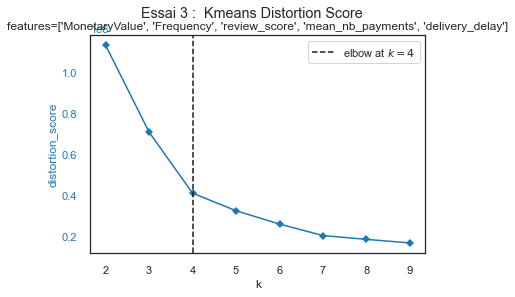

In [71]:
def plot_second_ax(df, x_col, y2_col, ax, color='grey'):
    """add a secondary y axis to a plot"""
    if y2_col in df.columns:
        ax2 = ax.twinx()
        ax2.plot(df[x_col], df[y2_col], label=y2_col,
                 c=color, marker='o', linestyle='--', alpha=0.75)
        ax2.tick_params(axis='y', colors=color)
        ax2.set_ylabel(y2_col, color=color)


def plot_elbow(df, x_col, y_col, ax):
    """draw a vertical line at elbow on a plot"""
    elbow_k, elbow_score = find_elbow(df, x_col, y_col)
    elbow_label = f'elbow at ${x_col}={elbow_k}$'
    ax.axvline(elbow_k, c='k', linestyle="--", label=elbow_label)
    ax.legend(frameon=True)


def plot_vline(df, x_col, y_col, ax, line_at='max'):
    """draw a vertical line at max or min value of y on a plot"""
    if line_at == 'max':
        row_idx = df[y_col].argmax()
    elif line_at == 'min':
        row_idx = df[y_col].argmin()
    line_x = df.loc[row_idx, x_col]
    line_label = f'{line_at} at ${x_col}={line_x}$'
    ax.axvline(line_x, c='k', linestyle="--", label=line_label)
    ax.legend(frameon=True)


def plot_elbow_visualiser(df: pd.DataFrame, x_col='k', score_col='distortion_score',
                          show_elbow=False, time_col=None, ax1=None):
    """
    Generic ElbowVisualiser, capable of showing any metric, elbows, secondary axis...
    Allows subsequent manipulation of plots
    """
    colors = sns.color_palette("tab20").as_hex()
    if ax1 is None:
        _, ax1 = plt.subplots()
    # scores
    ax1.plot(df[x_col], df[score_col],
             marker="D", c=colors[0], linestyle="-")
    ax1.grid(False)
    ax1.tick_params(axis='y', colors=colors[0])
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(score_col, c=colors[0])
    # fit times
    if not time_col is None:
        plot_second_ax(df, x_col, y2_col=time_col, ax=ax1)
    if show_elbow:
        plot_elbow(df, x_col, score_col, ax1)


# Test visualiser
plot_elbow_visualiser(scores_essai_3, score_col='distortion_score', show_elbow=True)
plt.suptitle(f'{ESSAI_3} Kmeans Distortion Score')
plt.title(f'features={FEATURES_3}')
to_png()


### 4.6.1 Plot summary metrics


In [72]:
print(sorted(list(scores_essai_3.columns)))


['calinski_harabasz', 'clf', 'clf__n_clusters', 'cluster_sizes', 'davies_bouldin', 'distortion_score', 'fit time (s)', 'k', 'preprocessor', 'silhouette_sample_sizes', 'silhouette_score', 'silhouette_score_std', 'silhouette_time', 'stability_sample_sizes', 'stability_score', 'stability_score_std', 'stability_time']


In [73]:
def plot_metrics(df_scores, x_col='k'):
    """
    Plot each clustering metric in df_scores in a subplot
    Plots to show depend on metrics added to df_scores
    Parameters
    ----------
    df_scores   Scores for all permutations of a param_grid (previously calculated)
    x_col       Choice of parameter to compare -by default k, but can show any hyperparameter
    """
    if 'clf' in df_scores.columns and 'preprocessor' in df_scores.columns:
        print(
            f"plotting metrics (clf: {df_scores['clf'][0]}, preprocessor: {df_scores['preprocessor'][0]})")

    METRICS = ['distortion_score', 'calinski_harabasz',
               'davies_bouldin', 'silhouette_score', 'stability_score']
    metrics = cols_in_df(df_scores, METRICS)
    n_plots = len(metrics)
    n_cols = min(n_plots, 2)
    # n_rows = int(ceil(n_plots/n_cols))
    n_rows = n_plots // n_cols + (n_plots % n_cols > 0)
    _ = plt.figure(figsize=(n_cols*5, n_rows*3))
    for n, metric in enumerate(metrics):
        ax = plt.subplot(n_rows, n_cols, n + 1)
        if metric == 'distortion_score':
            plot_elbow_visualiser(
                df_scores, x_col, metric, ax1=ax, time_col='fit time (s)', show_elbow=True)
            plt.title(metric)
        if metric == 'calinski_harabasz':
            plot_elbow_visualiser(df_scores, x_col, metric, ax1=ax)
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(f'{metric} score (max={df_scores[metric].max():.0f})')
        if metric == 'davies_bouldin':
            plot_elbow_visualiser(df_scores, x_col, metric, ax1=ax)
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='min')
            plt.title(f'{metric} score (min={df_scores[metric].min():.2f})')
        if metric == 'silhouette_score':
            titre = f'{metric} (max={df_scores[metric].max():.2f})'
            if 'silhouette_score_std' in df_scores.columns:
                if 'silhouette_sample_sizes' in df_scores.columns:
                    sample_size = int(
                        df_scores['silhouette_sample_sizes'].max())
                    titre += f' 10 samples de {sample_size} pts'
                plt.errorbar(data=df_scores, x=x_col, y='silhouette_score',
                             yerr='silhouette_score_std')
            plot_elbow_visualiser(df_scores, x_col, metric,
                                  ax1=ax, time_col='silhouette_time')
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(titre)
        if metric == 'stability_score':
            titre = f'{metric} (max={df_scores[metric].max():.2f})'
            if 'stability_score_std' in df_scores.columns:
                if 'stability_sample_sizes' in df_scores.columns:
                    sample_size = int(
                        df_scores['stability_sample_sizes'].max())
                    titre += f' 10 samples de {sample_size} pts'
                plt.errorbar(data=df_scores, x=x_col, y='stability_score',
                             yerr='stability_score_std')
            plot_elbow_visualiser(df_scores, x_col, metric,
                                  ax1=ax, time_col='stability_time')
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(titre)

    plt.subplots_adjust(hspace=0.5, wspace=0.5)


## 4.7 Essais Kmeans sur plusieurs méthodes de preprocessing:

Rappel (voir quelques cellules avant):

- Features : ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'delivery_delay']
- Preprocessor : Quantile (normal distribution)
- Classifier : KMeans (initialisé avec k-means++)

Nous avons vu que le silhouette score ne change pas beaucoup avec sample size.

Pour accelerer la recherche du meilleur k, on evaluer les models sur un maximum de 50% des données, qui se transforme en accélerer les scores par 4 fois

In [74]:
sample_size = int(min(round(len(df_clients)*0.5),SAMPLE_SIZE))
df_clients_sample= df_clients.sample(sample_size, random_state=RANDOM_SEED)

### 4.7.1 Essai 3a, 3b, 3c - sur FEATURES_3

In [75]:
print(FEATURES_3)


['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'delivery_delay']


params={'clf__n_clusters': 2}; k=2; cluster_sizes=[58, 42]
params={'clf__n_clusters': 3}; k=3; cluster_sizes=[42, 30, 28]
params={'clf__n_clusters': 4}; k=4; cluster_sizes=[30, 28, 22, 20]
params={'clf__n_clusters': 5}; k=5; cluster_sizes=[29, 28, 21, 19, 3]
params={'clf__n_clusters': 6}; k=6; cluster_sizes=[29, 28, 19, 16, 5, 3]
params={'clf__n_clusters': 7}; k=7; cluster_sizes=[29, 28, 16, 15, 5, 4, 3]
params={'clf__n_clusters': 8}; k=8; cluster_sizes=[29, 28, 16, 15, 5, 4, 2, 1]
params={'clf__n_clusters': 9}; k=9; cluster_sizes=[29, 16, 15, 14, 13, 5, 4, 2, 1]
plotting metrics (clf: KMeans, preprocessor: QuantileTransformer)
"Essai_3_-__performance_metrics.png"


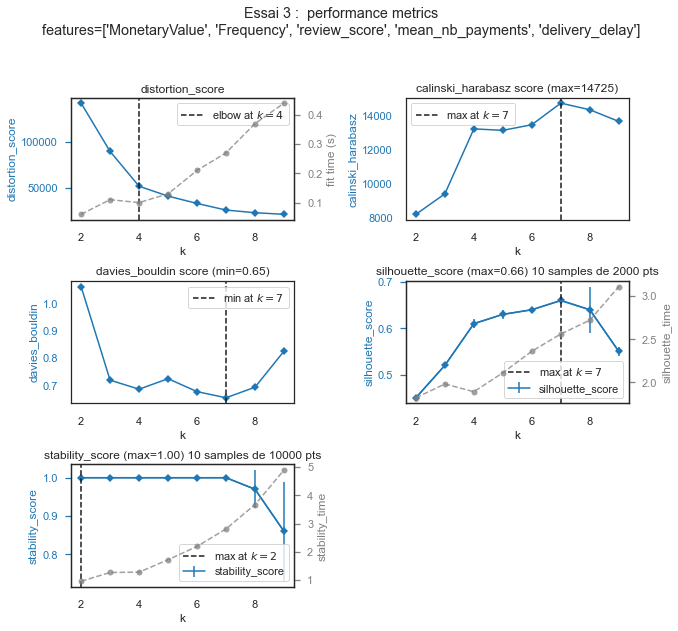

In [76]:
pre_quant_normal = QuantileTransformer(output_distribution='normal', random_state=RANDOM_SEED)
model_kmeans_quant_normal = Pipeline(steps=[
    ('preprocessor', pre_quant_normal),
    ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
])


scores_essai_3 = score_model(df_clients_sample[FEATURES_3],
                      model=model_kmeans_quant_normal)
plot_metrics(scores_essai_3)
titre = f'{ESSAI_3} performance metrics'
plt.suptitle(f'{titre}\nfeatures={FEATURES_3}', y=1.02)
to_png(titre)


params={'clf__n_clusters': 2}; k=2; cluster_sizes=[58, 42]
params={'clf__n_clusters': 3}; k=3; cluster_sizes=[42, 30, 28]
params={'clf__n_clusters': 4}; k=4; cluster_sizes=[30, 28, 22, 20]
params={'clf__n_clusters': 5}; k=5; cluster_sizes=[29, 28, 21, 19, 3]
params={'clf__n_clusters': 6}; k=6; cluster_sizes=[29, 28, 19, 16, 5, 3]
params={'clf__n_clusters': 7}; k=7; cluster_sizes=[29, 28, 16, 15, 5, 4, 3]
params={'clf__n_clusters': 8}; k=8; cluster_sizes=[29, 16, 15, 14, 14, 5, 4, 3]
params={'clf__n_clusters': 9}; k=9; cluster_sizes=[29, 16, 15, 14, 14, 5, 4, 2, 1]
plotting metrics (clf: KMeans, preprocessor: Pipeline)
"Essai_3b_-_(quantile_pca_prep)_performance_metrics.png"


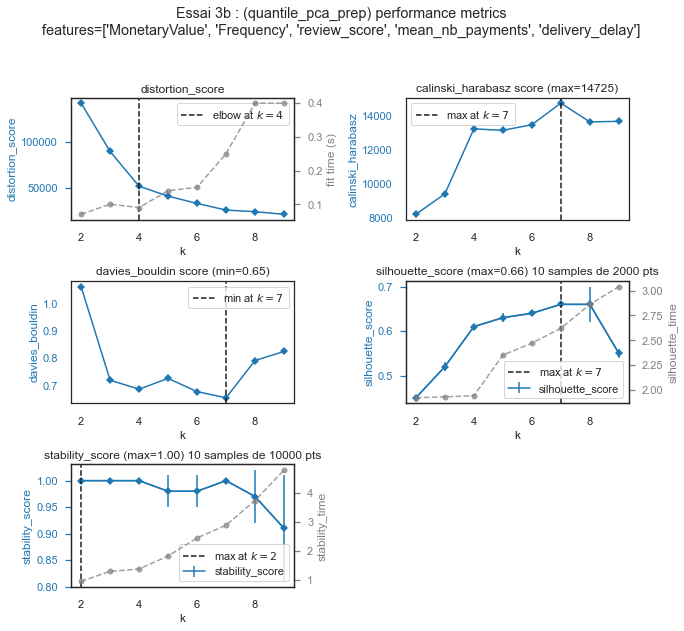

In [77]:
pca_preprocessor = Pipeline(steps=[
    ('scale', QuantileTransformer(
        output_distribution='normal', random_state=RANDOM_SEED)),
    ('pca', PCA())
])

model_pca_kmeans = Pipeline(
    steps=[('preprocessor', pca_preprocessor), ('clf', KMeans())])
scores_essai_3b = score_model(df_clients_sample[FEATURES_3], model=model_pca_kmeans,
                       calc_silhouette=True, calc_stability=True)

plot_metrics(scores_essai_3b)
titre = f'Essai 3b : (quantile_pca_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={FEATURES_3}', y=1.02)
to_png(titre)


params={'clf__n_clusters': 2}; k=2; cluster_sizes=[97, 3]
params={'clf__n_clusters': 3}; k=3; cluster_sizes=[78, 19, 3]
params={'clf__n_clusters': 4}; k=4; cluster_sizes=[67, 15, 15, 3]
params={'clf__n_clusters': 5}; k=5; cluster_sizes=[62, 17, 15, 3, 3]
params={'clf__n_clusters': 6}; k=6; cluster_sizes=[43, 22, 16, 14, 3, 3]
params={'clf__n_clusters': 7}; k=7; cluster_sizes=[41, 20, 15, 14, 5, 3, 3]
params={'clf__n_clusters': 8}; k=8; cluster_sizes=[41, 19, 15, 13, 5, 3, 3, 1]
params={'clf__n_clusters': 9}; k=9; cluster_sizes=[36, 18, 14, 13, 8, 5, 3, 3, 1]
plotting metrics (clf: KMeans, preprocessor: StandardScaler)
"Essai_3c-_KMeans_(standard_scalar_prep)_performance_metrics.png"


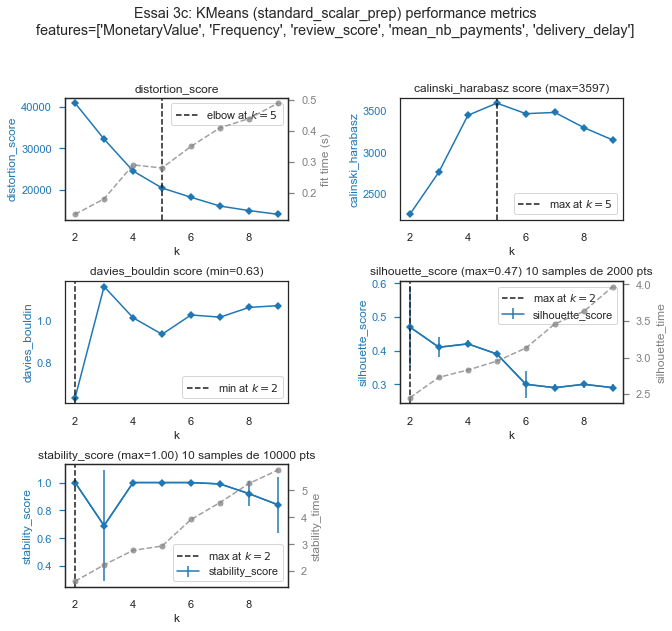

In [78]:
model_std_kmeans = Pipeline(
    steps=[('preprocessor', StandardScaler()), ('clf', KMeans())])

scores_essai_3c = score_model(df_clients_sample[FEATURES_3], model_std_kmeans)

plot_metrics(scores_essai_3c)
titre = f'Essai 3c: KMeans (standard_scalar_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={FEATURES_3}', y=1.02)
to_png(titre)


## 4.8 Essais KMeans sur d'autres ensembles de features

Les tests ci-dessus avec **FEATURES_3** indique que preprocessing avec QuantileTransformer (output='normal') produit les clusters plus

- coherent
- distinct
- stable

En gardant cette preprocesseur, on essaie d'autres ensembles de features avec des grand "loadings" dans les premiers 6 composants principaux

- FEATURES_3 = ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments','delivery_delay']
- FEATURES_4 = ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'products_per_order']
- FEATURES_5 = ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments',
  'products_per_order', 'Recency']
- FEATURES_6 = ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments',
  'Recency']


### Essai 3d, 3e (sur FEATURES 4)


['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'products_per_order']
params={'clf__n_clusters': 2}; k=2; cluster_sizes=[58, 42]
params={'clf__n_clusters': 3}; k=3; cluster_sizes=[42, 30, 28]
params={'clf__n_clusters': 4}; k=4; cluster_sizes=[30, 28, 22, 20]
params={'clf__n_clusters': 5}; k=5; cluster_sizes=[27, 26, 20, 18, 8]
params={'clf__n_clusters': 6}; k=6; cluster_sizes=[27, 26, 19, 18, 5, 5]
params={'clf__n_clusters': 7}; k=7; cluster_sizes=[27, 26, 18, 17, 5, 4, 3]
params={'clf__n_clusters': 8}; k=8; cluster_sizes=[27, 26, 18, 13, 5, 4, 4, 3]
params={'clf__n_clusters': 9}; k=9; cluster_sizes=[27, 26, 14, 13, 5, 4, 4, 4, 3]
params={'clf__n_clusters': 10}; k=10; cluster_sizes=[27, 26, 14, 13, 4, 4, 4, 3, 3, 2]
params={'clf__n_clusters': 11}; k=11; cluster_sizes=[27, 26, 14, 13, 4, 4, 3, 3, 2, 2, 2]
params={'clf__n_clusters': 12}; k=12; cluster_sizes=[27, 26, 14, 13, 4, 4, 3, 2, 2, 2, 2, 1]
params={'clf__n_clusters': 13}; k=13; cluster_sizes=[26, 14, 14, 13, 13,

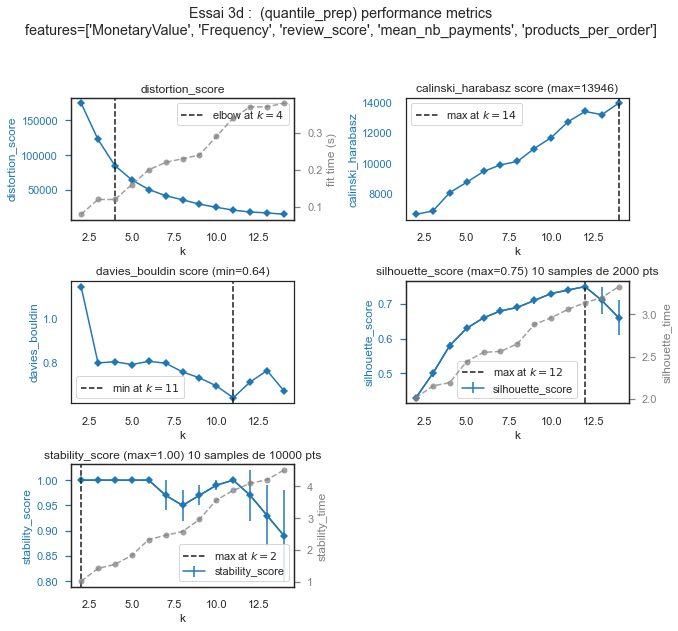

In [79]:
ESSAI_3d = 'Essai 3d : '
print(FEATURES_4)
param_grid_3d = {'clf__n_clusters': range(2, 15)}
scores_essai_3d = score_model(df=df_clients_sample[FEATURES_4],
                       model=model_kmeans_quant_normal,
                       param_grid=param_grid_3d)

plot_metrics(scores_essai_3d)
titre = f'{ESSAI_3d} (quantile_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={FEATURES_4}', y=1.02)
to_png(titre)


['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'products_per_order', 'delivery_delay']
params={'clf__n_clusters': 2}; k=2; cluster_sizes=[58, 42]
params={'clf__n_clusters': 3}; k=3; cluster_sizes=[42, 30, 28]
params={'clf__n_clusters': 4}; k=4; cluster_sizes=[30, 28, 22, 20]
params={'clf__n_clusters': 5}; k=5; cluster_sizes=[27, 26, 20, 18, 8]
params={'clf__n_clusters': 6}; k=6; cluster_sizes=[27, 26, 19, 18, 5, 5]
params={'clf__n_clusters': 7}; k=7; cluster_sizes=[27, 26, 18, 17, 5, 4, 3]
params={'clf__n_clusters': 8}; k=8; cluster_sizes=[27, 26, 18, 13, 5, 4, 4, 3]
params={'clf__n_clusters': 9}; k=9; cluster_sizes=[27, 26, 17, 14, 4, 4, 3, 3, 2]
plotting metrics (clf: KMeans, preprocessor: QuantileTransformer)
"Essai_3e_-__(quantile_prep)_performance_metrics.png"


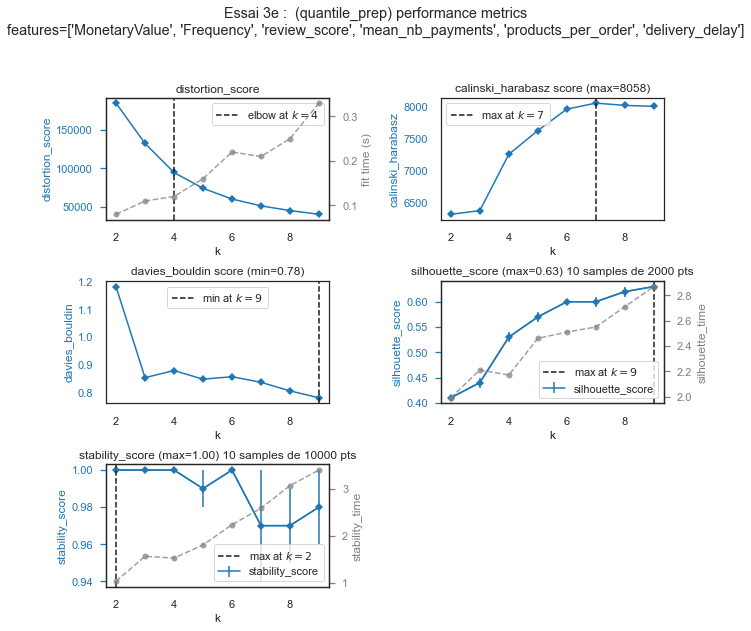

In [80]:
ESSAI_3e = 'Essai 3e : '
FEATURES_4b = ['MonetaryValue', 'Frequency', 'review_score',
               'mean_nb_payments', 'products_per_order', 'delivery_delay']
print(FEATURES_4b)
scores_essai_3e = score_model(df_clients_sample[FEATURES_4b], model=model_kmeans_quant_normal)

plot_metrics(scores_essai_3e)
titre = f'{ESSAI_3e} (quantile_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={FEATURES_4b}', y=1.02)
to_png(titre)


### Essai 3f (sur FEATURES 5)

['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'Recency']
params={'clf__n_clusters': 2}; k=2; cluster_sizes=[58, 42]
params={'clf__n_clusters': 3}; k=3; cluster_sizes=[42, 30, 28]
params={'clf__n_clusters': 4}; k=4; cluster_sizes=[30, 28, 22, 20]
params={'clf__n_clusters': 5}; k=5; cluster_sizes=[29, 28, 21, 19, 3]
params={'clf__n_clusters': 6}; k=6; cluster_sizes=[29, 28, 19, 16, 5, 3]
params={'clf__n_clusters': 7}; k=7; cluster_sizes=[29, 28, 16, 15, 5, 4, 3]
params={'clf__n_clusters': 8}; k=8; cluster_sizes=[29, 28, 16, 15, 5, 4, 2, 1]
params={'clf__n_clusters': 9}; k=9; cluster_sizes=[28, 16, 15, 15, 14, 5, 4, 2, 1]
plotting metrics (clf: KMeans, preprocessor: QuantileTransformer)
"Essai_3f_-__(quantile_prep)_performance_metrics.png"


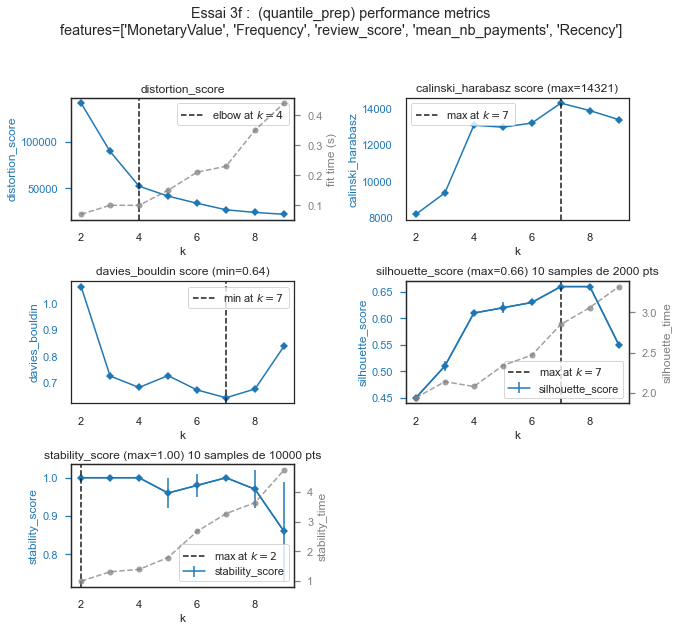

In [81]:
ESSAI_3f = 'Essai 3f : '
print(FEATURES_5)
scores_essai_3f = score_model(df_clients_sample[FEATURES_5], model=model_kmeans_quant_normal)

plot_metrics(scores_essai_3f)
titre = f'{ESSAI_3f} (quantile_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={FEATURES_5}', y=1.02)
to_png(titre)


### Essai 3g (sur FEATURES 5)

['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'products_per_order', 'Recency']
params={'clf__n_clusters': 2}; k=2; cluster_sizes=[58, 42]
params={'clf__n_clusters': 3}; k=3; cluster_sizes=[42, 30, 28]
params={'clf__n_clusters': 4}; k=4; cluster_sizes=[30, 28, 22, 20]
params={'clf__n_clusters': 5}; k=5; cluster_sizes=[27, 26, 20, 18, 8]
params={'clf__n_clusters': 6}; k=6; cluster_sizes=[27, 26, 19, 18, 5, 5]
params={'clf__n_clusters': 7}; k=7; cluster_sizes=[27, 26, 18, 17, 5, 4, 3]
params={'clf__n_clusters': 8}; k=8; cluster_sizes=[27, 26, 18, 17, 4, 3, 3, 2]
params={'clf__n_clusters': 9}; k=9; cluster_sizes=[27, 26, 14, 13, 5, 4, 4, 4, 3]
plotting metrics (clf: KMeans, preprocessor: QuantileTransformer)
"Essai_3g_-__(quantile_prep)_performance_metrics.png"


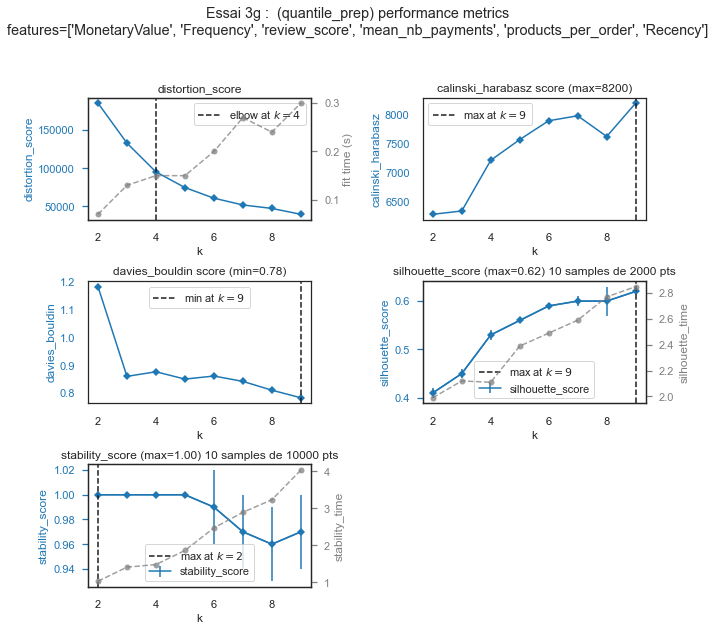

In [82]:
ESSAI_3g = 'Essai 3g : '
print(FEATURES_6)
scores_essai_3g = score_model(df_clients_sample[FEATURES_6], model=model_kmeans_quant_normal)


plot_metrics(scores_essai_3g)
titre = f'{ESSAI_3g} (quantile_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={FEATURES_6}', y=1.02)
to_png(titre)


## 4.9 Conclusion sur KMeans

Les meilleurs coherence (avec random_state=0) sont pour

- Features : ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'delivery_delay']
- Preprocessor : Quantile (normal distribution)
- Classifier : KMeans (initialisé avec k-means++)
- Nombre de clusters = 7


In [83]:
k_best = 7
print(k_best)


7


#### Visualisation des distances entre clusters


"Essai_3_-__Distance(MDS)_for_k_=_7.png"


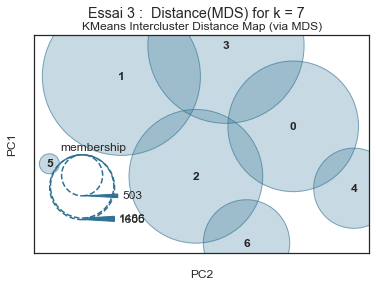

In [84]:
from yellowbrick.cluster import InterclusterDistance
from sklearn.cluster import KMeans, MiniBatchKMeans
model_vis = Pipeline(steps=[
    ('preprocessor', quantile_transformer),
    ('visualizer', InterclusterDistance(
        KMeans(random_state=RANDOM_SEED, n_clusters=k_best)))
])

model_vis.fit(df_clients_sample[FEATURES_3])
model_vis.named_steps['visualizer'].finalize()
plt.suptitle(f'{ESSAI_3} Distance(MDS) for k = {k_best}')
to_png()


"Essai_3_-__Distance(t-SNE)_for_k_=_7.png"


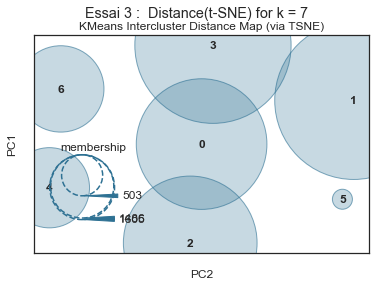

In [85]:
from yellowbrick.cluster import InterclusterDistance
from sklearn.cluster import KMeans
model_vis_tsne = Pipeline(steps=[
    ('preprocessor', quantile_transformer),
    ('visualizer', InterclusterDistance(
        KMeans(n_clusters=k_best, random_state=RANDOM_SEED,), embedding='tsne'))
])
model_vis_tsne.fit(df_clients_sample[FEATURES_3])
model_vis_tsne.named_steps['visualizer'].finalize()
plt.suptitle(f'{ESSAI_3} Distance(t-SNE) for k = {k_best}')
to_png()


## 4.10 Silhouette visualisation

On voit que le silhouette score est meilleur avec 7 clusters.

On cherche non seulement un bonne score silhouette moyenne, mais que chaque cluster à un bonne silhouette score.

- <https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html>
- <https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html>
- <https://towardsdatascience.com/are-you-solving-ml-clustering-problems-using-k-means-68fb4efa5469>


"Silhouette_score_for_8_clusters_-_0-667-Features_=_['MonetaryValue',_'Frequency',_'review_score',_'mean_nb_payments',_'delivery_delay'].png"


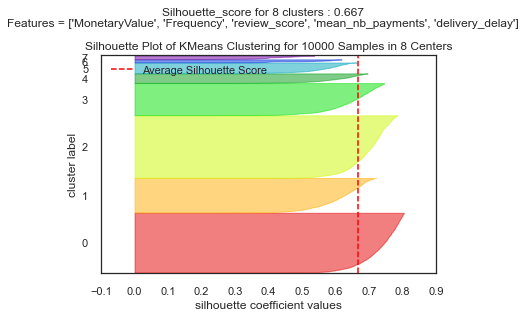

In [86]:
from yellowbrick.cluster import SilhouetteVisualizer


def plot_silhouettes(df: pd.DataFrame, k_clusters=7, preprocessor=quantile_transformer):
    """shortcut to preprocess, fit and run silhouette visualizer"""
    cluster_colors = sns.color_palette('nipy_spectral_r', n_colors=k_clusters)
    estimator = KMeans(n_clusters=k_clusters, random_state=RANDOM_SEED)
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('visualizer', SilhouetteVisualizer(estimator, colors=cluster_colors))
    ])

    n_samples = min(20000, len(df))
    model.fit(df.sample(n_samples, random_state=RANDOM_SEED))
    visualizer: SilhouetteVisualizer = model.named_steps['visualizer']

    # ~ 5 minutes
    visualizer.finalize()        # Finalize and render the figure
    titre = f'Silhouette_score for {k_clusters} clusters : {visualizer.silhouette_score_:.3f}'
    subtitre = f'Features = {FEATURES_3}'
    plt.suptitle(f'{titre}\n{subtitre}', fontsize=12, y=1.05)
    to_png(f'{titre}-{subtitre}')


plot_silhouettes(df_clients_sample[FEATURES_3], k_clusters=8)


"Silhouette_score_for_7_clusters_-_0-661-Features_=_['MonetaryValue',_'Frequency',_'review_score',_'mean_nb_payments',_'delivery_delay'].png"


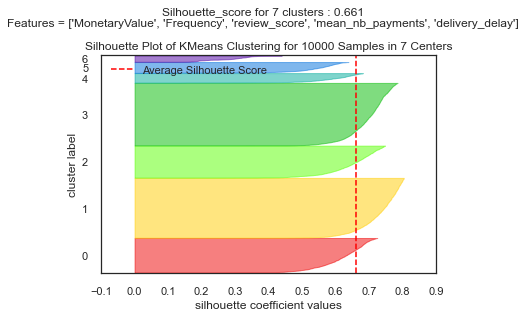

In [87]:
plot_silhouettes(df_clients_sample[FEATURES_3], k_clusters=7)


"Silhouette_score_for_6_clusters_-_0-642-Features_=_['MonetaryValue',_'Frequency',_'review_score',_'mean_nb_payments',_'delivery_delay'].png"


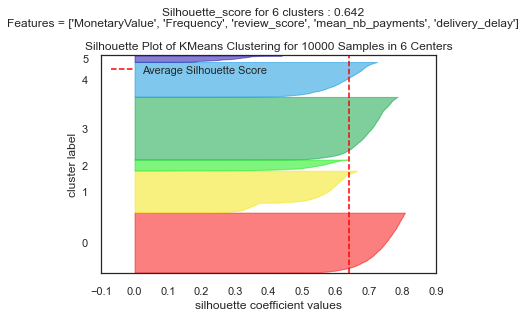

In [88]:
plot_silhouettes(df_clients_sample[FEATURES_3], k_clusters=6)


"Silhouette_score_for_5_clusters_-_0-634-Features_=_['MonetaryValue',_'Frequency',_'review_score',_'mean_nb_payments',_'delivery_delay'].png"


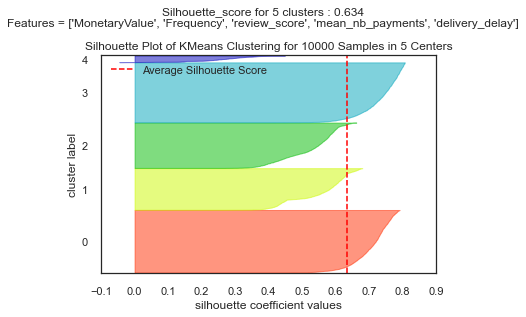

In [89]:
plot_silhouettes(df_clients_sample[FEATURES_3], k_clusters=5)


### Les résultats de l'analyse Silhouette

- les clusters sont assez équivalents en taille
- les clusters sont denses et séparées

---

In [90]:
k_best = 7


# 5. Procedures pour automatiser la fit, metrics, aggregation des clusters

Les routines dans cette section permet de comparer KMeans avec d'autres methodes de clustering non-supervisées.

Ces routines automatise la preprocessing, recherche d'hyperparamètres, calcul de métrics, création de visualisations qui résule les résultats

- run_fit_model
- run_predict_model
- calc_metrics
- group_clusters



### Run Fit Model


In [91]:
from sklearn.base import BaseEstimator
from copy import deepcopy
FEATURES = ['Frequency', 'MonetaryValue',
            'review_score', 'mean_nb_payments', 'delivery_delay']


def run_fit_model(df: pd.DataFrame, model_: BaseEstimator, features=FEATURES, k=7,
                  remove_outliers_during_fit=True, percent_outliers=0.005,
                  random_state=RANDOM_SEED):
    """
    Run classification model sur les features selectionnées

    Parameters
    ----------
    df      données à classifier
    model_  un pipeline de clustering, avec 'clf' comme named step qui contient l'estimator
    features subset de colonnes de df à prendre en compte pendant le fit
    remove_outliers_during_fit  permet d'exclure outliers avant scaling par preprocessor. 
    Pour QuantileTransformer, remove_outliers_during_fit n'est pas aussi important que Standard Scaler   

    Returns
    -------
    données, plus une colonne qui contient les cluster labels
    """

    df = df.copy()

    # Eliminer des outliers avant fit
    if percent_outliers <= 0:
        remove_outliers_during_fit = False

    if remove_outliers_during_fit:
        # trouver outliers seulement dans les features utilisés pour fit model
        df = df.pipe(find_outliers, num_cols=features,
                     alpha=percent_outliers, random_state=random_state)
        df_outliers = df[df['outlier'] == 'yes']
        df = df[df['outlier'] != 'yes']

    # Définir nombre de clusters
    # s'il y a d'autre parametres,
    # appliquer model.set_params(...) avant de passer le model à ce procedure
    if not k is None:
        # certain clustering ne permet pas de definir le nombre de clusters
        params = {'clf__n_clusters': k}
        model_.set_params(**params)

    # fit les clusters
    model_.fit(df[features])

    clf = model_.named_steps['clf']
    if hasattr(clf, 'labels_'):
        # pas besoin de predict - il est déjà fait
        df['cluster_id'] = clf.labels_
    else:
        df['cluster_id'] = model_.predict(df[features])

    if remove_outliers_during_fit:
        # predict les outliers, et ajouter au résultats
        df_outliers['cluster_id'] = model_.predict(df_outliers[features])
        df = df.append(df_outliers, ignore_index=False)

    return df, deepcopy(model_)


def run_predict_model(df, fitted_model, features=FEATURES):
    """shortcut to add/replace cluster labels after prediction"""
    df = df.copy()
    df['cluster_id'] = fitted_model.predict(df[features])
    return df


In [92]:
def get_metrics(df, features, preprocessor=None, clf=None, cluster_col=CLUSTER_COL):
    """return performance for a given preprocessor and classifier"""
    if preprocessor is None:
        preprocessor = QuantileTransformer(output_distribution='normal')
    df_scaled = pd.DataFrame(
        preprocessor.fit_transform(df[features]),
        index=df.index,
        columns=features)
    metr = performance_metrics(
        df_scaled, df[cluster_col], clf=clf, k=df[cluster_col].nunique())
    return metr


### Calculer les moyennes pour chaque cluster


In [93]:
def drop_cluster_labels(df: pd.DataFrame, cluster_col=CLUSTER_COL):
    """drop column of cluster labels, if it exists"""
    if cluster_col in df.columns:
        return df.drop(cluster_col, axis=1)
    return df


In [94]:
# pre_quant_normal = QuantileTransformer(
#     output_distribution='normal', random_state=RANDOM_SEED)
# model_kmeans_quant_normal = Pipeline(steps=[
#     ('preprocessor', pre_quant_normal),
#     ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
# ])

client_clusters, _ = run_fit_model(
    df_clients_sample, model_kmeans_quant_normal, FEATURES_3, k=7)
client_groups = group_clusters(client_clusters)
client_groups[[CLUSTER_COL, 'cluster_size', 'cluster_pct', *FEATURES_3]]


cluster_id  cluster_size  cluster_pct  MonetaryValue  Frequency  \
0          4           503         5.03         224.52       1.02   
1          2          2897        28.97         191.96       1.00   
2          1          1605        16.05         187.04       1.00   
3          6           288         2.88         144.19       2.08   
4          5           445         4.45         133.91       1.01   
5          3          1486        14.86         117.23       1.00   
6          0          2776        27.76         113.91       1.00   

   review_score  mean_nb_payments  delivery_delay  
0          1.00              5.03           -3.24  
1          5.00              4.73          -13.33  
2          3.52              4.70          -11.07  
3          4.27              3.39          -12.58  
4          1.00              1.00           -2.29  
5          3.54              1.00          -10.23  
6          5.00              1.00          -12.45

# 6. Visualisation des clusters

A chaque fit des clusters, les clusters sont intialisés aléatoirement. En conséquance, leur identifiants change à chaque run.

Pour pouvoir interpreter et comparer les clusters, on peut:
- trier par un variable (exemple: par valeur monétaire); ou
- créer une 'score_total' pour chaque cluster, qui dépend des variables sélectionnées et de nos objectives

Un fois le score total calculé pour chaque cluster, on peut trier les clusters par ce score total:
- **Seg. 1** : cluster avec le plus haut score
- **Seg. 2** : cluster avec 2eme plus haut score
- etc.

## 6.1 Création d'un **score total**

Il faut _**standardiser**_ les variables utilisés pour calculer le score total, sinon une seule  variable peut dominer les scores.


### 6.1.1 Standardisation des échelles pour Spider (radar) et Snake (line) plots

Le plus simple c'est de noter chaque cluster dans une échelle de 1 à 5, pour chaque variable d'interêt. Ensuite, on peut comparer tous les variables sur un plot radar ou un lineplot ('snake plot')

Pour avoir les données à la même echelle, on applique le MinMaxScalar sur les means de chaque cluster.


In [95]:
def standard_scores(df: pd.DataFrame, features=FEATURES,
                    scaler=None, min_score=1, max_score=5) -> pd.DataFrame:
    """
    Standardise scale of feature columns
    - Apply to cluster group summary for rapidity
    Returns dataframe with same columns, with feature scores standardised
    """
    ordered_columns = list(df.columns)
    features = cols_in_df(df,features)
    non_features = list(set(df.columns)-set(features))
    # Data Standardisation
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(min_score, max_score))
    df_std = pd.DataFrame(scaler.fit_transform(df[features]),
                          columns=list(df[features].columns),
                          index=df[features].index)

    # Concatenating the non-features
    df_std = pd.concat(
        [df[non_features], df_std], axis=1)

    # Reset column order
    df_std = df_std[ordered_columns]
    return df_std

client_clusters.pipe(group_clusters).pipe(standard_scores).head()

cluster_id  cluster_size  cluster_pct  Frequency  MonetaryValue  Recency  \
0          4           503         5.03       1.07           5.00   287.01   
1          2          2897        28.97       1.00           3.82   291.55   
2          1          1605        16.05       1.00           3.64   294.48   
3          6           288         2.88       5.00           2.10   271.92   
4          5           445         4.45       1.04           1.72   277.09   

   mean_nb_payments  review_score  delivery_time  delivery_delay  \
0              5.00          1.00          21.23            4.66   
1              4.70          5.00          10.41            1.00   
2              4.67          3.52          12.92            1.82   
3              3.37          4.27          11.10            1.27   
4              1.00          1.00          21.16            5.00   

   distance_customer_seller  freight_percent  time_of_day  weekday  \
0                    704.42             0.16        15.14     2.91   
1                    632.40             0.17        14.99     2.80   
2                    644.50             0.17        15.02     2.83   
3                    525.35             0.19        14.24     2.83   
4                    593.43             0.22        14.61     2.77   

   products_per_order                customer_unique_id payment_mode  \
0                1.35  702843d007357400ece1b13cc1126fd8  credit_card   
1                1.11  ab02f0c74cc456efdfffc308caee4e6b  credit_card   
2                1.12  6747f33f8d299d4c360c6ead53bc3e71  credit_card   
3                1.20  897ecc46977d723a6e514f3ebe92c844  credit_card   
4                1.27  d26795e02bb7290f41bb487ef48d6e2e  credit_card   

  favourite_category customer_state favourite_seller_state outlier  
0        office_tech             SP                     SP      no  
1      health_parfum             SP                     SP      no  
2        office_tech             SP                     SP      no  
3           bed_bath             SP                     SP      no  
4        office_tech             SP                     SP      no

### 6.1.2 Score total pour un cluster

On veut identifier les clusters produit par chaque model, pour faciliter l'interpretation.

Comme pour la segmentation RFM, on va utiliser **Fréquence** et valeur **Monétaire** . Le feature 'valeur monétaire' et le 



In [96]:
def calc_total_score(df:pd.DataFrame, features=None):
    """
    Calculate and add/replace a total_score column, based on features
    - Apply to cluster group summary for rapidity
    Returns dataframe with same columns, with feature scores standardised
    """
    if features is None:
        features = cols_in_df(df, FEATURES)
    # Apply standardisation to features (no change if features are already standardised)
    df_std = standard_scores(df, features)
    # Add /replace column in non-standardised version
    df = df_std.copy()
    df['total_score'] = 0
    if 'MonetaryValue' in df_std.columns:
        if 'Frequency' in df_std.columns:
            df['total_score'] += np.multiply(
                df_std['MonetaryValue'], df_std['Frequency'])
        else:
            df['total_score'] += df_std['MonetaryValue']
    # else:
    if 'Frequency' in df_std.columns:
            df['total_score'] += df_std['Frequency']
    if 'delivery_delay' in df_std.columns:
        df['total_score'] -= df_std['delivery_delay']
    if 'review_score' in df_std.columns:
        df['total_score'] += df_std['review_score']
    return df



client_groups.pipe(calc_total_score).set_index(
    CLUSTER_COL).sort_values(by='total_score', ascending=False)


cluster_size  cluster_pct  Frequency  MonetaryValue  Recency  \
cluster_id                                                                 
6                    288         2.88       5.00           2.10   271.92   
2                   2897        28.97       1.00           3.82   291.55   
1                   1605        16.05       1.00           3.64   294.48   
0                   2776        27.76       1.00           1.00   274.17   
3                   1486        14.86       1.00           1.12   286.53   
4                    503         5.03       1.07           5.00   287.01   
5                    445         4.45       1.04           1.72   277.09   

            mean_nb_payments  review_score  delivery_time  delivery_delay  \
cluster_id                                                                  
6                       3.37          4.27          11.10            1.27   
2                       4.70          5.00          10.41            1.00   
1                       4.67          3.52          12.92            1.82   
0                       1.00          5.00           9.81            1.32   
3                       1.00          3.54          12.58            2.12   
4                       5.00          1.00          21.23            4.66   
5                       1.00          1.00          21.16            5.00   

            distance_customer_seller  freight_percent  time_of_day  weekday  \
cluster_id                                                                    
6                             525.35             0.19        14.24     2.83   
2                             632.40             0.17        14.99     2.80   
1                             644.50             0.17        15.02     2.83   
0                             513.33             0.22        14.75     2.65   
3                             575.72             0.23        14.50     2.70   
4                             704.42             0.16        15.14     2.91   
5                             593.43             0.22        14.61     2.77   

            products_per_order                customer_unique_id payment_mode  \
cluster_id                                                                      
6                         1.20  897ecc46977d723a6e514f3ebe92c844  credit_card   
2                         1.11  ab02f0c74cc456efdfffc308caee4e6b  credit_card   
1                         1.12  6747f33f8d299d4c360c6ead53bc3e71  credit_card   
0                         1.10  4c29ad3f71e71c31c6e2a860330cc9a8  credit_card   
3                         1.13  bee8c71dfec2314e63b7ef0e2ce70bdd  credit_card   
4                         1.35  702843d007357400ece1b13cc1126fd8  credit_card   
5                         1.27  d26795e02bb7290f41bb487ef48d6e2e  credit_card   

           favourite_category customer_state favourite_seller_state outlier  \
cluster_id                                                                    
6                    bed_bath             SP                     SP      no   
2               health_parfum             SP                     SP      no   
1                 office_tech             SP                     SP      no   
0                 office_tech             SP                     SP      no   
3                 office_tech             SP                     SP      no   
4                 office_tech             SP                     SP      no   
5                 office_tech             SP                     SP      no   

            total_score  
cluster_id               
6                 18.47  
2                  8.82  
1                  6.35  
0                  5.68  
3                  3.53  
4                  2.79  
5                 -1.16

In [97]:
# IMPORTANT : Mettre à jour SCORE_COLUMNS si les colonnes utilisés pour
# calculer le score_total change - ils sont utilisés par calc_cluster_order_score 
SCORE_COLUMNS =['MonetaryValue','Frequency','delivery_delay','review_score']

def calc_cluster_order_score(df: pd.DataFrame, cluster_col=CLUSTER_COL, score_cols=SCORE_COLUMNS):
    """
    Relabel clusters based on total_score for each cluster
    - 1. If dataframe df is full dataset, create a cluster_summary
    - 2. in cluster_summary, create a score_column and sort by cluster_score
    """
    if not cluster_col in df.columns:
        return sorted(list(df[cluster_col].unique()))
    n_clusters = df[cluster_col].nunique()

    # Step 1: Create summary table, if not supplied
    if len(df) > n_clusters:
        cols_to_group=cols_in_df(df,[*score_cols,cluster_col])
        df_groups_ = group_clusters(df[cols_to_group].reindex(), cluster_col)
    else:
        df_groups_ = df.copy()

    # if cluster_col is category (after groupby), convert to str
    df_groups_[cluster_col] = df_groups_[cluster_col].astype(str)
    # sort by cluster_score
    cluster_order = list(df_groups_
                         .pipe(calc_total_score)
                         .sort_values(by='total_score', ascending=False)
                         [cluster_col].astype(str))
    return cluster_order


## 6.2 Renommer les clusters



In [98]:
def create_segment_map(df,segments=None,cluster_col=CLUSTER_COL)->dict:
    cluster_labels= sorted(list(df[cluster_col].unique()))
    label_map = dict(zip(cluster_labels, segments))
    return label_map

def create_label_map(df,cluster_col=CLUSTER_COL)->dict:
    """
    Create mapping for new labels, based on order_score
    - 1. Calculate cluster order based on a 'total_score' for cluster
    - 2. Create a dictionary label_map to map (cluster_id : new_labels)
    """
    cluster_order = calc_cluster_order_score(df, cluster_col)
    n_clusters = len(cluster_order)
    new_labels = [f'Seg {i}' for i in range(1, n_clusters+1)]
    label_map = dict(zip(cluster_order, new_labels))
    return label_map


def rename_cluster_labels(df: pd.DataFrame, label_map=None, cluster_col=CLUSTER_COL):
    """
    Rename cluster ids based on a 'total_score' for cluster
    1. if label_map is not provided:
       - create_label_map
    2. With provided or newly created label_map:
    - map the dictionary to replace cluster_id with new labels, making a backup column for debugging
    """
    if not cluster_col in df.columns:
        return df
    
    df=df.copy()
    df[cluster_col]=df[cluster_col].astype(str)
    df[cluster_col].fillna('no_cluster')

    if label_map is None:
        label_map = create_label_map(df,cluster_col)

    df = df.copy()
    df[f'{cluster_col}_bak'] = df[cluster_col]
    df[cluster_col] = df[cluster_col].astype(
        str).map(label_map).astype(str)
    return df


client_groups.pipe(rename_cluster_labels).sort_values(
    by='cluster_id', ascending=True)


cluster_id  cluster_size  cluster_pct  Frequency  MonetaryValue  Recency  \
3      Seg 1           288         2.88       2.08         144.19   271.92   
1      Seg 2          2897        28.97       1.00         191.96   291.55   
2      Seg 3          1605        16.05       1.00         187.04   294.48   
6      Seg 4          2776        27.76       1.00         113.91   274.17   
5      Seg 5          1486        14.86       1.00         117.23   286.53   
0      Seg 6           503         5.03       1.02         224.52   287.01   
4      Seg 7           445         4.45       1.01         133.91   277.09   

   mean_nb_payments  review_score  delivery_time  delivery_delay  \
3              3.39          4.27          11.10          -12.58   
1              4.73          5.00          10.41          -13.33   
2              4.70          3.52          12.92          -11.07   
6              1.00          5.00           9.81          -12.45   
5              1.00          3.54          12.58          -10.23   
0              5.03          1.00          21.23           -3.24   
4              1.00          1.00          21.16           -2.29   

   distance_customer_seller  freight_percent  time_of_day  weekday  \
3                    525.35             0.19        14.24     2.83   
1                    632.40             0.17        14.99     2.80   
2                    644.50             0.17        15.02     2.83   
6                    513.33             0.22        14.75     2.65   
5                    575.72             0.23        14.50     2.70   
0                    704.42             0.16        15.14     2.91   
4                    593.43             0.22        14.61     2.77   

   products_per_order                customer_unique_id payment_mode  \
3                1.20  897ecc46977d723a6e514f3ebe92c844  credit_card   
1                1.11  ab02f0c74cc456efdfffc308caee4e6b  credit_card   
2                1.12  6747f33f8d299d4c360c6ead53bc3e71  credit_card   
6                1.10  4c29ad3f71e71c31c6e2a860330cc9a8  credit_card   
5                1.13  bee8c71dfec2314e63b7ef0e2ce70bdd  credit_card   
0                1.35  702843d007357400ece1b13cc1126fd8  credit_card   
4                1.27  d26795e02bb7290f41bb487ef48d6e2e  credit_card   

  favourite_category customer_state favourite_seller_state outlier  \
3           bed_bath             SP                     SP      no   
1      health_parfum             SP                     SP      no   
2        office_tech             SP                     SP      no   
6        office_tech             SP                     SP      no   
5        office_tech             SP                     SP      no   
0        office_tech             SP                     SP      no   
4        office_tech             SP                     SP      no   

  cluster_id_bak  
3              6  
1              2  
2              1  
6              0  
5              3  
0              4  
4              5

## 6.3 Visualisations simples (scatter, box, bubble)

### 6.3.1 Scatter plot des clusters (2D)


Text(0.5, 0.98, 'Essai 3 :  review_score vs. MonetaryValue')

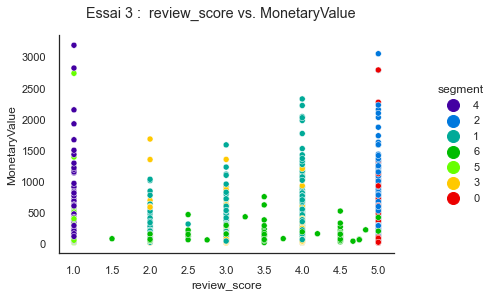

In [99]:
def plot_clusters_2D(df: pd.DataFrame, x_col=None, y_col=None, cluster_col=CLUSTER_COL, ax=None):
    """simple 2D plot of clusters, ordered by cluster order"""
    n_clusters = df[cluster_col].nunique()
    palette = sns.color_palette('nipy_spectral', n_colors=n_clusters)
    sns.scatterplot(data=df, x=x_col, y=y_col,
                    hue=cluster_col, hue_order=calc_cluster_order(df), palette=palette, ax=ax)
    sns.despine()
    plt.legend(title='segment', bbox_to_anchor=(
        1.3, 0.5), loc=5, markerscale=2)


plot_clusters_2D(client_clusters, 'review_score', 'MonetaryValue')
plt.suptitle(f'{ESSAI_3} review_score vs. MonetaryValue')


### 6.3.2 Visualisation des clusters centers via Bubble plot


Text(0.5, 0.98, 'Essai 3 :  Bubble plot')

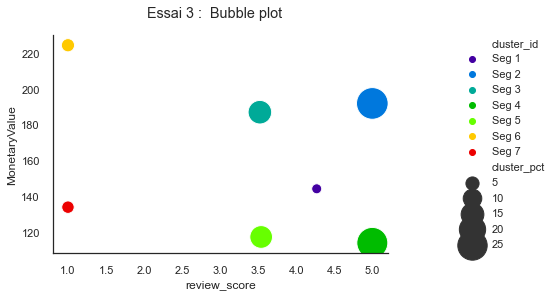

In [100]:
def plot_cluster_bubbles(df: pd.DataFrame, x_col=None, y_col=None, cluster_col=CLUSTER_COL, sizes_col='cluster_pct'):
    """Plot clusters as bubbles, in order of total score"""
    df = df.pipe(rename_cluster_labels)
    if 'MonetaryValue' in df.columns:
        hue_order = calc_cluster_order_score(df)
        palette = 'nipy_spectral'
    else:
        hue_order = sorted(list(df[cluster_col].unique()))
        palette = None
    sns.scatterplot(data=df, x=x_col, y=y_col, size=sizes_col, hue=cluster_col,
                    hue_order=hue_order, palette=palette, sizes=(100, 1000))
    sns.despine()
    plt.legend(bbox_to_anchor=(1.5, 0.5), loc=5)


plot_cluster_bubbles(client_groups, 'review_score', 'MonetaryValue')
plt.suptitle(f'{ESSAI_3} Bubble plot')


### 6.3.1 Boxplots des clusters


"MonetaryValue.png"


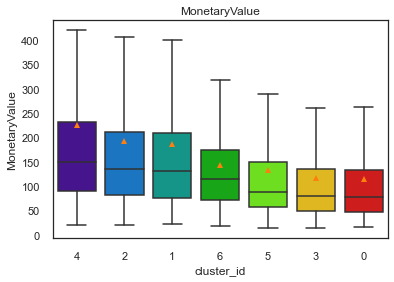

In [101]:
def plot_box_clusters(df: pd.DataFrame, y_col, cluster_col=CLUSTER_COL, ax=None):
    """Box plot comparing clusters by a given y_col"""
    if y_col in df.columns:
        ax = sns.boxplot(data=df, x=cluster_col, y=y_col, order=calc_cluster_order(df), ax=ax,
                         showfliers=False, showmeans=True, palette='nipy_spectral')
        ax.set_title(y_col)


plot_box_clusters(client_clusters, 'MonetaryValue')
to_png()


In [102]:
def plot_box_features(df: pd.DataFrame, features):
    "Boxplots comparing clusters, for each of the features"
    n_cols = 3
    n_rows = len(features) // n_cols + (len(features) % n_cols > 0)
    # n_clusters= df[CLUSTER_COL].nunique()
    _ = plt.figure(figsize=(n_cols*4, n_rows*3))
    for n, feature in enumerate(features):
        ax = plt.subplot(n_rows, n_cols, n + 1)
        plot_box_clusters(df=df, y_col=feature, ax=ax)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)


#### Box plots pour les features utilisés pour faire le clustering


"KMeans_(k=7)-_box_plots_for_clustering_features.png"


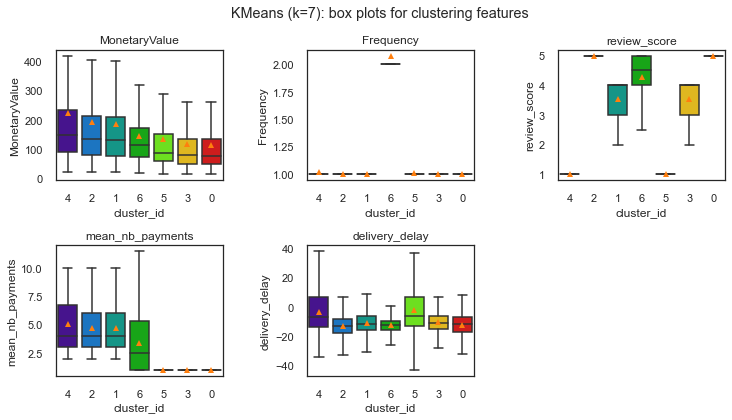

In [103]:
plot_box_features(client_clusters, FEATURES_3)
plt.suptitle('KMeans (k=7): box plots for clustering features')
to_png()

#### Box plots pour les autres features numériques

"KMeans_(k=7)-_box_plots_for_non-clustering_features.png"


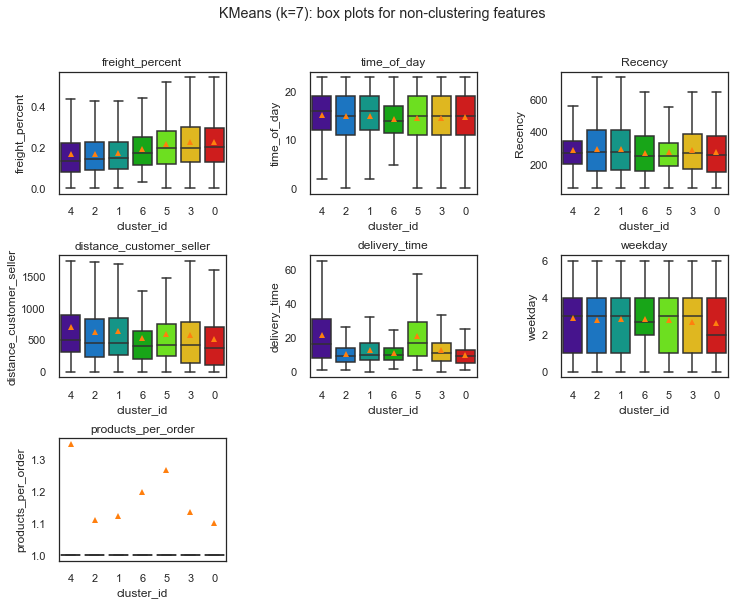

In [104]:
numerical_features= df_clients_sample.select_dtypes('number').columns 
other_features = list(set(numerical_features) - set (FEATURES_3))
plot_box_features(client_clusters, other_features)
plt.suptitle('KMeans (k=7): box plots for non-clustering features')
to_png()

## 6.4 Visualisations avancés (Snake (line) et Spider (radar) plots)

Pour voir la (dis)similarité entre clusters, les options sont :
- Snake (line) plot - toute les scores en un seul plot (peut être trop d'information)
- Spider (radar) plot - chaque cluster est répresenté sur une toile d'araignée 


### 6.4.1 Snake plots (comparison de plusieurs variables)

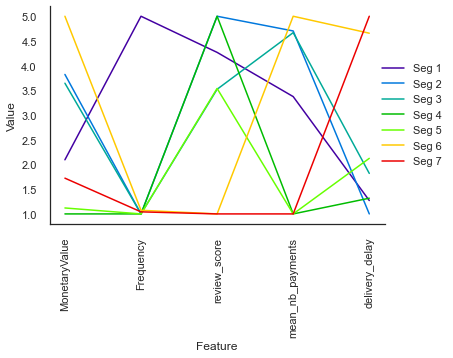

In [105]:
def plot_snake(df: pd.DataFrame, features=FEATURES, cluster_col=CLUSTER_COL):
    """Create a snake plot to compare clusters, to identify differences"""
    df_std = standard_scores(df, features).pipe(rename_cluster_labels)
    melt_cols = [*features, cluster_col]
    df_melt = pd.melt(df_std[melt_cols], [cluster_col],
                      var_name='Feature', value_name='Value')
    plt.figure()
    sns.lineplot(data=df_melt, x='Feature', y='Value',
                 hue=cluster_col, hue_order=calc_cluster_order_score(df_std),
                 palette=CLUSTER_PALETTE)
    plt.xticks(rotation=90)
    sns.despine()
    plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5)


plot_snake(client_groups, FEATURES_3)


### 6.4.2 Spider plots

Pour avoir les données au même echelle, on applique le MinMaxScalar sur les means de chaque cluster, avec un range de 1 à 5

- (n'utilise pas min = 0 : le spider devient invisible)


In [106]:
from math import pi
from matplotlib.figure import Figure
from matplotlib.projections import PolarAxes


def plot_spider(df_cluster_summary: pd.DataFrame, features=FEATURES, 
cluster_col=CLUSTER_COL, segment_labels=None):
    """
    Plot cluster summary as spider plots
    - cluster order based on 'total_score' column in cluster_summary
    Based on https://python-graph-gallery.com/390-basic-radar-chart
    """
    df_to_plot_std = standard_scores(
        df_cluster_summary, features, min_score=1, max_score=5)

    df_to_plot_std = (df_to_plot_std
                      .pipe(calc_total_score)
                      .pipe(rename_cluster_labels)
                      .sort_values(by=cluster_col)
                      .reset_index())
    
    if not segment_labels is None:
        old_labels=sorted(list(df_to_plot_std[cluster_col]))
        label_map=dict(zip(old_labels,segment_labels))
        df_to_plot_std[cluster_col]=df_to_plot_std[cluster_col].map(label_map)

    n_clusters = df_to_plot_std[cluster_col].nunique()

    color = sns.color_palette(CLUSTER_PALETTE, n_colors=n_clusters)

    # angles
    n_features = len(features)
    angles = [n / float(n_features) * 2 * pi for n in range(n_features)]
    angles += angles[:1]  # close plot

    n_cols = 4
    n_rows = n_clusters // n_cols + (n_clusters % n_cols > 0)
    fig: Figure = plt.figure(1, figsize=(n_cols*4, n_rows*4))

    segments = list(df_to_plot_std[cluster_col])
    # debug
    # print(df_to_plot_std[[cluster_col, 'cluster_pct',
    #       'total_score', 'MonetaryValue', 'Frequency']])

    for i, segment in enumerate(segments):
        ax: PolarAxes = fig.add_subplot(n_rows, n_cols, i + 1, polar=True)

        # We are going to plot the first line of the data frame.
        values = list(df_to_plot_std.loc[i][features].values)
        values += values[:1]  # repeat 1st feature to close radar plot
        pct = df_to_plot_std.loc[i]['cluster_pct']
        ax.set_title(f'{segment} ({pct:.1f} %)', color=color[i], fontdict={
                     "fontsize": 15, "fontweight": "bold"})
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)

        # Draw one axe per variable + add labels
        plt.xticks(angles[:-1], features, color="grey", size=8)
        ax.set_xticklabels(features, size=12)

        # Draw ylabels
        ax.set_rlabel_position(0)
        ax.set_rlim((0, 5))
        # r axis is a transformation of the y_axis
        # ax.set_ylim((0,5))
        ax.set_rgrids(range(1, 5))

        # Plot data
        ax.plot(angles, values, color=color[i], marker="o", lw=1, ls="solid")

        # Fill area
        ax.fill(angles, values, color=color[i], alpha=.25)
    plt.subplots_adjust(hspace=0.25, wspace=1.02)

    pct = df_to_plot_std['cluster_pct'].to_dict()
    pct = {f'seg {k}': v for k, v in pct.items()}
    # pct = pd.DataFrame({f'seg {k}': v for k, v in pct.items()})

    return pct

"k=7,_random_state=0['MonetaryValue',_'Frequency',_'review_score',_'mean_nb_payments',_'delivery_delay'].png"


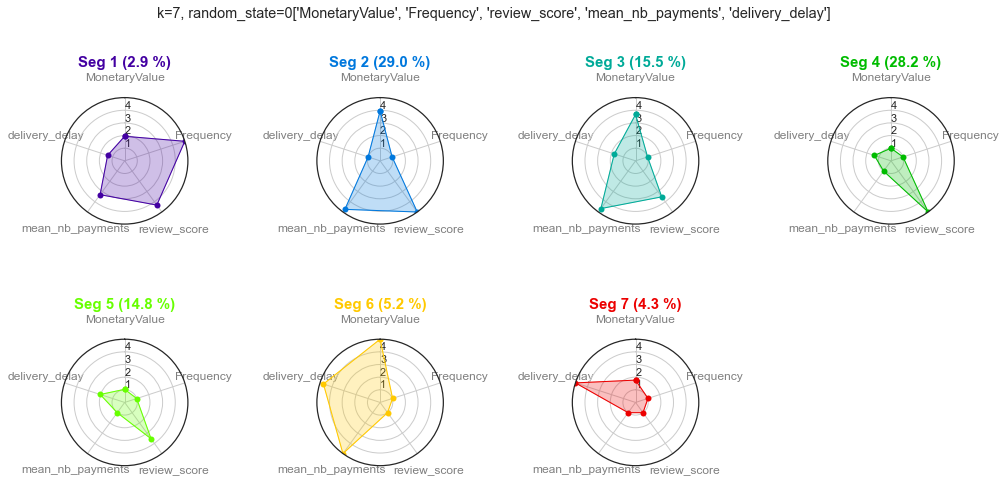

In [107]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline

def run_fit_spider(df:pd.DataFrame, features=FEATURES, model=None, k=7, 
random_state=RANDOM_SEED,segment_labels=None):
    """Run model on df[features], then plot result as spider plot"""
    if model is None:
        model = Pipeline(steps=[
            ('preprocessor', QuantileTransformer(
                output_distribution='normal', random_state=random_state)),
            ('clf', KMeans(n_clusters=k, random_state=random_state))
        ])
   # fit les clusters
    clusters_=df.copy()
    clusters_[CLUSTER_COL] = model.fit_predict(df[features])
    cluster_groups_ = group_clusters(clusters_)
    pct = plot_spider(cluster_groups_, features, segment_labels=segment_labels)
    preprocessor = model.named_steps['preprocessor']
    clf = model.named_steps['clf']
    metr = get_metrics(clusters_, features, preprocessor, clf)
    titre = f'k={k}, random_state={random_state}'
    plt.suptitle(f'{titre}{features}')
    return dict(**metr, **{'pct':pct})


run_fit_spider(df_clients, FEATURES_3, k=7)
to_png()

"k=7,_random_state=0['MonetaryValue',_'Frequency',_'review_score',_'mean_nb_payments',_'Recency'].png"


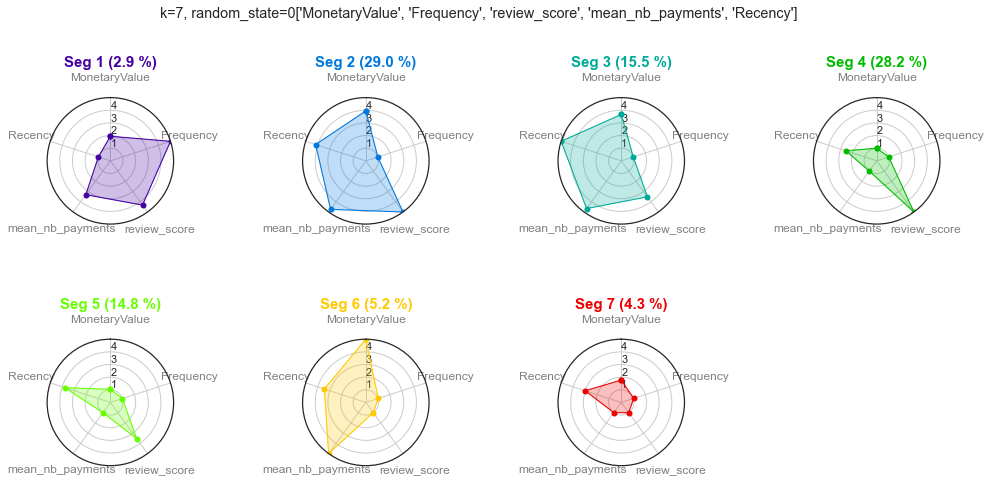

In [108]:
run_fit_spider(df_clients, FEATURES_5, k=7)
to_png()

In [109]:
def find_segments(df: pd.DataFrame, features):
    """Fine tuning k for features by checking stability of spider plots for several random states """
    scores = pd.DataFrame({})
    for k in range(4, 7):
        for i in range(0, 5):
            m, p = run_fit_spider(df, features, k=k, random_state=i)
            scores = scores.append(
                dict(**dict(random_state=i), **dict(m), **dict(p)), ignore_index=True)
            titre = f'k={k}, random_state={i}'
            plt.suptitle(f'{titre}\n{m}')
            to_png(titre)
            plt.show()
    return scores

# scors=find_segments(df_clients, FEATURES_3)
# scors.to_csv('df_scores.csv')


"k=6,_random_state=0['MonetaryValue',_'Frequency',_'review_score',_'mean_nb_payments',_'delivery_delay'].png"


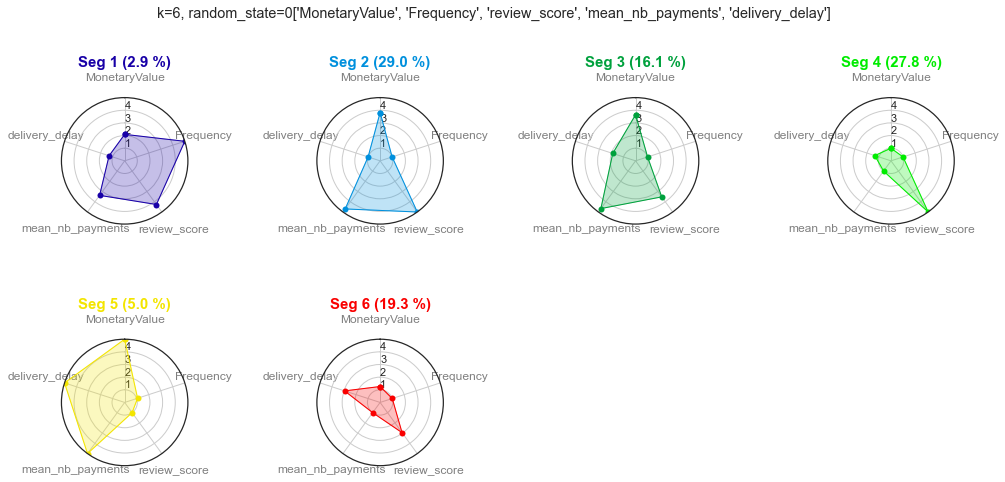

In [110]:
run_fit_spider(df_clients_sample, FEATURES_3, k=6)
to_png()

## 6.5 Visualisation des points sur des composants principaux


pca feature labels : ['Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score', 'delivery_time', 'delivery_delay', 'distance_customer_seller', 'freight_percent', 'time_of_day', 'weekday', 'products_per_order']


Text(0.5, 0.98, 'Essai 3 :  Visualisation sur Composants Principales')

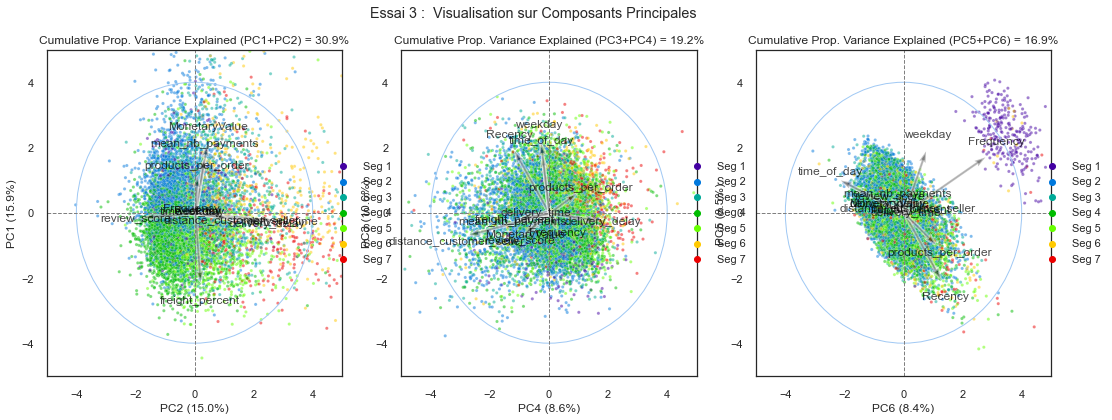

In [111]:
df = client_clusters.pipe(rename_cluster_labels)
plot_clusters_on_pca(df, axis_ranks=[(0, 1), (2, 3), (4, 5)])
plt.suptitle(f'{ESSAI_3} Visualisation sur Composants Principales')


## 6.6 Visualisations t-SNE (et autres comme UMAP)

La calculation t-SNE prend beaucoup de temps. On fait avec un échantillon de 5000 points aléatoires pour répresenter les groups

### Hyperparamètres de t-SNE:

La **perplexity** est une mesure de nombre de neighbours qui attire chaque point

- si on met perplexity trop pétit, on favorise l'information local, donc la sortie est avecbeaucoup de petit groupes
- avec un perplexity > 30, on a tendance a prend plus de voisins en compte, favorisant l'information global

La valeur de perplexity a choisir dépend du **nombre de points**, le **preprocessing** avant t-SNE, et la nombre de clusters qu'on cherche

Donc, on met perplexity, sample_size, preprocessor comme (hyper)parametres

- <https://stats.stackexchange.com/questions/399868/why-does-larger-perplexity-tend-to-produce-clearer-clusters-in-t-sne>
- <https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6>


"Essai_3_-__t-SNE_Visualisation_des_clusters_-_Quantile(uniform).png"


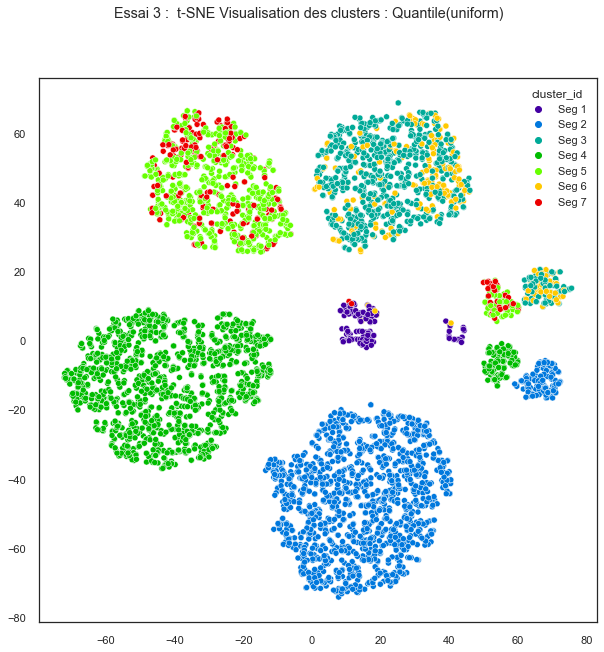

In [112]:
from sklearn.manifold import TSNE

pre_quant_uniform = QuantileTransformer(
    output_distribution='uniform', random_state=RANDOM_SEED)
pre_quant_normal = QuantileTransformer(
    output_distribution='normal', random_state=RANDOM_SEED)


def calc_tsne(df: pd.DataFrame, preprocessor=pre_quant_uniform, cluster_col=CLUSTER_COL,
              sample_size=5000, perplexity=30, random_state=RANDOM_SEED):
    """Calculate une visualisation de données basé sur preprocessing """
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('tsne', TSNE(n_components=2, perplexity=perplexity,
         verbose=0, init='pca', random_state=random_state))
    ])
    sample_size = min(sample_size, len(df))
    df_sample = df.sample(sample_size, random_state=random_state)
    if cluster_col in df_sample:
        df_sample[cluster_col] = df[cluster_col].astype('category')
    tsne = model.fit_transform(df_sample.select_dtypes('number'))
    return df_sample, tsne


def plot_tsne(df: pd.DataFrame, tsne, hue_col=CLUSTER_COL):
    """
    Visualise les clusters sur les premier 2 components d'un tSNE déjà calculé 
    """
    if hue_col==CLUSTER_COL:
        hue_order = calc_cluster_order_score(df, cluster_col=hue_col)
    else:
        hue_order=None
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1],
                    hue=df[hue_col].astype(str), hue_order=hue_order, palette='nipy_spectral')


def run_fit_plot_tsne(df: pd.DataFrame, preprocessor=pre_quant_uniform,
                      cluster_col=CLUSTER_COL, hue_col=CLUSTER_COL,
                      sample_size=5000, perplexity=30, random_state=RANDOM_SEED):
    """
    Fit t-SNE, puis visualise les clusters sur les premier 2 components du tSNE 
    """
    sample_df, tsne = calc_tsne(
        df, preprocessor, cluster_col, sample_size, perplexity, random_state)
    plot_tsne(sample_df, tsne, hue_col)
    return sample_df, tsne


sample_df, tsne = run_fit_plot_tsne(client_clusters.pipe(
    rename_cluster_labels), preprocessor=pre_quant_uniform)
plt.suptitle(f'{ESSAI_3} t-SNE Visualisation des clusters : Quantile(uniform)')
to_png()


In [113]:
sample_df.head()


customer_unique_id       dernier_achat  Frequency  \
15014  296d0b2c6acccdf4d6727b20e1f9f4a2 2018-06-24 16:36:52          1   
14891  290b9cb882e7c0f2f5fa1cc30941e4bb 2017-09-22 00:12:54          1   
59393  a3e0645de7adef05c1ed21b997efa4c3 2017-11-20 10:59:08          1   
23494  40bdad7aea3ed7f260960ef2ab0cc60b 2017-11-27 20:53:18          1   
26449  48dbc2b0bdf7180cc3b7cd4a9ef87fb7 2018-02-14 22:32:54          1   

       MonetaryValue  Recency  mean_nb_payments  review_score  delivery_time  \
15014         101.86      114              1.00          5.00          17.00   
14891          97.71      390              9.00          5.00          21.00   
59393         103.55      331              1.00          5.00           8.00   
23494         145.56      323              1.00          5.00          30.00   
26449         440.19      244              8.00          5.00           5.00   

       delivery_delay  distance_customer_seller  freight_percent payment_mode  \
15014           -6.00                     36.94             0.09       boleto   
14891           -4.00                    540.02             0.18  credit_card   
59393           -9.00                    158.03             0.13  credit_card   
23494            0.00                    716.49             0.11  credit_card   
26449          -23.00                    923.66             0.05  credit_card   

      favourite_category customer_state favourite_seller_state  time_of_day  \
15014    diy_garden_auto             SP                     SP        16.00   
14891            fashion             MG                     SP         0.00   
59393    diy_garden_auto             SP                     SP        10.00   
23494            leisure             RS                     PR        20.00   
26449      health_parfum             SP                     RS        22.00   

       weekday  products_per_order outlier cluster_id cluster_id_bak  
15014     6.00                2.00      no      Seg 4              0  
14891     4.00                1.00      no      Seg 2              2  
59393     0.00                1.00      no      Seg 4              0  
23494     0.00                1.00      no      Seg 4              0  
26449     2.00                1.00      no      Seg 2              2

"Essai_3_-__(t-SNE_Visualisation_de_(k=7)_clusters_(Quantile(normal)).png"


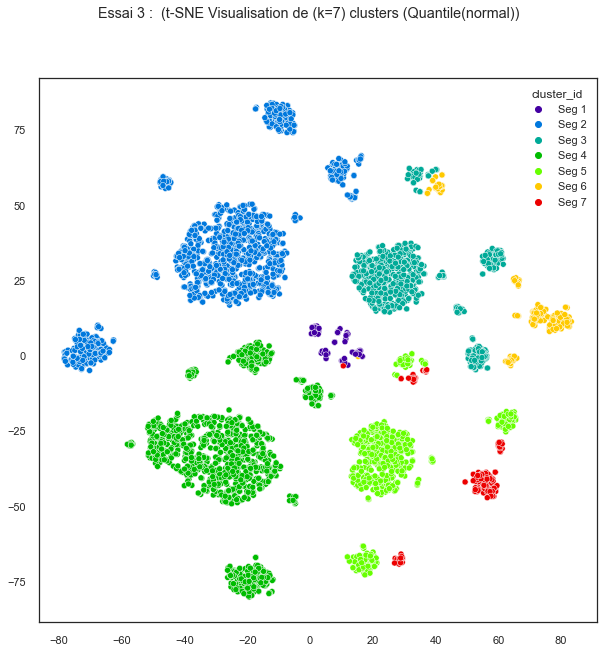

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans

k_choix = 7
# pre_quant_normal = QuantileTransformer(
#     output_distribution='normal', random_state=RANDOM_SEED)
# model_kmeans_quant_normal = Pipeline(steps=[
#     ('preprocessor', pre_quant_normal),
#     ('clf', KMeans(n_clusters=7, init='k-means++', random_state=RANDOM_SEED))
# ])

clusters_quant_normal, _ = run_fit_model(
    df_clients, model_kmeans_quant_normal, k=k_choix)
sample_df, tsne = run_fit_plot_tsne(
    clusters_quant_normal.pipe(rename_cluster_labels), pre_quant_normal)
plt.suptitle(
    f'{ESSAI_3} (t-SNE Visualisation de (k={k_choix}) clusters (Quantile(normal))')

to_png()


"Essai_3_-__t-SNE_Visualisation_de_(k=7)_clusters_fit_quantile(normal),_visual_(Quantile(uniform)).png"


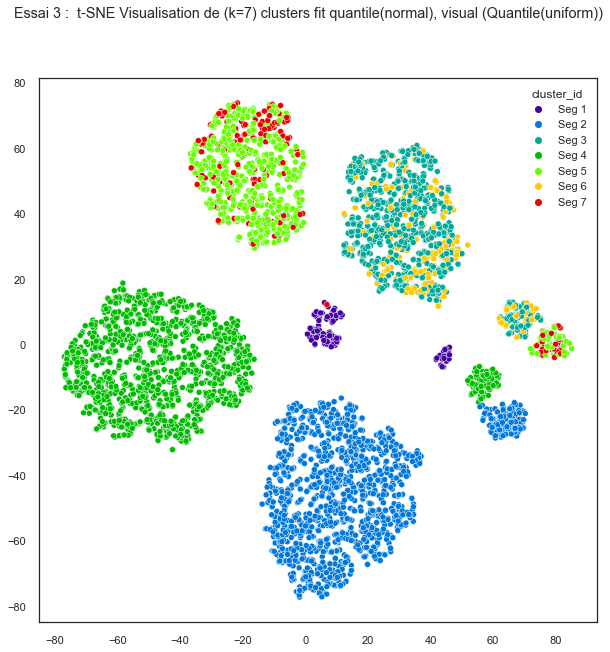

In [115]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
k_choix = 7

pre_quant_uniform = QuantileTransformer(
    output_distribution='uniform', random_state=RANDOM_SEED)
model_kmeans_quant_uniform = Pipeline(steps=[
    ('preprocessor', pre_quant_uniform),
    ('clf', KMeans(n_clusters=k_choix, random_state=RANDOM_SEED))
])

clusters_quant_normal, _ = run_fit_model(
    df_clients, model_kmeans_quant_normal, k=k_choix)
sample_df, tsne = run_fit_plot_tsne(clusters_quant_normal.pipe(rename_cluster_labels), pre_quant_uniform)
plt.suptitle(
    f'{ESSAI_3} t-SNE Visualisation de (k={k_choix}) clusters fit quantile(normal), visual (Quantile(uniform))')

to_png()


In [116]:
sample_df.columns

Index(['customer_unique_id', 'dernier_achat', 'Frequency', 'MonetaryValue',
       'Recency', 'mean_nb_payments', 'review_score', 'delivery_time',
       'delivery_delay', 'distance_customer_seller', 'freight_percent',
       'payment_mode', 'favourite_category', 'customer_state',
       'favourite_seller_state', 'time_of_day', 'weekday',
       'products_per_order', 'outlier', 'cluster_id', 'cluster_id_bak'],
      dtype='object')

"Essai_3_-__t-SNE_Visualisation_de_(k=7)_clusters_fit_quantile(normal),_visual_(payment_mode).png"


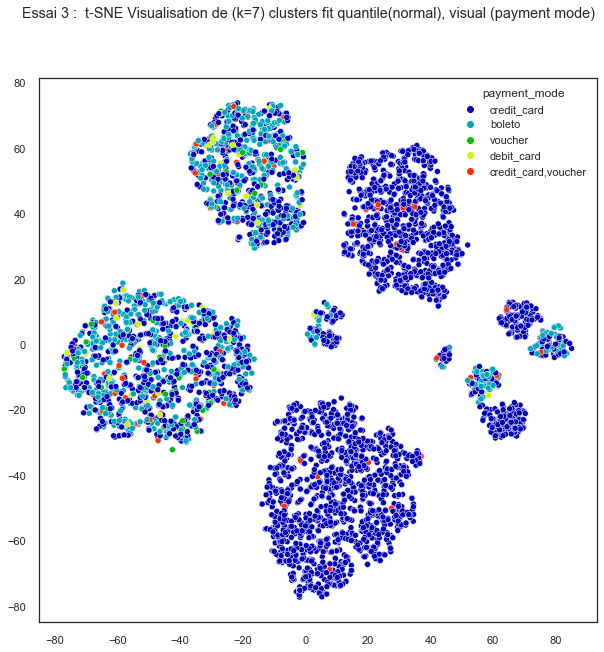

In [117]:
# clusters_quant_normal, _=run_fit_model(df_clients,model_kmeans_quant_normal,k=k_choix)
clusters_quant_normal, _ = run_fit_model(
    df_clients, model_kmeans_quant_normal, k=k_choix)
sample_df, tsne = run_fit_plot_tsne(
    clusters_quant_normal.pipe(rename_cluster_labels), pre_quant_uniform, hue_col='payment_mode')
plt.suptitle(
    f'{ESSAI_3} t-SNE Visualisation de (k={k_choix}) clusters fit quantile(normal), visual (payment mode)')

to_png()


In [118]:
clusters_quant_normal.columns


Index(['customer_unique_id', 'dernier_achat', 'Frequency', 'MonetaryValue',
       'Recency', 'mean_nb_payments', 'review_score', 'delivery_time',
       'delivery_delay', 'distance_customer_seller', 'freight_percent',
       'payment_mode', 'favourite_category', 'customer_state',
       'favourite_seller_state', 'time_of_day', 'weekday',
       'products_per_order', 'outlier', 'cluster_id'],
      dtype='object')

"Essai_3_-__t-SNE_Visualisation_de_(k=7)_clusters_fit_quantile(normal),_al_(Quantile(uniform)).png"


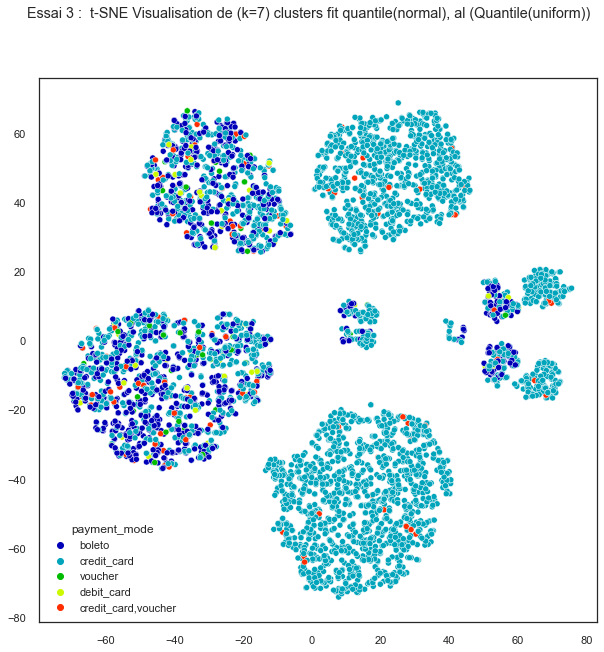

In [119]:
# run_fit_plot_tsne(clusters_quant_normal, pre_quant_uniform, cluster_col='payment_mode',hue_col='payment_mode')
run_fit_plot_tsne(client_clusters, pre_quant_uniform, hue_col='payment_mode')
plt.suptitle(
    f'{ESSAI_3} t-SNE Visualisation de (k={k_choix}) clusters fit quantile(normal), al (Quantile(uniform))')

to_png()


"Essai_3_-__t-SNE_Visualisation_des_clusters_(Quantile(normal)_+_PCA).png"


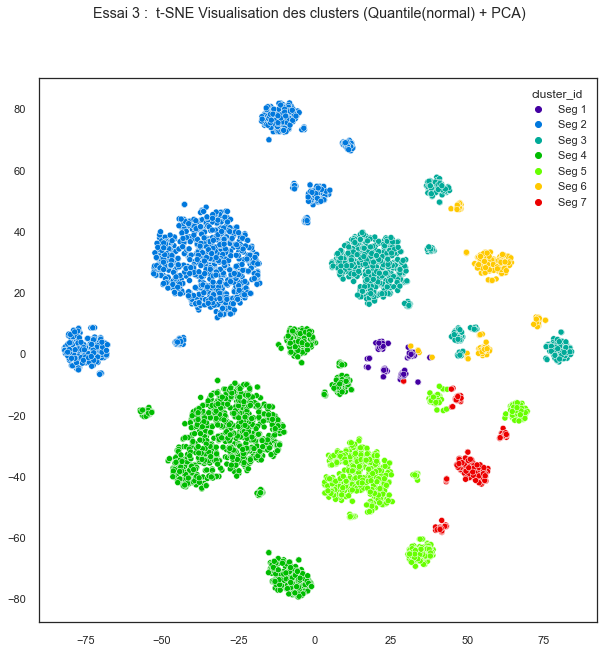

In [120]:
pre_quant_pca = Pipeline(steps=[
    ('scale', QuantileTransformer(
        output_distribution='normal', random_state=RANDOM_SEED)),
    ('pca', PCA())
])
model_kmeans_quant_pca = Pipeline(steps=[
    ('preprocessor', pre_quant_pca),
    ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
])

clusters_quant_pca, _ = run_fit_model(
    df_clients, model_kmeans_quant_uniform, k=k_choix)
run_fit_plot_tsne(client_clusters.pipe(rename_cluster_labels), preprocessor=pca_preprocessor)
plt.suptitle(
    f'{ESSAI_3} t-SNE Visualisation des clusters (Quantile(normal) + PCA)')

to_png()


"Essai_3_-__t-SNE_Favourite_category_de_(k=7)_clusters_fit_quantile(normal),_fav_categ).png"


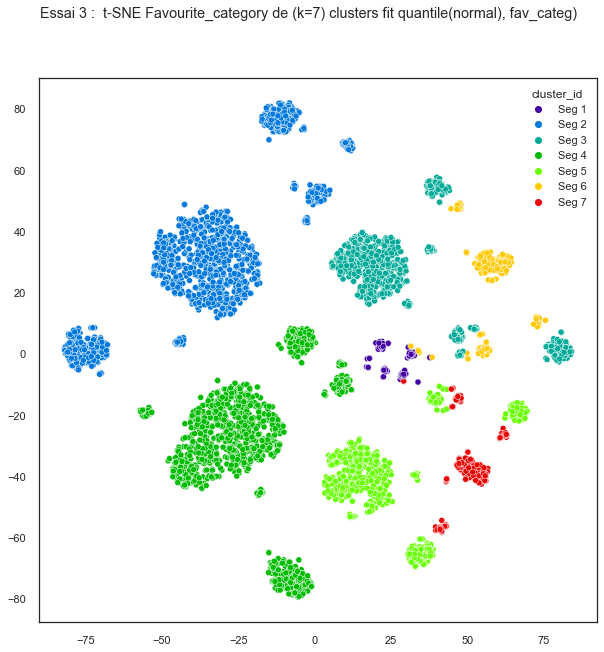

In [121]:
run_fit_plot_tsne(client_clusters.pipe(rename_cluster_labels), pca_preprocessor,
                  cluster_col='favourite_category')
plt.suptitle(
    f'{ESSAI_3} t-SNE Favourite_category de (k={k_choix}) clusters fit quantile(normal), fav_categ)')

to_png()


In [122]:
client_clusters.columns


Index(['customer_unique_id', 'dernier_achat', 'Frequency', 'MonetaryValue',
       'Recency', 'mean_nb_payments', 'review_score', 'delivery_time',
       'delivery_delay', 'distance_customer_seller', 'freight_percent',
       'payment_mode', 'favourite_category', 'customer_state',
       'favourite_seller_state', 'time_of_day', 'weekday',
       'products_per_order', 'outlier', 'cluster_id'],
      dtype='object')

"Essai_3_-__t-SNE_Visualisation_des_clusters_(MinMaxScaler).png"


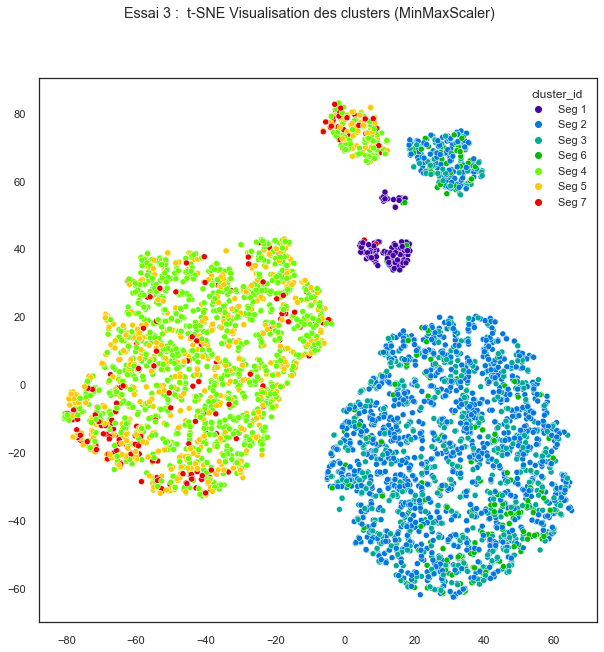

In [123]:
run_fit_plot_tsne(client_clusters.pipe(rename_cluster_labels), cluster_col='review_score')
plt.suptitle(f'{ESSAI_3} t-SNE Visualisation des clusters (MinMaxScaler)')

to_png()


On essaie plusieurs preprocessors


"Essai_3_-__t-SNE_Visualisation_des_clusters_(uniform).png"


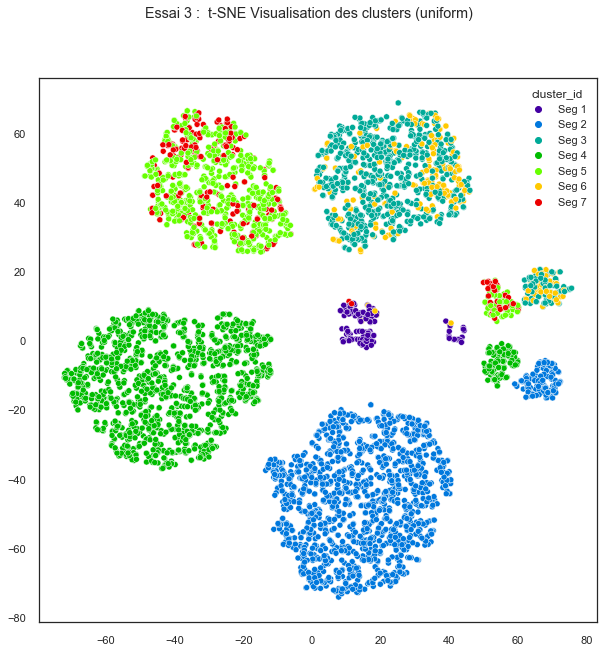

In [124]:
run_fit_plot_tsne(client_clusters.pipe(rename_cluster_labels), pre_quant_uniform)
plt.suptitle(f'{ESSAI_3} t-SNE Visualisation des clusters (uniform)')

to_png()


On voit que les clusters segment les clients de la façon suivant :

- 0 : haut valeur
- 1 : bas valeur, pas tres récent
- 2 : clients fréquents
- 3 : bas valeur, clients récents


Les clusters ci-dessus sont plus difficile à distinguer entre eux

- On peut mieux visualizer sur les premiers 2 principaux components de PCA ou t-SNE


## 7 Interpretation des clusters

On utilise les visualisations pour interpreter les résultats de chaque modèle.


In [125]:
def run_kmeans_labels(df: pd.DataFrame, n_clusters=k_best):
    """Shortcut to run Kmeans repeatedly for k clusters"""
    df = df.copy()
    if 'cluster_label' in df.columns:
        df = df.drop(columns='cluster_label')
    model = Pipeline(steps=[
        ('preprocessor', quantile_transformer),
        ('clf', KMeans(n_clusters=n_clusters))
    ])
    model.fit(df)
    clf = model.named_steps['clf']
    df['cluster_label'] = clf.labels_
    return df


clients_rfm_scaled = df_clients_sample[FEATURES_3].pipe(run_kmeans_labels, n_clusters=7)

clients_rfm_scaled.groupby('cluster_label').mean()


MonetaryValue  Frequency  review_score  mean_nb_payments  \
cluster_label                                                             
0                     224.52       1.02          1.00              5.03   
1                     113.91       1.00          5.00              1.00   
2                     191.96       1.00          5.00              4.73   
3                     117.23       1.00          3.54              1.00   
4                     187.04       1.00          3.52              4.70   
5                     144.19       2.08          4.27              3.39   
6                     133.91       1.01          1.00              1.00   

               delivery_delay  
cluster_label                  
0                       -3.24  
1                      -12.45  
2                      -13.33  
3                      -10.23  
4                      -11.07  
5                      -12.58  
6                       -2.29

### Essai 4 : Trouver les meilleurs indicateurs pour une segmentation en 8 clusters


In [126]:
from sklearn.metrics import silhouette_score, davies_bouldin_score


def find_best_features(data, k_range=range(2, 9), maxvars=8,
                       sample_size=5000, scoring='silhouette', kmeans_kwargs=dict()):
    if CLUSTER_COL in data.columns:
        data = data.drop(CLUSTER_COL, axis=1)
    num_cols = data.select_dtypes('number').columns
    scaler = QuantileTransformer(output_distribution='normal')
    df = pd.DataFrame(scaler.fit_transform(data[num_cols].sample(
        sample_size, random_state=RANDOM_SEED)), columns=num_cols)

    results_for_each_k = []
    vars_for_each_k = {}
    # output: heatmap of k in rows, n_var in columns, score as value
    # select best silhouette score for each k
    best_scores_df = pd.DataFrame(
        [], columns={'k', 'n_var', 'score', 'best_vars'})
    all_scores_df = pd.DataFrame([], columns={'k', 'n_var'})
    for k in k_range:

        selected_variables = []
        cols = list(df.columns)
        results = []
        while len(selected_variables) < maxvars:
            results = []
            for col in cols:
                # keep feature with best silhouette/davies_bouldin score, try each remaining column
                scols = [*selected_variables, *[col]]
                clf = KMeans(
                    n_clusters=k, random_state=RANDOM_SEED, **kmeans_kwargs)
                clf.fit(df[scols])
                scores = dict(
                    k=k,
                    n_var=len(scols),
                    cols=[*scols],
                    inertia=getattr(clf, 'inertia_', np.NaN),
                    davies_bouldin=davies_bouldin_score(
                        df[scols], clf.labels_),
                    silhouette=silhouette_score(df[scols], clf.labels_)
                )
                all_scores_df = all_scores_df.append(scores, ignore_index=True)
                if scoring == 'silhouette':
                    score = scores['silhouette']
                else:
                    score = scores['davies_bouldin']
                results.append(score)

            if scoring == 'silhouette':
                selected_var = cols[np.argmax(results)]
                best_score = np.max(results)
            else:
                # davies_bouldin
                selected_var = cols[np.argmin(results)]
                best_score = np.min(results)

            selected_variables.append(selected_var)
            best_result = {'k': k, 'n_var': len(
                selected_variables), 'score': best_score, 'best_vars': [*selected_variables]}
            best_scores_df = best_scores_df.append(
                best_result, ignore_index=True)
            cols.remove(selected_var)
        if scoring == 'silhouette':
            results_for_each_k.append(max(results))
        else:
            results_for_each_k.append(min(results))
        print(f'k={k} : variables = {selected_variables}')
        vars_for_each_k[k] = selected_variables

    if scoring == 'silhouette':
        best_k_ = np.argmax(results_for_each_k)+min(k_range)
    else:
        best_k_ = np.argmin(results_for_each_k)+min(k_range)
    # you can also force a value for k
    # best_k=3
    selected_variables = vars_for_each_k[best_k_]
    return best_k_, selected_variables, best_scores_df, all_scores_df


### Analyse des categories sur les clusters


"Distribution_de_'favourite_category'_by_segment.png"


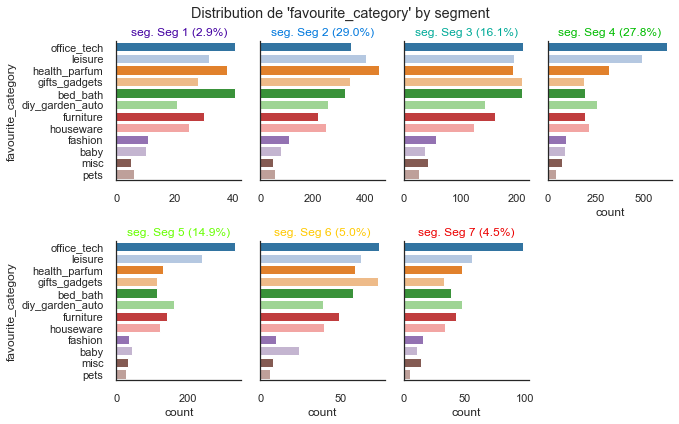

In [127]:
def plot_categ_by_cluster(df, categ_col='favourite_category', cluster_col=CLUSTER_COL):
    df=df.pipe(rename_cluster_labels)
    cluster_groups_ = group_clusters(df)
    cluster_groups_.index = cluster_groups_[CLUSTER_COL].rename('index')
    categ_order = None
    if categ_col in df.select_dtypes('object'):
        categ_order = df[categ_col].value_counts().index
    else:
        categ_order = sorted(df[categ_col].unique(), reverse=True)
    cluster_order = calc_cluster_order_score(df)
    g = sns.catplot(data=df, y=categ_col, order=categ_order,
                    col=CLUSTER_COL, col_order=cluster_order, col_wrap=4,
                    kind="count", height=3, aspect=.8, sharex=False)
    dic = g.axes_dict
    colors = sns.color_palette(CLUSTER_PALETTE, n_colors=len(cluster_groups_))
    i = 0
    for key, ax in g.axes_dict.items():
        ax.set_title(
            f"seg. {key} ({cluster_groups_.loc[key,'cluster_pct']:.1f}%)", color=colors[i])
        i = i+1
    plt.subplots_adjust(top=0.9)
    plt.suptitle(f"Distribution de '{categ_col}' by segment")


plot_categ_by_cluster(client_clusters)
to_png()


"Distribution_de_'payment_mode'_by_segment.png"


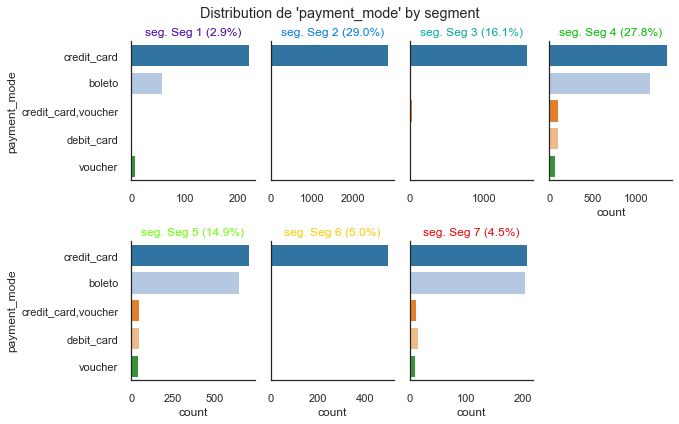

In [128]:
plot_categ_by_cluster(client_clusters, 'payment_mode')
to_png()


"Distribution_de_'review_score'_by_segment.png"


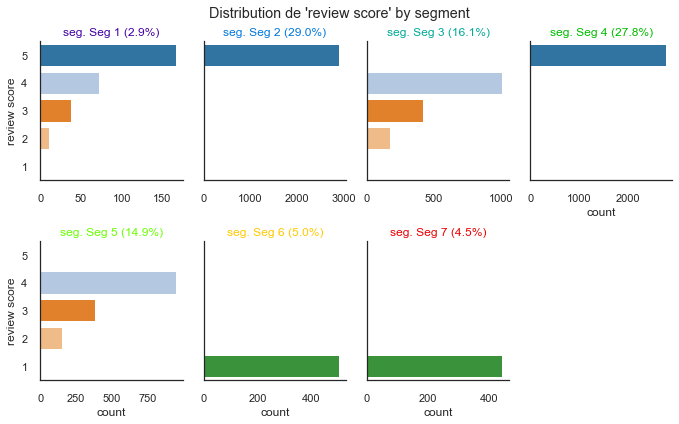

In [129]:
client_clusters['review score'] = pd.cut(client_clusters['review_score'], bins=[
                                          0, 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5]).astype(int)
plot_categ_by_cluster(client_clusters, 'review score')
to_png()


In [130]:
cluster_groups_ = group_clusters(client_clusters)
cluster_groups_.index = cluster_groups_[CLUSTER_COL].rename('')
cluster_groups_


cluster_id  cluster_size  cluster_pct  Frequency  MonetaryValue  Recency  \
                                                                             
4          4           503         5.03       1.02         224.52   287.01   
2          2          2897        28.97       1.00         191.96   291.55   
1          1          1605        16.05       1.00         187.04   294.48   
6          6           288         2.88       2.08         144.19   271.92   
5          5           445         4.45       1.01         133.91   277.09   
3          3          1486        14.86       1.00         117.23   286.53   
0          0          2776        27.76       1.00         113.91   274.17   

   mean_nb_payments  review_score  delivery_time  delivery_delay  \
                                                                   
4              5.03          1.00          21.23           -3.24   
2              4.73          5.00          10.41          -13.33   
1              4.70          3.52          12.92          -11.07   
6              3.39          4.27          11.10          -12.58   
5              1.00          1.00          21.16           -2.29   
3              1.00          3.54          12.58          -10.23   
0              1.00          5.00           9.81          -12.45   

   distance_customer_seller  freight_percent  time_of_day  weekday  \
                                                                     
4                    704.42             0.16        15.14     2.91   
2                    632.40             0.17        14.99     2.80   
1                    644.50             0.17        15.02     2.83   
6                    525.35             0.19        14.24     2.83   
5                    593.43             0.22        14.61     2.77   
3                    575.72             0.23        14.50     2.70   
0                    513.33             0.22        14.75     2.65   

   products_per_order  review score                customer_unique_id  \
                                                                        
4                1.35          1.00  702843d007357400ece1b13cc1126fd8   
2                1.11          5.00  ab02f0c74cc456efdfffc308caee4e6b   
1                1.12          3.52  6747f33f8d299d4c360c6ead53bc3e71   
6                1.20          4.37  897ecc46977d723a6e514f3ebe92c844   
5                1.27          1.00  d26795e02bb7290f41bb487ef48d6e2e   
3                1.13          3.54  bee8c71dfec2314e63b7ef0e2ce70bdd   
0                1.10          5.00  4c29ad3f71e71c31c6e2a860330cc9a8   

  payment_mode favourite_category customer_state favourite_seller_state  \
                                                                          
4  credit_card        office_tech             SP                     SP   
2  credit_card      health_parfum             SP                     SP   
1  credit_card        office_tech             SP                     SP   
6  credit_card           bed_bath             SP                     SP   
5  credit_card        office_tech             SP                     SP   
3  credit_card        office_tech             SP                     SP   
0  credit_card        office_tech             SP                     SP   

  outlier  
           
4      no  
2      no  
1      no  
6      no  
5      no  
3      no  
0      no

### Conclusion sur KMeans model selectionné
---

# 8. Autres méthodes de clustering

On va essaie

- Agglomerative Clustering (Clustering Hiérarchique)
- DBSCAN
- Kprototype 

References

- <https://scikit-learn.org/stable/modules/clustering.html>


## 8.1 Agglomerative Clustering (Clustering Hiérarchique)


In [131]:
from scipy.cluster.hierarchy import dendrogram, linkage
sample_size = min(10000, len(df_clients))
df_clients_sample = df_clients.sample(sample_size, random_state=RANDOM_SEED)
Z = linkage(df_clients_sample.select_dtypes('number'), 'ward')


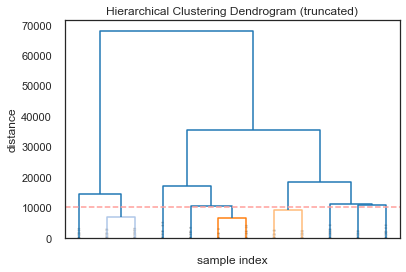

In [132]:

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    color_threshold=10000,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(10000, c='r', ls='--')
plt.show()


In [133]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(clf:AgglomerativeClustering, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

    # create the counts of samples under each node
    counts = np.zeros(clf.children_.shape[0])
    n_samples = len(clf.labels_)
    for i, merge in enumerate(clf.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [clf.children_, clf.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [134]:
def filtered_dict(d, filter_string):
    result = {k: v for (k, v) in d.items() if filter_string in k}
    return result


def get_named_step_params(pipeline, named_step):
    params_ = pipeline.get_params()
    return filtered_dict(params_, named_step)


In [135]:
from sklearn.cluster import AgglomerativeClustering

# agglomerative clustering est rélativement lent, on réduit le taille d'echantillon 
sample_size = min(10000, len(df_clients))
df_clients_sample = df_clients.sample(sample_size, random_state=RANDOM_SEED)

model_cah = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(
        output_distribution='normal', random_state=RANDOM_SEED)),
    # setting distance_threshold=0 ensures we compute the full tree.
    # ('clf', AgglomerativeClustering(n_clusters=None, distance_threshold=0))
    ('clf', AgglomerativeClustering(compute_distances=True))
])
print(get_named_step_params(model_cah, 'clf'))


{'clf': AgglomerativeClustering(compute_distances=True), 'clf__affinity': 'euclidean', 'clf__compute_distances': True, 'clf__compute_full_tree': 'auto', 'clf__connectivity': None, 'clf__distance_threshold': None, 'clf__linkage': 'ward', 'clf__memory': None, 'clf__n_clusters': 2}


In [136]:
df_clients_sample.select_dtypes('number').columns


Index(['Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments',
       'review_score', 'delivery_time', 'delivery_delay',
       'distance_customer_seller', 'freight_percent', 'time_of_day', 'weekday',
       'products_per_order'],
      dtype='object')

In [137]:
param_grid = {
    'clf__linkage': ['single', 'average', 'complete', 'ward'],
    'clf__n_clusters': range(4, 9)
}
scores_cah = score_model(
    df=df_clients_sample[FEATURES_3], model=model_cah, param_grid=param_grid)
scores_cah.sort_values(by='silhouette_score', ascending=False).head()


params={'clf__linkage': 'single', 'clf__n_clusters': 4}; k=4; cluster_sizes=[57, 40, 2, 1]
params={'clf__linkage': 'single', 'clf__n_clusters': 5}; k=5; cluster_sizes=[57, 21, 19, 2, 1]
params={'clf__linkage': 'single', 'clf__n_clusters': 6}; k=6; cluster_sizes=[29, 28, 21, 19, 2, 1]
params={'clf__linkage': 'single', 'clf__n_clusters': 7}; k=7; cluster_sizes=[29, 28, 21, 19, 2, 1, 0]
params={'clf__linkage': 'single', 'clf__n_clusters': 8}; k=8; cluster_sizes=[29, 28, 21, 19, 1, 1, 1, 0]
params={'clf__linkage': 'average', 'clf__n_clusters': 4}; k=4; cluster_sizes=[57, 40, 2, 1]
params={'clf__linkage': 'average', 'clf__n_clusters': 5}; k=5; cluster_sizes=[57, 21, 19, 2, 1]
params={'clf__linkage': 'average', 'clf__n_clusters': 6}; k=6; cluster_sizes=[57, 21, 19, 2, 1, 0]
params={'clf__linkage': 'average', 'clf__n_clusters': 7}; k=7; cluster_sizes=[57, 21, 19, 1, 1, 1, 0]
params={'clf__linkage': 'average', 'clf__n_clusters': 8}; k=8; cluster_sizes=[29, 28, 21, 19, 1, 1, 1, 0]
params={'clf_

davies_bouldin  silhouette_time  calinski_harabasz         preprocessor  \
19            0.74             1.99           14034.43  QuantileTransformer   
18            0.66             1.99           14656.67  QuantileTransformer   
4             0.55             1.43            8862.97  QuantileTransformer   
14            1.05             2.31            8851.55  QuantileTransformer   
17            0.69             2.01           13439.31  QuantileTransformer   

    silhouette_score                      clf silhouette_sample_sizes  \
19              0.67  AgglomerativeClustering                    2000   
18              0.66  AgglomerativeClustering                    2000   
4               0.65  AgglomerativeClustering                    2000   
14              0.64  AgglomerativeClustering                    2000   
17              0.64  AgglomerativeClustering                    2000   

    silhouette_score_std  k clf__linkage  clf__n_clusters  \
19                  0.00  8         ward             8.00   
18                  0.00  7         ward             7.00   
4                   0.00  8       single             8.00   
14                  0.01  8     complete             8.00   
17                  0.00  6         ward             6.00   

                   cluster_sizes  fit time (s)  stability_sample_sizes  \
19  [29, 28, 16, 15, 5, 4, 2, 1]          3.44                10000.00   
18     [29, 28, 16, 15, 5, 4, 3]          3.47                10000.00   
4   [29, 28, 21, 19, 1, 1, 1, 0]          0.96                10000.00   
14  [29, 28, 21, 11, 8, 2, 1, 0]          4.50                10000.00   
17        [29, 28, 19, 16, 5, 3]          3.49                10000.00   

    stability_score  stability_score_std  stability_time  
19             1.00                 0.00           33.46  
18             1.00                 0.00           36.57  
4              1.00                 0.00           11.38  
14             1.00                 0.00           33.98  
17             1.00                 0.00           34.03

Les meilleurs scores sont avec linkage Ward, avec k=7


{'clf': AgglomerativeClustering(compute_distances=True, n_clusters=7), 'clf__affinity': 'euclidean', 'clf__compute_distances': True, 'clf__compute_full_tree': 'auto', 'clf__connectivity': None, 'clf__distance_threshold': None, 'clf__linkage': 'ward', 'clf__memory': None, 'clf__n_clusters': 7}
['0', '1', '2', '3', '4', '5', '6']
"Agglomerative_clustering,_(linkage_'Ward',_k=7).png"


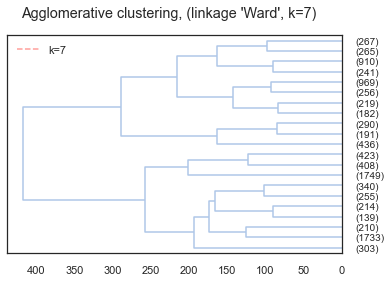

In [138]:
def run_agglomerative(df: pd.DataFrame, model=model_cah, n_clusters=7, linkage='ward', color_threshold=10000):
    df=df.select_dtypes('number').copy()
    params = {'clf__linkage': linkage, 'clf__n_clusters': n_clusters}
    model.set_params(**params)
    print(get_named_step_params(model, 'clf'))
    model.fit(df)
    clf: AgglomerativeClustering = model.named_steps['clf']

    plot_dendrogram(clf=clf, truncate_mode="lastp", p=n_clusters*3, orientation='left',
                    color_threshold=color_threshold)
    plt.axvline(color_threshold, c='r', ls='--', label=f'k={n_clusters}')

    df[CLUSTER_COL] = clf.labels_
    df[CLUSTER_COL]=df[CLUSTER_COL].astype(str)
    print(sorted(list(df[CLUSTER_COL].unique())))
    return df


client_clusters = run_agglomerative(
    df_clients_sample,
    model_cah, n_clusters=7, linkage='ward', color_threshold=8500)

client_clusters=client_clusters.pipe(rename_cluster_labels)
plt.legend(loc=2)
plt.suptitle("Agglomerative clustering, (linkage 'Ward', k=7)")
to_png()


In [139]:
# print(client_clusters[CLUSTER_COL].value_counts())
group_clusters(client_clusters)


cluster_id  cluster_size  cluster_pct  Frequency  MonetaryValue  Recency  \
0      Seg 4           917         9.17       1.00         228.64   290.83   
1      Seg 6          1626        16.26       1.00         182.35   287.43   
2      Seg 2          2891        28.91       1.00         167.80   290.07   
3      Seg 3           831         8.31       1.00         154.28   284.13   
4      Seg 1           303         3.03       2.08         144.74   274.04   
5      Seg 7          1683        16.83       1.00         120.84   284.82   
6      Seg 5          1749        17.49       1.00         110.95   273.86   

   mean_nb_payments  review_score  delivery_time  delivery_delay  \
0              3.39          3.66          10.92          -12.16   
1              4.25          3.02          15.48           -8.80   
2              4.06          4.83          10.92          -12.65   
3              2.76          5.00           9.24          -12.74   
4              3.39          4.11          11.56          -11.97   
5              1.57          3.01          14.47           -8.42   
6              1.00          5.00          10.21          -12.58   

   distance_customer_seller  freight_percent  time_of_day  weekday  \
0                    513.96             0.11        14.71     2.80   
1                    652.53             0.19        15.18     3.67   
2                    624.90             0.19        14.97     3.47   
3                    565.32             0.20        15.18     0.00   
4                    517.21             0.19        14.28     2.84   
5                    610.40             0.23        14.55     1.91   
6                    528.30             0.23        14.51     2.78   

   products_per_order cluster_id_bak  
0                2.40              2  
1                1.00              4  
2                1.00              0  
3                1.00              3  
4                1.20              6  
5                1.00              1  
6                1.00              5

pca feature labels : ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'delivery_delay']
"PCA_-_Agglomerative_Clustering.png"


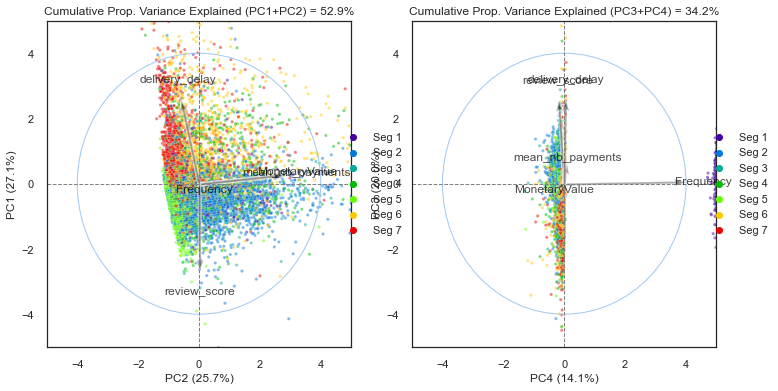

In [140]:
# palette= sns.color_palette('nipy_spectral_r', n_colors=9).as_hex()
cols = [*FEATURES_3, CLUSTER_COL]
plot_clusters_on_pca(client_clusters[cols], axis_ranks=AXIS_RANKS_0_3)
to_png('PCA - Agglomerative Clustering')

"t-SNE_-_Agglomerative_Clustering.png"


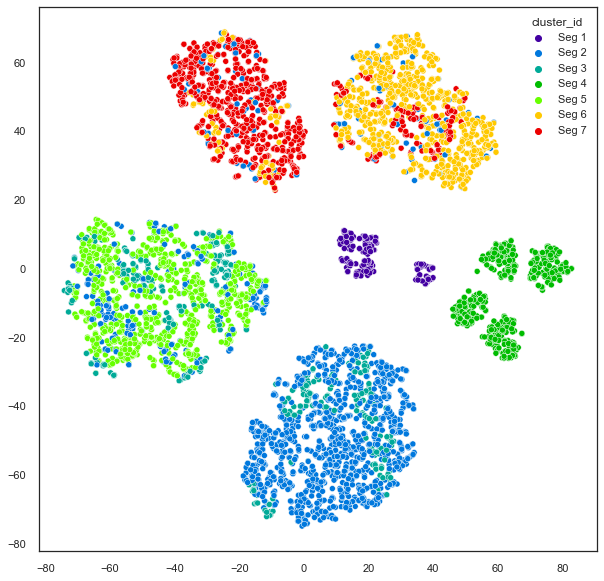

In [141]:
run_fit_plot_tsne(client_clusters)
to_png('t-SNE - Agglomerative Clustering')

cluster_id  cluster_size  cluster_pct  Frequency  MonetaryValue  Recency  \
0      Seg 6           493         4.93       1.00         225.21   286.97   
1      Seg 2          2897        28.97       1.00         191.96   291.55   
2      Seg 3          1605        16.05       1.00         187.04   294.48   
3      Seg 1           303         3.03       2.08         144.74   274.04   
4      Seg 7           440         4.40       1.00         134.46   276.07   
5      Seg 5          1486        14.86       1.00         117.23   286.53   
6      Seg 4          2776        27.76       1.00         113.91   274.17   

   mean_nb_payments  review_score  delivery_time  delivery_delay  \
0              5.04          1.00          21.27           -3.26   
1              4.73          5.00          10.41          -13.33   
2              4.70          3.52          12.92          -11.07   
3              3.39          4.11          11.56          -11.97   
4              1.00          1.00          21.15           -2.36   
5              1.00          3.54          12.58          -10.23   
6              1.00          5.00           9.81          -12.45   

   distance_customer_seller  freight_percent  time_of_day  weekday  \
0                    711.91             0.17        15.13     2.90   
1                    632.40             0.17        14.99     2.80   
2                    644.50             0.17        15.02     2.83   
3                    517.21             0.19        14.28     2.84   
4                    595.48             0.22        14.62     2.77   
5                    575.72             0.23        14.50     2.70   
6                    513.33             0.22        14.75     2.65   

   products_per_order                customer_unique_id payment_mode  \
0                1.35  702843d007357400ece1b13cc1126fd8  credit_card   
1                1.11  ab02f0c74cc456efdfffc308caee4e6b  credit_card   
2                1.12  6747f33f8d299d4c360c6ead53bc3e71  credit_card   
3                1.20  897ecc46977d723a6e514f3ebe92c844  credit_card   
4                1.27  d26795e02bb7290f41bb487ef48d6e2e  credit_card   
5                1.13  bee8c71dfec2314e63b7ef0e2ce70bdd  credit_card   
6                1.10  4c29ad3f71e71c31c6e2a860330cc9a8  credit_card   

  favourite_category customer_state favourite_seller_state cluster_id_bak  
0        office_tech             SP                     SP              5  
1      health_parfum             SP                     SP              2  
2        office_tech             SP                     SP              4  
3           bed_bath             SP                     SP              0  
4        office_tech             SP                     SP              6  
5        office_tech             SP                     SP              3  
6        office_tech             SP                     SP              1

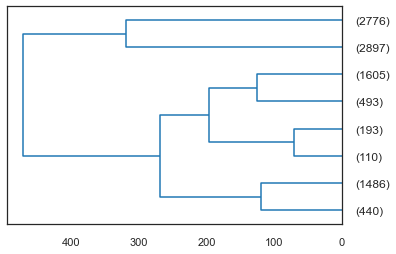

In [142]:
def run_fit_ward_linkage(df: pd.DataFrame, model=model_cah, k=7):
    params = {'clf__linkage': 'ward', 'clf__n_clusters': k}
    model.set_params(**params)
    model.fit(df.select_dtypes('number'))
    clf: AgglomerativeClustering = model.named_steps['clf']
    plot_dendrogram(clf=clf, truncate_mode="lastp", p=k+1,
                    color_threshold=50, orientation='left')
   
    cluster_labels = pd.Series(clf.labels_).to_frame(CLUSTER_COL)
    cluster_labels.index = df.index
    # print(cluster_labels.value_counts())
    return cluster_labels


cluster_labels = run_fit_ward_linkage(
    df_clients_sample[FEATURES_3], model_cah, k=7)
clients_cah = pd.concat([cluster_labels, df_clients_sample], axis=1)
clients_cah.pipe(group_clusters).pipe(rename_cluster_labels)


### Conclusions sur le clustering hiearchique

## 8.2 DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

### 8.2.1 Principal hyper-paramètres
- epsilon (eps) : distance maximal à laquel un point est considéré comme 'voisin'. Au dessus de ce distance, les autres points sont ignorés (du bruit)
- min_samples : le nombre minimal de points dans le voisinage pour qu'un point est consideré un point 'central' du cluster (ne change pas de cluster)


#### Epsilon
La valeur d'epsilon dépend de la metrique de distance utilisé, et le preprocessing des features appliqué.
- si epsilon trop bas -> beaucoup de petit clusters : on risque de ne trouver pas des segmentations globals; les clusters peuvent être instable
- si epsilon trop haut -> beacoup de bruit : on risque de ne detecter pas des nuances entre les clusters

#### Min samples
La valeur de min samples dépend du taille du dataset, et le minimum cluster size consideré acceptable
- si min_samples est trop bas : on risque de crée des trop petit clusters
- si min_samples est trop haut : on risque de ne detecter pas les groupes plus petites


 0    2896
 1    2776
 3    1601
 2    1484
 5     490
 4     440
-1     313
dtype: int64
"Spider_plot_-_DBSCAN_clusters.png"


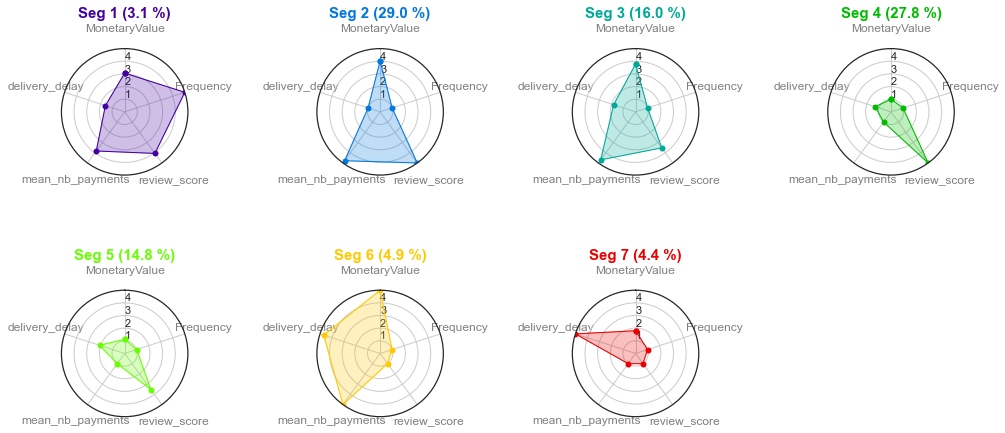

In [143]:
from sklearn.cluster import DBSCAN

model_dbscan = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(output_distribution='normal')),
    ('clf', DBSCAN(eps=2, min_samples=100))
])


def run_fit_labels(df: pd.DataFrame, model=model_dbscan, features=FEATURES):
    df = df.copy()
    model.fit(df[features])
    clf = model.named_steps['clf']
    print(pd.Series(clf.labels_).value_counts())
    df[CLUSTER_COL] = clf.labels_
    return df


client_clusters = run_fit_labels(df_clients_sample, model_dbscan).pipe(rename_cluster_labels)
client_groups = group_clusters(client_clusters)
plot_spider(client_groups, features=FEATURES_3)
to_png('Spider plot - DBSCAN clusters')


### 8.2.2 Choix d'epsilon pour DBSCAN

- <https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc>


"DBSCAN_-_Choice_of_epsilon_(elbow_method).png"


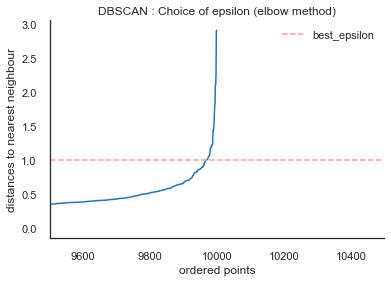

In [144]:
from sklearn.neighbors import NearestNeighbors


def best_epsilon(df, preprocessor=QuantileTransformer(output_distribution='normal')):
    X = pd.DataFrame(preprocessor.fit_transform(df))
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    plt.plot(distances)
    n = X.shape[0]
    plt.xlim((n*0.95, n*1.05))
    plt.xlabel('ordered points')
    plt.ylabel('distances to nearest neighbour')
    sns.despine()


best_epsilon(df_clients_sample[FEATURES])
plt.axhline(1, c='r', ls='--', label='best_epsilon')
plt.legend()
plt.title('DBSCAN : Choice of epsilon (elbow method)')
to_png()


In [145]:

param_grid = {
    'clf__eps': [0.5, 0.75, 1, 2, 4],
    'clf__min_samples': [10, 20, 50, 100, 200]
}
scores_dbscan = score_model(
    df=df_clients_sample[FEATURES], model=model_dbscan, param_grid=param_grid)


params={'clf__eps': 0.5, 'clf__min_samples': 10}; k=9; cluster_sizes=[28, 28, 14, 14, 8, 4, 3, 0, 0]
params={'clf__eps': 0.5, 'clf__min_samples': 20}; k=8; cluster_sizes=[28, 28, 14, 14, 11, 3, 1, 1]
params={'clf__eps': 0.5, 'clf__min_samples': 50}; k=6; cluster_sizes=[31, 27, 24, 12, 5, 1]
params={'clf__eps': 0.5, 'clf__min_samples': 100}; k=4; cluster_sizes=[51, 25, 18, 6]
params={'clf__eps': 0.5, 'clf__min_samples': 200}; k=3; cluster_sizes=[74, 21, 5]
params={'clf__eps': 0.75, 'clf__min_samples': 10}; k=11; cluster_sizes=[29, 28, 16, 15, 5, 4, 2, 1, 0, 0, 0]
params={'clf__eps': 0.75, 'clf__min_samples': 20}; k=8; cluster_sizes=[29, 28, 15, 15, 4, 4, 4, 1]
params={'clf__eps': 0.75, 'clf__min_samples': 50}; k=8; cluster_sizes=[29, 28, 15, 14, 9, 4, 1, 1]
params={'clf__eps': 0.75, 'clf__min_samples': 100}; k=6; cluster_sizes=[28, 27, 18, 14, 12, 1]
params={'clf__eps': 0.75, 'clf__min_samples': 200}; k=5; cluster_sizes=[31, 27, 26, 12, 5]
params={'clf__eps': 1, 'clf__min_samples': 10};

In [146]:
print(list(scores_dbscan.columns))


['davies_bouldin', 'silhouette_time', 'calinski_harabasz', 'preprocessor', 'silhouette_score', 'clf', 'silhouette_sample_sizes', 'silhouette_score_std', 'k', 'clf__eps', 'clf__min_samples', 'cluster_sizes', 'fit time (s)', 'stability_sample_sizes', 'stability_score', 'stability_score_std', 'stability_time']


In [147]:
scores_dbscan['clf__eps'] = scores_dbscan['clf__eps'].astype('category')
(scores_dbscan[['clf__eps', 'clf__min_samples', 'davies_bouldin',
            'silhouette_score', 'k', 'cluster_sizes']]
 .sort_values(by='silhouette_score', ascending=False)
 ).head()


clf__eps  clf__min_samples  davies_bouldin  silhouette_score   k  \
15     2.00             10.00            1.06              0.67  11   
17     2.00             50.00            1.19              0.66  10   
16     2.00             20.00            1.06              0.66  11   
21     4.00             20.00            0.64              0.64   9   
10     1.00             10.00            1.44              0.64  11   

                            cluster_sizes  
15  [29, 28, 16, 15, 5, 4, 1, 1, 1, 0, 0]  
17     [29, 28, 16, 15, 5, 4, 1, 1, 1, 1]  
16  [29, 28, 16, 15, 5, 4, 1, 1, 1, 0, 0]  
21        [29, 28, 21, 19, 1, 1, 1, 0, 0]  
10  [29, 28, 16, 15, 5, 4, 1, 1, 1, 0, 0]

"DBSCAN_-_effet_de_[eps,_min_samples]_sur_silhouette_score.png"


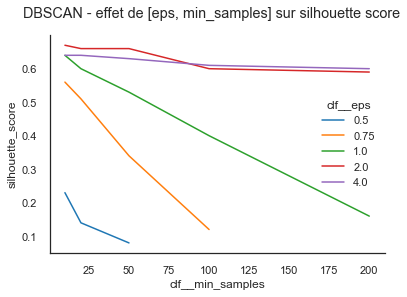

In [148]:
sns.lineplot(data=scores_dbscan, x='clf__min_samples',
             y='silhouette_score', hue='clf__eps', palette='tab10')
sns.despine()
plt.suptitle('DBSCAN - effet de [eps, min_samples] sur silhouette score')
to_png()

"DBSCAN_-_effet_de_[eps,_min_samples]_sur_davies_bouldin_score.png"


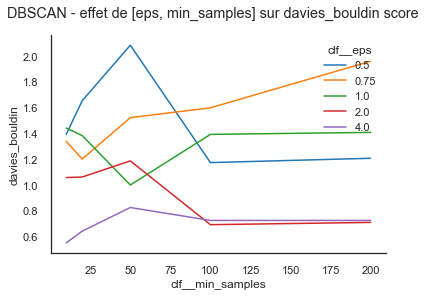

In [149]:
sns.lineplot(data=scores_dbscan, x='clf__min_samples',
             y='davies_bouldin', hue='clf__eps', palette='tab10')
sns.despine()
plt.suptitle('DBSCAN - effet de [eps, min_samples] sur davies_bouldin score')
to_png()

"DBSCAN_-_effet_de_[eps,_min_samples]_sur_calinski_harabasz.png"


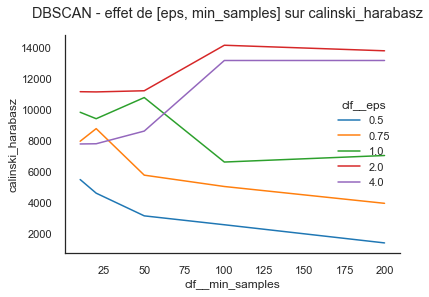

In [150]:
sns.lineplot(data=scores_dbscan, x='clf__min_samples',
             y='calinski_harabasz', hue='clf__eps', palette='tab10')
sns.despine()
plt.suptitle('DBSCAN - effet de [eps, min_samples] sur calinski_harabasz')
to_png()

"DBSCAN_-_effet_de_[eps,_min_samples]_sur_fit_time.png"


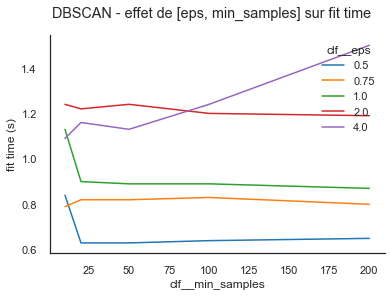

In [151]:
sns.lineplot(data=scores_dbscan, x='clf__min_samples',
             y='fit time (s)', hue='clf__eps', palette='tab10')
sns.despine()
plt.suptitle('DBSCAN - effet de [eps, min_samples] sur fit time')
to_png()

Les meilleurs résultats pour DBSCAN semble être pour eps=2 :

- haut silhouette score
- bas davies_bouldin
- haut valeur calinski harabasz


In [152]:
scores_dbscan[scores_dbscan['clf__eps'] == 2]


davies_bouldin  silhouette_time  calinski_harabasz         preprocessor  \
15            1.06             1.74           11125.17  QuantileTransformer   
16            1.06             1.59           11111.80  QuantileTransformer   
17            1.19             1.56           11186.02  QuantileTransformer   
18            0.69             1.58           14107.81  QuantileTransformer   
19            0.71             1.52           13751.44  QuantileTransformer   

    silhouette_score     clf silhouette_sample_sizes  silhouette_score_std  \
15              0.67  DBSCAN                    2000                  0.00   
16              0.66  DBSCAN                    2000                  0.00   
17              0.66  DBSCAN                    2000                  0.00   
18              0.60  DBSCAN                    2000                  0.01   
19              0.59  DBSCAN                    2000                  0.01   

     k clf__eps  clf__min_samples                          cluster_sizes  \
15  11     2.00             10.00  [29, 28, 16, 15, 5, 4, 1, 1, 1, 0, 0]   
16  11     2.00             20.00  [29, 28, 16, 15, 5, 4, 1, 1, 1, 0, 0]   
17  10     2.00             50.00     [29, 28, 16, 15, 5, 4, 1, 1, 1, 1]   
18   7     2.00            100.00              [29, 28, 16, 15, 5, 4, 3]   
19   7     2.00            200.00              [29, 28, 16, 15, 5, 4, 3]   

    fit time (s)  stability_sample_sizes  stability_score  \
15          1.24                10000.00             1.00   
16          1.22                10000.00             1.00   
17          1.24                10000.00             1.00   
18          1.20                10000.00             1.00   
19          1.19                10000.00             1.00   

    stability_score_std  stability_time  
15                 0.00           12.28  
16                 0.00           12.71  
17                 0.00           12.98  
18                 0.00           12.81  
19                 0.00           12.40

 0    2896
 1    2776
 3    1601
 2    1484
 5     490
 4     440
-1     313
dtype: int64
"Clusters_trouvé_par_DBSCAN_(eps=2,_min_samples=100,_features=['MonetaryValue',_'Frequency',_'review_score',_'mean_nb_payments',_'delivery_delay'].png"


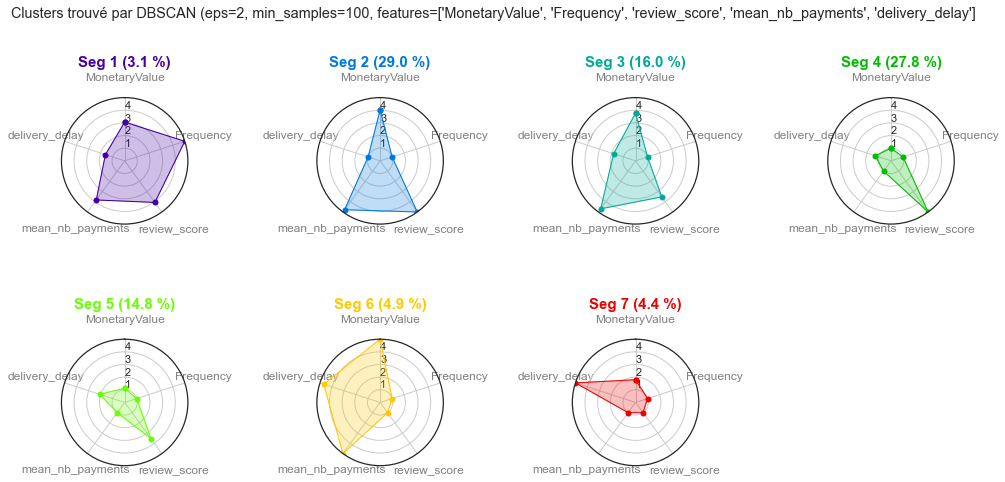

In [153]:
from sklearn.cluster import DBSCAN

model_dbscan = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(
        output_distribution='normal', random_state=RANDOM_SEED)),
    ('clf', DBSCAN(eps=2, min_samples=100))
])


def run_fit_labels(df: pd.DataFrame, model=model_dbscan, features=FEATURES):
    """shortcut to run model and return dataset with fitted cluster labels"""
    df = df.copy()
    model.fit(df[features])
    clf = model.named_steps['clf']
    print(pd.Series(clf.labels_).value_counts())
    df[CLUSTER_COL] = clf.labels_
    return df

client_clusters = run_fit_labels(df_clients_sample, model_dbscan)
client_groups = group_clusters(client_clusters)
plot_spider(client_groups, features=FEATURES_3)
plt.suptitle(
    f'Clusters trouvé par DBSCAN (eps=2, min_samples=100, features={FEATURES_3}')
to_png()


"Clusters_trouvé_par_DBSCAN_sur_t-SNE_(features=['MonetaryValue',_'Frequency',_'review_score',_'mean_nb_payments',_'delivery_delay']).png"


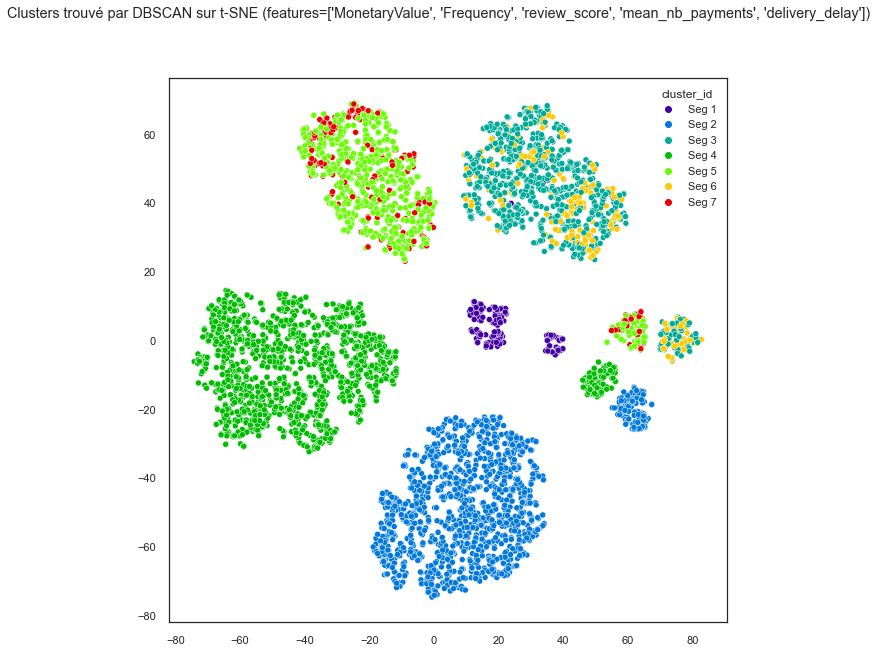

In [154]:
run_fit_plot_tsne(client_clusters.pipe(rename_cluster_labels))
plt.suptitle(f'Clusters trouvé par DBSCAN sur t-SNE (features={FEATURES_3})')
to_png()


#### Silhouette visualisation

On ne peut pas visualiser les silhouette scores

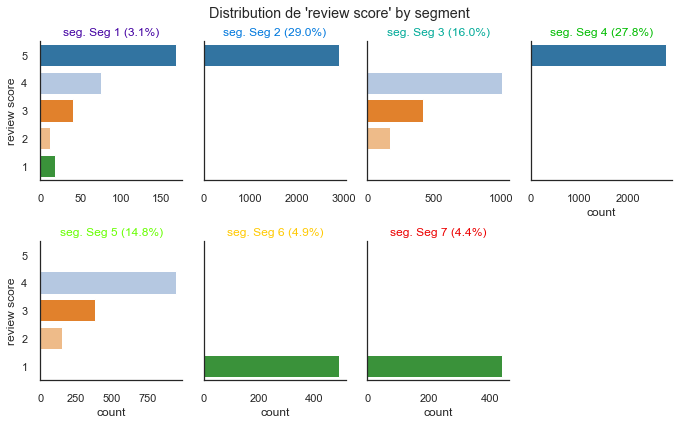

In [155]:
client_clusters= client_clusters.pipe(rename_cluster_labels)
client_clusters['review score'] = pd.cut(client_clusters['review_score'], bins=[
                                          0, 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5]).astype(int)
plot_categ_by_cluster(client_clusters, 'review score')

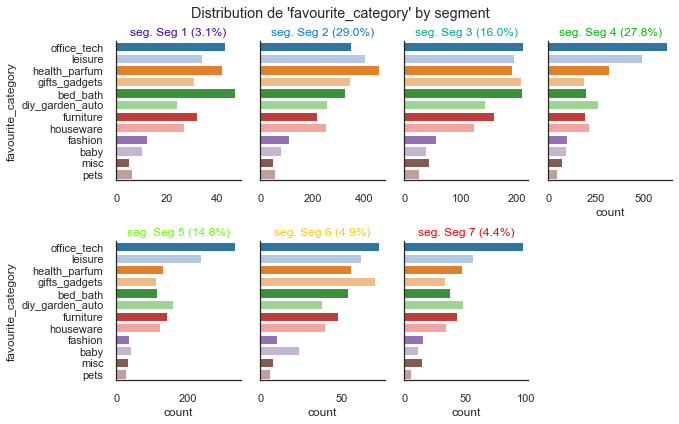

In [156]:
plot_categ_by_cluster(client_clusters,'favourite_category')

Index(['customer_unique_id', 'dernier_achat', 'Frequency', 'MonetaryValue',
       'Recency', 'mean_nb_payments', 'review_score', 'delivery_time',
       'delivery_delay', 'distance_customer_seller', 'freight_percent',
       'payment_mode', 'favourite_category', 'customer_state',
       'favourite_seller_state', 'time_of_day', 'weekday',
       'products_per_order', 'cluster_id', 'cluster_id_bak', 'review score'],
      dtype='object')


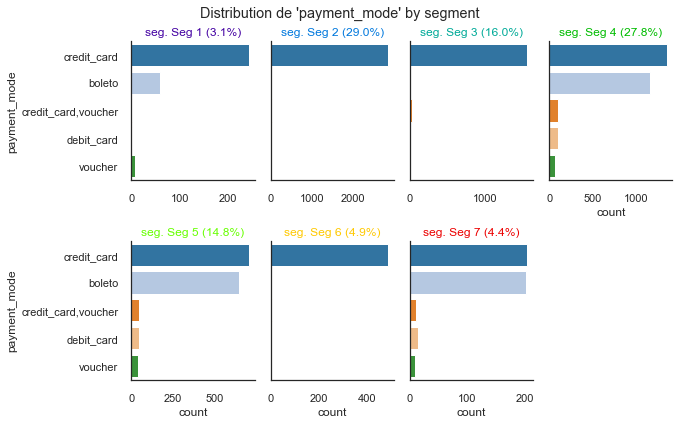

In [157]:
print(client_clusters.columns)
plot_categ_by_cluster(client_clusters,'payment_mode')


In [158]:
# plot_categ_by_cluster(client_clusters,'customer_state')


In [159]:
# plot_categ_by_cluster(client_clusters,'favourite_seller_state')

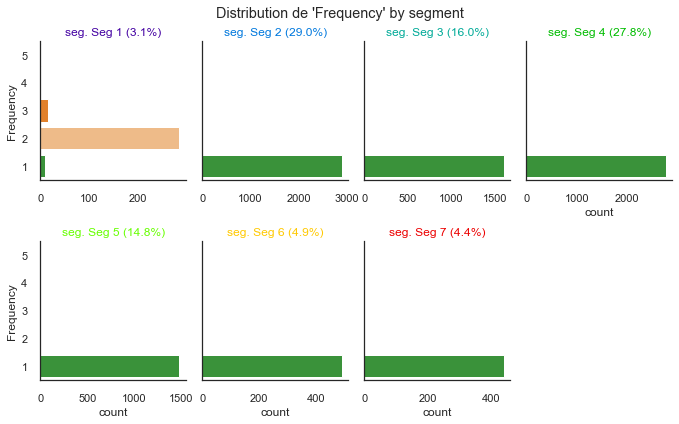

In [160]:
plot_categ_by_cluster(client_clusters,'Frequency')

## Clustering Kprototype

On peut ajouter les categories one_hot encoded et utiliser Kprototype pour developer un model plus profond. Ce travail n'est pas dans la portée de ce projet, car il exige plus de temps.

- https://pypi.org/project/kmodes/
- https://kprototypes.readthedocs.io/en/latest/index.html
- https://python.plainenglish.io/data-science-project-clustering-mixed-data-7d5fd6e7f047
- https://www.programsbuzz.com/article/k-prototype-clustering-python
- https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb

